# Anticipez les besoins en consommation de bâtiments - *Notebook exploratoire*

## Mission

Vous travaillez pour la ville de Seattle. Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, votre équipe s’intéresse de près à la consommation et aux émissions des bâtiments non destinés à l’habitation.

Des relevés minutieux ont été effectués par les agents de la ville en 2016. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l’habitation pour lesquels elles n’ont pas encore été mesurées.

Votre prédiction se basera sur les données structurelles des bâtiments (taille et usage des bâtiments, date de construction, situation géographique, ...)

Vous cherchez également à évaluer l’intérêt de l’ENERGY STAR Score pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe. Vous l'intégrerez dans la modélisation et jugerez de son intérêt.

Vous sortez tout juste d’une réunion de brief avec votre équipe. Voici un récapitulatif de votre mission :


1) Réaliser une courte analyse exploratoire.
2) Tester différents modèles de prédiction afin de répondre au mieux à la problématique.

Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).

Mets en place une évaluation rigoureuse des performances, et optimise les hyperparamètres et le choix d’algorithmes de ML à l’aide d’une validation croisée. Tu testeras au minimum 4 algorithmes de famille différente (par exemple : ElasticNet, SVM, GradientBoosting, RandomForest).

## Analyse exploratoire des datasets et 1er feature engineering

### 1 - Découverte du jeu de données

In [4]:
import numpy as np

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import scipy
from scipy import stats
import scipy.stats as st

import statsmodels
import statsmodels.api as sm
import missingno as msno

import sklearn
from sklearn.experimental import enable_iterative_imputer  # Nécessaire pour activer IterativeImputer
from sklearn.impute import IterativeImputer

from sklearn.impute import KNNImputer
# Encodage des variables catégorielles avant d'utiliser KNNImputer
from category_encoders.ordinal import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import QuantileTransformer
from category_encoders import TargetEncoder

# pour le centrage et la réduction
from sklearn.preprocessing import StandardScaler
# pour l'ACP
from sklearn.decomposition import PCA

from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix

from sklearn import dummy
from sklearn.dummy import DummyClassifier

from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression

from sklearn.svm import LinearSVC

from sklearn import kernel_ridge

from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier

import tensorflow
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

import timeit

print("numpy version", np.__version__)
print("pandas version", pd.__version__)
print("matplotlib version", matplotlib.__version__)
print("seaborn version", sns.__version__)
print("scipy version", scipy.__version__)
print("statsmodels version", statsmodels.__version__)
print("missingno version", msno.__version__)

print("sklearn version", sklearn.__version__)
print("tensorflow version", tensorflow.__version__)

pd.options.display.max_rows = 200
pd.options.display.max_columns = 100

numpy version 1.26.4
pandas version 2.1.4
matplotlib version 3.8.0
seaborn version 0.13.2
scipy version 1.11.4
statsmodels version 0.14.0
missingno version 0.5.2
sklearn version 1.2.2
tensorflow version 2.18.0


In [5]:
# Charger le fichier de données
data = pd.read_csv("C:/Users/admin/Documents/Projets/Projet_4/data_projet/source/2016_Building_Energy_Benchmarking.csv", sep=',', low_memory=False)
data.head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
4              8      2016  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 LENORA ST  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                    0659000030                    7     DOWNTOWN  47.61220   
1                    0659000220                    7     DOWNTOWN  47.61317   
2                    0659000475                    7     DOWNTOWN  47.61393   
3                    0659000640                    7     DOWNTOWN  47.61412   
4                    0659000970                    7     DOWNTOWN  47.61375   

   Longitude  YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799       1927                1.0              12             88434   
1 -122.33393       1996                1.0              11            103566   
2 -122.33810       1969                1.0              41            956110   
3 -122.33664       1926                1.0              10             61320   
4 -122.34047       1980                1.0              18            175580   

   PropertyGFAParking  PropertyGFABuilding(s)      ListOfAllPropertyUseTypes  \
0                   0                   88434                          Hotel   
1               15064                   88502     Hotel, Parking, Restaurant   
2              196718                  759392                          Hotel   
3                   0                   61320                          Hotel   
4               62000                  113580  Hotel, Parking, Swimming Pool   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                   756493.0   
3                  Hotel                    61320.0   
4                  Hotel                   123445.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                          NaN                              NaN   
1                      Parking                          15064.0   
2                          NaN                              NaN   
3                          NaN                              NaN   
4                      Parking                          68009.0   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                         NaN                             NaN   
1                  Restaurant                          4622.0   
2                         NaN                             NaN   
3                         NaN                             NaN   
4               Swimming Pool                             0.0   

  YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                      NaN             60.0         81.699997   
1                      NaN             61.0         94.800003   
2                      NaN             43.0         96.000000   
3                      NaN             56.0        110.800003   
4                      NaN             75.0        114.800003   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0           84.300003          182.500000            189.000000   
1           97.900002          176.100006            179.399994   
2

In [6]:
data.shape

(3376, 46)

In [7]:
data.describe()

OSEBuildingID  DataYear       ZipCode  CouncilDistrictCode  \
count    3376.000000    3376.0   3360.000000          3376.000000   
mean    21208.991114    2016.0  98116.949107             4.439277   
std     12223.757015       0.0     18.615205             2.120625   
min         1.000000    2016.0  98006.000000             1.000000   
25%     19990.750000    2016.0  98105.000000             3.000000   
50%     23112.000000    2016.0  98115.000000             4.000000   
75%     25994.250000    2016.0  98122.000000             7.000000   
max     50226.000000    2016.0  98272.000000             7.000000   

          Latitude    Longitude    YearBuilt  NumberofBuildings  \
count  3376.000000  3376.000000  3376.000000        3368.000000   
mean     47.624033  -122.334795  1968.573164           1.106888   
std       0.047758     0.027203    33.088156           2.108402   
min      47.499170  -122.414250  1900.000000           0.000000   
25%      47.599860  -122.350662  1948.000000           1.000000   
50%      47.618675  -122.332495  1975.000000           1.000000   
75%      47.657115  -122.319407  1997.000000           1.000000   
max      47.733870  -122.220966  2015.000000         111.000000   

       NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
count     3376.000000      3.376000e+03         3376.000000   
mean         4.709123      9.483354e+04         8001.526066   
std          5.494465      2.188376e+05        32326.723928   
min          0.000000      1.128500e+04            0.000000   
25%          2.000000      2.848700e+04            0.000000   
50%          4.000000      4.417500e+04            0.000000   
75%          5.000000      9.099200e+04            0.000000   
max         99.000000      9.320156e+06       512608.000000   

       PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  \
count            3.376000e+03               3.356000e+03   
mean             8.683201e+04               7.917764e+04   
std              2.079398e+05               2.017034e+05   
min              3.636000e+03               5.656000e+03   
25%              2.775600e+04               2.509475e+04   
50%              4.321600e+04               3.989400e+04   
75%              8.427625e+04               7.620025e+04   
max              9.320156e+06               9.320156e+06   

       SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  \
count                      1679.000000                      596.000000   
mean                      28444.075817                    11738.675166   
std                       54392.917928                    29331.199286   
min                           0.000000                        0.000000   
25%                        5000.000000                     2239.000000   
50%                       10664.000000                     5043.000000   
75%                       26640.000000                    10138.750000   
max                      686750.000000                   459748.000000   

       ENERGYSTARScore  SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  \
count      2533.000000       3369.000000         3370.000000   
mean         67.918674         54.732116           57.033798   
std          26.873271         56.273124           57.163330   
min           1.000000          0.000000            0.000000   
25%          53.000000         27.900000           29.400000   
50%          75.000000         38.599998           40.900002   
75%          90.000000         60.400002           64.275002   
max         100.000000        834.400024          834.400024   

       SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  \
count         3367.000000           3367.000000         3.371000e+03   
mean           134.232848            137.783932         5.403667e+06   
std            139.287554            139.109807         2.161063e+07   
min              0.000000             -2.100000         0.000000e+00   
25%             74.699997             78.400002         9.251286e+05

On voit déjà des valeurs aberrantes. Par exemple les valeurs de SourceEUIWN(kBtu/sf) et Electricity(kWh) sont négatives.

In [9]:
list_sort = round(data.isna().mean().sort_values() * 100, 2)
print('Pourcentage de valeurs manquantes par colonne')
list_sort

Pourcentage de valeurs manquantes par colonne


OSEBuildingID                        0.00
PropertyGFABuilding(s)               0.00
PropertyGFAParking                   0.00
PropertyGFATotal                     0.00
NumberofFloors                       0.00
YearBuilt                            0.00
Longitude                            0.00
Latitude                             0.00
Neighborhood                         0.00
DefaultData                          0.00
CouncilDistrictCode                  0.00
ComplianceStatus                     0.00
State                                0.00
City                                 0.00
Address                              0.00
PropertyName                         0.00
PrimaryPropertyType                  0.00
BuildingType                         0.00
DataYear                             0.00
TaxParcelIdentificationNumber        0.00
SiteEnergyUse(kBtu)                  0.15
SiteEnergyUseWN(kBtu)                0.18
SiteEUIWN(kBtu/sf)                   0.18
SiteEUI(kBtu/sf)                  

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

Pour rappel, il y a 3 376 lignes.

In [12]:
list_sort = round((data == 0).mean().sort_values() * 100, 2)
print('Pourcentage de valeurs = 0 par colonne')
list_sort

Pourcentage de valeurs = 0 par colonne


OSEBuildingID                       0.00
Outlier                             0.00
ComplianceStatus                    0.00
Comments                            0.00
ENERGYSTARScore                     0.00
YearsENERGYSTARCertified            0.00
ThirdLargestPropertyUseType         0.00
SecondLargestPropertyUseType        0.00
LargestPropertyUseType              0.00
ListOfAllPropertyUseTypes           0.00
PropertyGFABuilding(s)              0.00
PropertyGFATotal                    0.00
YearBuilt                           0.00
LargestPropertyUseTypeGFA           0.00
Latitude                            0.00
DataYear                            0.00
BuildingType                        0.00
Neighborhood                        0.00
PrimaryPropertyType                 0.00
CouncilDistrictCode                 0.00
TaxParcelIdentificationNumber       0.00
ZipCode                             0.00
State                               0.00
Longitude                           0.00
City            

In [13]:
list_sort = (data == 0).sum().sort_values()
print('Nombres de valeurs = 0 par colonne')
list_sort

Nombres de valeurs = 0 par colonne


OSEBuildingID                         0
Outlier                               0
ComplianceStatus                      0
Comments                              0
ENERGYSTARScore                       0
YearsENERGYSTARCertified              0
ThirdLargestPropertyUseType           0
SecondLargestPropertyUseType          0
LargestPropertyUseType                0
ListOfAllPropertyUseTypes             0
PropertyGFABuilding(s)                0
PropertyGFATotal                      0
YearBuilt                             0
LargestPropertyUseTypeGFA             0
Latitude                              0
DataYear                              0
BuildingType                          0
Neighborhood                          0
PrimaryPropertyType                   0
CouncilDistrictCode                   0
TaxParcelIdentificationNumber         0
ZipCode                               0
State                                 0
Longitude                             0
City                                  0


In [14]:
data.nunique()

OSEBuildingID                      3376
DataYear                              1
BuildingType                          8
PrimaryPropertyType                  24
PropertyName                       3362
Address                            3354
City                                  1
State                                 1
ZipCode                              55
TaxParcelIdentificationNumber      3268
CouncilDistrictCode                   7
Neighborhood                         19
Latitude                           2876
Longitude                          2656
YearBuilt                           113
NumberofBuildings                    17
NumberofFloors                       50
PropertyGFATotal                   3195
PropertyGFAParking                  496
PropertyGFABuilding(s)             3193
ListOfAllPropertyUseTypes           466
LargestPropertyUseType               56
LargestPropertyUseTypeGFA          3122
SecondLargestPropertyUseType         50
SecondLargestPropertyUseTypeGFA    1352


In [15]:
data['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Campus', 'Multifamily LR (1-4)',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

In [16]:
data['PrimaryPropertyType'].unique()

array(['Hotel', 'Other', 'Mid-Rise Multifamily', 'Mixed Use Property',
       'K-12 School', 'University', 'Small- and Mid-Sized Office',
       'Self-Storage Facility', 'Warehouse', 'Large Office',
       'Senior Care Community', 'Medical Office', 'Retail Store',
       'Hospital', 'Residence Hall', 'Distribution Center',
       'Worship Facility', 'Low-Rise Multifamily',
       'Supermarket / Grocery Store', 'Laboratory',
       'Refrigerated Warehouse', 'Restaurant', 'High-Rise Multifamily',
       'Office'], dtype=object)

In [17]:
data['CouncilDistrictCode'].unique()

array([7, 3, 2, 4, 5, 6, 1], dtype=int64)

In [18]:
data['Neighborhood'].unique()

array(['DOWNTOWN', 'SOUTHEAST', 'NORTHEAST', 'EAST', 'Central', 'NORTH',
       'MAGNOLIA / QUEEN ANNE', 'LAKE UNION', 'GREATER DUWAMISH',
       'BALLARD', 'NORTHWEST', 'CENTRAL', 'SOUTHWEST', 'DELRIDGE',
       'Ballard', 'North', 'Delridge', 'Northwest',
       'DELRIDGE NEIGHBORHOODS'], dtype=object)

In [19]:
data['LargestPropertyUseType'].unique()

array(['Hotel', 'Police Station', 'Other - Entertainment/Public Assembly',
       'Multifamily Housing', 'Library', 'Fitness Center/Health Club/Gym',
       'Social/Meeting Hall', 'Courthouse', 'Other', 'K-12 School',
       'College/University', 'Automobile Dealership', 'Office',
       'Self-Storage Facility', 'Non-Refrigerated Warehouse',
       'Other - Mall', 'Senior Care Community', 'Medical Office',
       'Retail Store', 'Hospital (General Medical & Surgical)', 'Museum',
       'Repair Services (Vehicle, Shoe, Locksmith, etc)',
       'Other - Lodging/Residential', 'Residence Hall/Dormitory',
       'Other/Specialty Hospital', 'Financial Office',
       'Distribution Center', 'Parking', 'Worship Facility', 'Restaurant',
       'Data Center', 'Laboratory', 'Supermarket/Grocery Store',
       'Convention Center', 'Urgent Care/Clinic/Other Outpatient', nan,
       'Other - Services', 'Strip Mall', 'Wholesale Club/Supercenter',
       'Refrigerated Warehouse', 'Manufacturing/Indust

In [20]:
data['Outlier'].unique()

array([nan, 'High outlier', 'Low outlier'], dtype=object)

In [21]:
mask = (data['Outlier'] == 'High outlier') | (data['Outlier'] == 'Low outlier')
print("Nombre de propriétés aberrantes : ", data.loc[mask].shape[0])

Nombre de propriétés aberrantes :  32


In [22]:
data['ComplianceStatus'].unique()

array(['Compliant', 'Error - Correct Default Data', 'Missing Data',
       'Non-Compliant'], dtype=object)

In [23]:
mask = data['ComplianceStatus'].isin(['Non-Compliant'])
print("Nombre de propriétés not compliant :", data.loc[mask].shape[0])

mask = data['ComplianceStatus'].isin(['Missing Data'])
print("Nombre de propriétés missing-data :", data.loc[mask].shape[0])

mask = data['ComplianceStatus'].isin(['Error - Correct Default Data'])
print("Nombre de propriétés error :", data.loc[mask].shape[0])

Nombre de propriétés not compliant : 37
Nombre de propriétés missing-data : 15
Nombre de propriétés error : 113


On constate:
- Il n'y a qu'une seule année dans le dataset
- Il y a 8 types d'immmeuble (BuildingType)
- Il y a une seule ville : Seattle, dans un seul état
- Il y a 7 districts différents (CouncilDistrictCode)
- Il y a 19 quartiers (Neighborhood), mais certains sont en double, donc 13 réels (nettoyage à prévoir)
- Il y a 55 codes postaux différents (ZipCode)
- Il y a 113 années de construction différentes (yearBuilt)
- Il y a 100 valeurs différentes pour l'ENERGYSTARScore
- Plusieurs batiments ont la même consommation d'energie, et le même taux d'émission de COS
- Quelques bâtiments ont la même adresse
- La feature 'Outlier' ne contient que 2 valeurs : High outlier et Low outlier. Et 99% des valeurs sont manquantes. Elle n'est donc pas utlisable
- La feature 'ComplianceStatus' contient 4 valeurs : Compliant', 'Error - Correct Default Data', 'Missing Data', et 'Non-Compliant'. Toutes les valeurs sont présentes.

In [25]:
data.duplicated().sum()

0

Il n'y a pas de données dupliquées.

### 2 - Choix des variables

#### 2.1 - Sources d'energie

Il y a 3 sources d'energie dans le fichier : electricité, vapeur, gaz naturel.

Il faut choisir les sources exprimées en kBtu pour pouvoir les comparer entre elles, et déterminer la proportion utilisée par bâtiment.

Il s'agit des variables : Electricity(kBtu) , NaturalGas(kBtu), SteamUse(kBtu) 

Ces 3 variables sont assez bien utilisées.

#### 2.2 - Données structurelles

Liste des données structurelles
- PrimaryPropertyType (usage principal)
- Neighborhood (quartier)
- YearBuilt (année de construction) - créer des périodes (nouvelle variable catégorielle)
- NumberofBuildings (nombre de bâtiments)
- NumberofFloors (nombre d'étages)
- PropertyGFATotal (surface plancher brute bâtiment et stationnement)
- PropertyGFAParking (surface totale des stationnements en pieds carrés)  - dans un second temps pour l'amélioration des modèles
- PropertyGFABuilding(s) (surface des bâtiments hors stationnement en pieds carrés)  - dans un second temps pour l'amélioration des modèles
- LargestPropertyUseType (doublon avec PrimaryPropertyType ???)  - dans un second temps pour l'amélioration des modèles
- LargestPropertyUseTypeGFA (surface d'utlisation du type d'usage principal)  - dans un second temps pour l'amélioration des modèles

SecondLargestPropertyUseType et ThirdLargestPropertyUseType ne sont pas suffisamment valorisées, respectivement 50% et 82% de valeurs manquantes.

#### 2.3 - Choix des 2 variables cibles


Le dataset ne contient pas la superficie des bâtiments : faut-il donner les cibles en valeur absolue ? Ou divisée par la superficie ?


**Consommation totale d’énergie**

Il y a plusieurs features qui pourraient représenter la consommation totale d'energy. Mais la plus pertinente est 'SiteEnergyUseWN(kBtu)', car :
- Elle est très bien valorisée (0,18 % de valeurs manquantes)
- Elle intègre toutes les sources d'energy
- Elle est harmonisée
- Sa valeur n'est pas déterminée en fonction de la superficie du bâtiment

**émissions de CO2**

Il y a plusieurs features qui pourraient représenter les émissions de CO2. Mais la plus pertinente est 'TotalGHGEmissions', car :
- Elle est très bien valorisée (0,27 % de valeurs manquantes)
- Sa valeur n'est pas déterminée en fonction de la superficie du bâtiment

#### 2.4 - ENERGYSTARScore

Il est assez mal valorisé. Il s'agit d'une note de 1 à 100 calculée, qui évalue la performance énergétique globale d'une propriété, sur la base de données nationales pour contrôler les différences entre le climat, les utilisations et les opérations du bâtiment. Un score de 50 représente la médiane nationale.

### 3 - Filter le dataset sur les bâtiments non destinés à l'habitation

La variable qui permet d'identifier le caractère résidentiel ou non est "BuildingType". Elle prend les valeurs suivantes :

In [34]:
data['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Campus', 'Multifamily LR (1-4)',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

Si on demande à ChatGPT de décrire ces types, voici ce qu'on obtient :

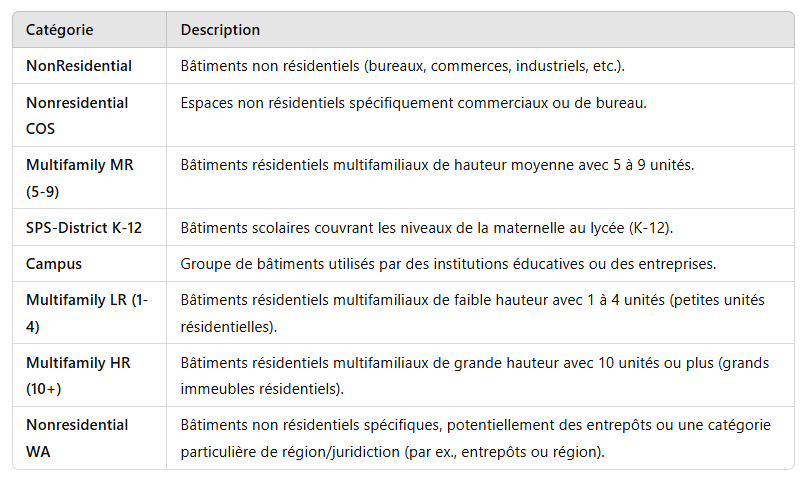

Pour le projet, nous allons donc retenir les catégories suivantes :
- NonResidential
- Nonresidential COS
- SPS-District K-12
- Campus
- Nonresidential WA

In [38]:
building_types = ['NonResidential', 'Nonresidential COS', 'SPS-District K-12', 'Campus', 'Nonresidential WA']

In [39]:
mask = data['BuildingType'].isin(building_types)
data = data.loc[mask]
data.shape

(1668, 46)

Il reste la moitié des bâtiments dans le dataset.

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1668 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    1668 non-null   int64  
 1   DataYear                         1668 non-null   int64  
 2   BuildingType                     1668 non-null   object 
 3   PrimaryPropertyType              1668 non-null   object 
 4   PropertyName                     1668 non-null   object 
 5   Address                          1668 non-null   object 
 6   City                             1668 non-null   object 
 7   State                            1668 non-null   object 
 8   ZipCode                          1652 non-null   float64
 9   TaxParcelIdentificationNumber    1668 non-null   object 
 10  CouncilDistrictCode              1668 non-null   int64  
 11  Neighborhood                     1668 non-null   object 
 12  Latitude                 

### 4 - Supprimer les produits qui n'ont pas de valeurs cibles

In [43]:
cibles = ['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']

In [44]:
data.shape

(1668, 46)

**Rechercher et supprimer les valeurs manquantes**

In [46]:
mask = data['SiteEnergyUseWN(kBtu)'].isna()
print(data.loc[mask, ['PropertyName', 'SiteEnergyUseWN(kBtu)']])

                                 PropertyName  SiteEnergyUseWN(kBtu)
563   Market Place I & II-2003 Western Avenue                    NaN
578                          SEATTLE BUILDING                    NaN
2670                         KALBERG BUILDING                    NaN


In [47]:
mask = ~data['SiteEnergyUseWN(kBtu)'].isna()
data = data.loc[mask]

In [48]:
data.shape

(1665, 46)

In [49]:
mask = data['TotalGHGEmissions'].isna()
print(data.loc[mask, ['PropertyName', 'TotalGHGEmissions']])

Empty DataFrame
Columns: [PropertyName, TotalGHGEmissions]
Index: []


Les valeurs de la variable TotalGHGEmissions des lignes supprimées étaient aussi manquantes

**Rechercher et supprimer les valeurs nulles qui sont à considérer comme manquante**

In [52]:
mask = data['SiteEnergyUseWN(kBtu)'] == 0
print(data.loc[mask, ['PropertyName', 'SiteEnergyUseWN(kBtu)']])

                                     PropertyName  SiteEnergyUseWN(kBtu)
28                                 Meany Building                    0.0
31                            John Hay Elementary                    0.0
62                       Arbor Heights Elementary                    0.0
81                                 Pathfinder K-8                    0.0
85                           John Muir Elementary                    0.0
95                            B.F. Day Elementary                    0.0
133                                Whitman Middle                    0.0
139                             Washington Middle                    0.0
152                       Olympic View Elementary                    0.0
220                               Norton Building                    0.0
247                        Metropolitan Park East                    0.0
284               Onni 1411 Fourth Development LP                    0.0
304            Washington State Convention Center  

In [53]:
mask = ~(data['SiteEnergyUseWN(kBtu)'] == 0)
data = data.loc[mask]

In [54]:
data.shape

(1640, 46)

In [55]:
mask = data['TotalGHGEmissions'] == 0
print(data.loc[mask, ['PropertyName', 'TotalGHGEmissions']])

                  PropertyName  TotalGHGEmissions
513  IUC- Whole Foods Interbay                0.0


In [56]:
mask = ~(data['TotalGHGEmissions'] == 0)
data = data.loc[mask]

In [57]:
data.shape

(1639, 46)

### 5 - Automatiser les étapes 3 et 4

In [59]:
# Charger le fichier de données
data = pd.read_csv("C:/Users/admin/Documents/Projets/Projet_4/data_projet/source/2016_Building_Energy_Benchmarking.csv", sep=',', low_memory=False)
data.shape

(3376, 46)

In [60]:
def select_dataset(df):

    # Filter le dataset sur les bâtiments non destinés à l'habitation
    building_types = ['NonResidential', 'Nonresidential COS', 'SPS-District K-12', 'Campus', 'Nonresidential WA']
    mask = df['BuildingType'].isin(building_types)
    df = df.loc[mask]
    
    # Supprimer les produits qui n'ont pas de valeurs cibles
    ## Rechercher et supprimer les valeurs manquantes
    mask = ~df['SiteEnergyUseWN(kBtu)'].isna()
    df = df.loc[mask]
    mask = ~df['TotalGHGEmissions'].isna()
    df = df.loc[mask]

    ## Rechercher et supprimer les valeurs nulles qui sont à considérer comme manquantes
    mask = (df['SiteEnergyUseWN(kBtu)'] != 0) & (df['TotalGHGEmissions'] != 0)
    df = df.loc[mask]

    return df    

In [61]:
data = select_dataset(data)
data.shape

(1639, 46)

### 6 - 1er feature engineering

#### 6.1 - Traiter les valeurs manquantes des features de consommation d'energy

In [64]:
mask = (data['Electricity(kBtu)'] == 0) & (data['NaturalGas(kBtu)'] == 0) & (data['SteamUse(kBtu)'] == 0)
print("Nombre de lignes où les valeurs des 3 types d'energy sont nulles : ", data.loc[mask].shape[0])

Nombre de lignes où les valeurs des 3 types d'energy sont nulles :  0


In [65]:
mask = (data['Electricity(kBtu)'].isna()) & (data['NaturalGas(kBtu)'].isna()) & (data['SteamUse(kBtu)'].isna())
print("Nombre de lignes où les valeurs des 3 types d'energy sont manquantes : ", data.loc[mask].shape[0])

Nombre de lignes où les valeurs des 3 types d'energy sont manquantes :  0


Il n'y a pas de données à supprimer ici.

#### 6.2 - Filtrer sur les variables "Outlier" et "CompliantStatus"

In [68]:
mask = (data['Outlier'] == 'High outlier') | (data['Outlier'] == 'Low outlier')
print("Nombre de propriétés aberrantes : ", data.loc[mask].shape[0])

Nombre de propriétés aberrantes :  17


Comme le nombre de propriété aberrantes concerne 1% du dataset, on peut supprimer ces lignes:

In [70]:
data.shape

(1639, 46)

In [71]:
mask = ~data['Outlier'].isin(['High outlier', 'Low outlier'])
data = data.loc[mask]
data.shape

(1622, 46)

In [72]:
mask = data['ComplianceStatus'].isin(['Non-Compliant'])
print("Nombre de propriétés not compliant :", data.loc[mask].shape[0])

mask = data['ComplianceStatus'].isin(['Missing Data'])
print("Nombre de propriétés missing-data :", data.loc[mask].shape[0])

mask = data['ComplianceStatus'].isin(['Error - Correct Default Data'])
print("Nombre de propriétés error :", data.loc[mask].shape[0])

Nombre de propriétés not compliant : 0
Nombre de propriétés missing-data : 0
Nombre de propriétés error : 85


Les 85 propriétés en erreur représentent 5% du dataset. Cela fait beaucoup à supprimer. Donc pour le moment je les conserve pour le 1er feature engineering, car la description de cette variable n'est pas claire sur ce type d'erreur. Peut-être qu'on les supprimera ensuite pour améliorer le modèle.

**Automatisation:**

In [75]:
def delete_outliers(df):
    mask = ~df['Outlier'].isin(['High outlier', 'Low outlier'])
    df= df.loc[mask]
    return df

#### 6.3 - Nettoyer les données de la variable cible SiteEnergyUseWN(kBtu)

Liste des variables du 1er feature engineering :

In [78]:
features_fe1 = ['PrimaryPropertyType', 'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', \
                'Electricity(kBtu)', 'NaturalGas(kBtu)', 'SteamUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']

**Traiter les valeurs aberrantes**

In [80]:
data[features_fe1].describe()

YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
count  1622.000000        1622.000000     1622.000000      1.622000e+03   
mean   1962.048089           1.102959        4.136868      1.132678e+05   
std      32.689652           1.170743        6.620385      1.934086e+05   
min    1900.000000           0.000000        0.000000      1.128500e+04   
25%    1930.000000           1.000000        1.000000      2.939250e+04   
50%    1965.500000           1.000000        2.000000      4.898850e+04   
75%    1989.000000           1.000000        4.000000      1.046775e+05   
max    2015.000000          27.000000       99.000000      2.200000e+06   

       Electricity(kBtu)  NaturalGas(kBtu)  SteamUse(kBtu)  \
count       1.622000e+03      1.622000e+03    1.622000e+03   
mean        5.494045e+06      2.012954e+06    4.655916e+05   
std         1.342554e+07      9.491907e+06    5.171827e+06   
min        -1.154170e+05      0.000000e+00    0.000000e+00   
25%         7.418918e+05      0.000000e+00    0.000000e+00   
50%         1.633988e+06      5.313785e+05    0.000000e+00   
75%         4.902622e+06      1.531840e+06    0.000000e+00   
max         2.745325e+08      2.979090e+08    1.349435e+08   

       SiteEnergyUseWN(kBtu)  TotalGHGEmissions  
count           1.622000e+03        1622.000000  
mean            8.219665e+06         181.147244  
std             2.227302e+07         711.156893  
min             5.811420e+04          -0.800000  
25%             1.362387e+06          20.870000  
50%             2.772078e+06          50.245000  
75%             7.322608e+06         143.102500  
max             4.716139e+08       16870.980000

Visualiser la distribution:

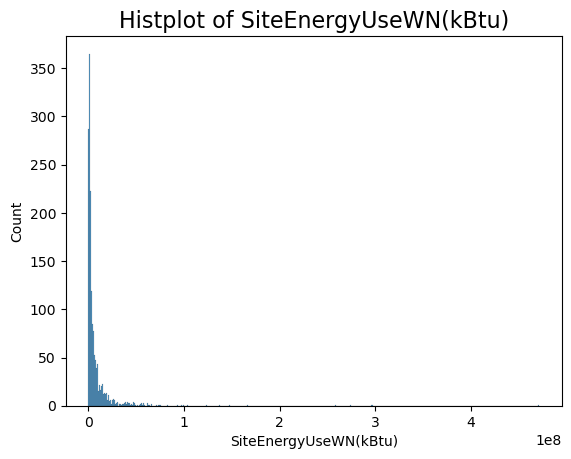

In [82]:
#plt.figure(figsize=(15,5))
sns.histplot(data=data, x='SiteEnergyUseWN(kBtu)')
plt.title('Histplot of SiteEnergyUseWN(kBtu)', fontsize=16)
plt.show()

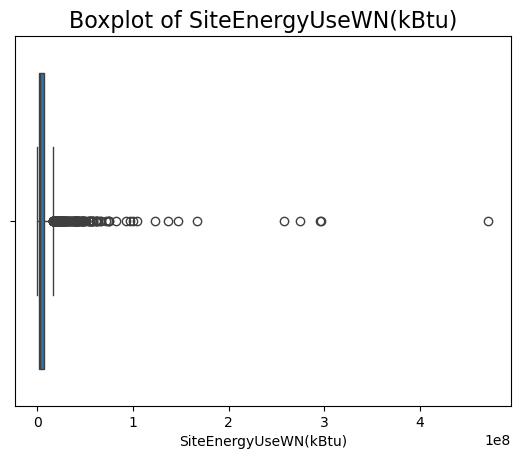

In [83]:
sns.boxplot(x=data['SiteEnergyUseWN(kBtu)'])
plt.title('Boxplot of SiteEnergyUseWN(kBtu)', fontsize=16)
plt.show()

On constate la présence de nombreux outliers qui viennent perturber la visualisation.

On peut aussi regarder la méthode basée sur l'IQR pour idnetifier les valeurs aberrantes. L'IQR est la différence entre le 25e centile (Q1) et le 75e centile (Q3) des données. Les valeurs :

inférieures à Q1 - 1,5 * IQR
ou supérieures à Q3 + 1,5 * IQR
sont considérées comme aberrantes.

In [85]:
# On calcule l'IQR (intervalle interquartile)
Q1 = data['SiteEnergyUseWN(kBtu)'].quantile(0.25)
Q3 = data['SiteEnergyUseWN(kBtu)'].quantile(0.75)
IQR = Q3 - Q1

# On calcule les limites
limite_basse = max(0, Q1 - 1.5 * IQR)
limite_haute = Q3 + 1.5 * IQR

print("limite basse :", limite_basse, "kBtu")
print("limite haute :", round(limite_haute,2), "kBtu")

limite basse : 0 kBtu
limite haute : 16262938.3 kBtu


Combien de propriétés sont au-dessus de la limite haute ?

In [87]:
mask = data['SiteEnergyUseWN(kBtu)'] > limite_haute
print("Nombre de propriétés au-dessus de la limite haute :", data.loc[mask].shape[0])

Nombre de propriétés au-dessus de la limite haute : 177


Quel est le "complianceStatus" de ces propriétés ?

In [89]:
data.loc[mask, 'ComplianceStatus'].value_counts()

ComplianceStatus
Compliant    177
Name: count, dtype: int64

On voit ici la faible utilité de la variable ComplianceStatus

Quelle est la distribution sans ces propriétés ?

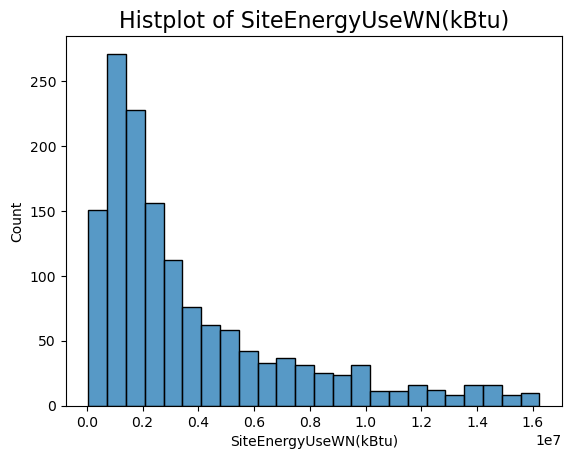

In [92]:
mask = data['SiteEnergyUseWN(kBtu)'] <= limite_haute
sample = data.loc[mask]
sns.histplot(data=sample, x='SiteEnergyUseWN(kBtu)')
plt.title('Histplot of SiteEnergyUseWN(kBtu)', fontsize=16)
plt.show()

On visualise une distribution unimodale asymétrique (étalement à droite).

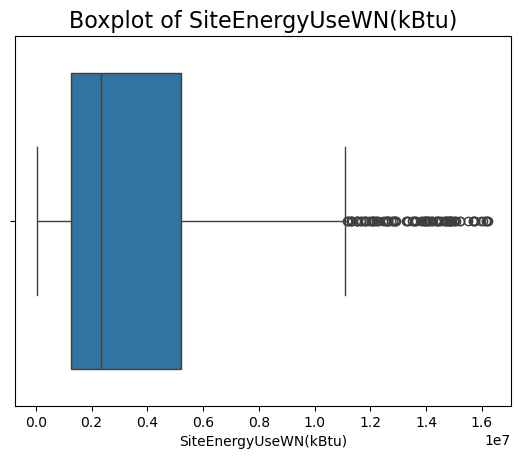

In [94]:
sns.boxplot(x=sample['SiteEnergyUseWN(kBtu)'])
plt.title('Boxplot of SiteEnergyUseWN(kBtu)', fontsize=16)
plt.show()

Est-ce que ces valeurs "aberrantes" ont un lien avec la surface du bâtiment ?

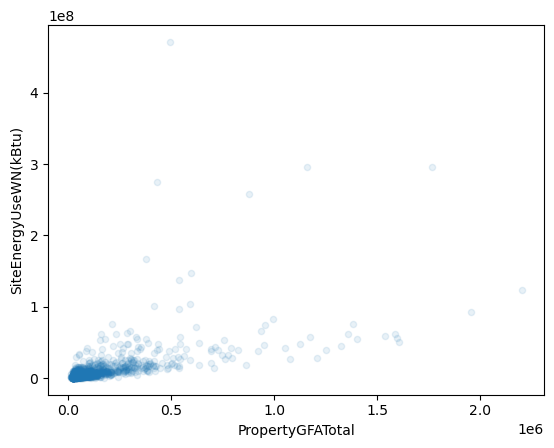

In [96]:
# Création du scatter plot
data.plot.scatter(x='PropertyGFATotal', y='SiteEnergyUseWN(kBtu)', alpha=0.1)

# Affichage du graphique
plt.show()

On voit ici que les valeurs de consommation au-dessus de 1,6e8 ne s'expliquent pas forcément par la superficie du bâtiment.

Je vais donc supprimer du dataset les valeurs au-dessus de la limite haute.

In [98]:
mask = data['SiteEnergyUseWN(kBtu)'] <= limite_haute
data = data.loc[mask]

In [99]:
data.shape

(1445, 46)

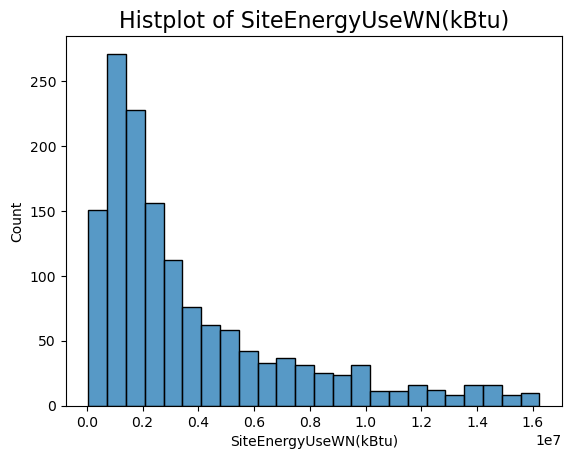

In [100]:
sns.histplot(data=sample, x='SiteEnergyUseWN(kBtu)')
plt.title('Histplot of SiteEnergyUseWN(kBtu)', fontsize=16)
plt.show()

**Traiter les données manquantes**

Identifier les valeurs NaN :

In [102]:
mask = data['SiteEnergyUseWN(kBtu)'].isna()
print("Nombre de propriétés dont la valeur est manquante :", data.loc[mask].shape[0])

Nombre de propriétés dont la valeur est manquante : 0


Identifier les valeurs nulles :

In [104]:
mask = data['SiteEnergyUseWN(kBtu)'] == 0
print("Nombre de propriétés dont la valeur est nulle :", data.loc[mask].shape[0])

Nombre de propriétés dont la valeur est nulle : 0


In [105]:
data[features_fe1].describe()

YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
count  1445.000000        1445.000000     1445.000000       1445.000000   
mean   1960.210381           1.022145        3.078201      69280.738408   
std      32.678129           0.435040        3.746112      70740.623113   
min    1900.000000           0.000000        0.000000      11285.000000   
25%    1929.000000           1.000000        1.000000      28072.000000   
50%    1963.000000           1.000000        2.000000      43661.000000   
75%    1987.000000           1.000000        4.000000      78374.000000   
max    2015.000000           6.000000       99.000000     706176.000000   

       Electricity(kBtu)  NaturalGas(kBtu)  SteamUse(kBtu)  \
count       1.445000e+03      1.445000e+03    1.445000e+03   
mean        2.492841e+06      1.018276e+06    9.451563e+04   
std         2.744288e+06      1.505151e+06    5.616864e+05   
min        -1.154170e+05      0.000000e+00    0.000000e+00   
25%         6.781670e+05      0.000000e+00    0.000000e+00   
50%         1.357120e+06      4.768320e+05    0.000000e+00   
75%         3.327045e+06      1.239357e+06    0.000000e+00   
max         1.587869e+07      1.150804e+07    8.630381e+06   

       SiteEnergyUseWN(kBtu)  TotalGHGEmissions  
count           1.445000e+03        1445.000000  
mean            3.767918e+06          78.754754  
std             3.595049e+06          95.616344  
min             5.811420e+04          -0.800000  
25%             1.259282e+06          18.620000  
50%             2.340056e+06          43.450000  
75%             5.205994e+06          95.860000  
max             1.622816e+07         712.390000

#### 6.4 - Nettoyer les données de la variable cible TotalGHGEmissions

**Traiter les valeurs aberrantes**

On voit qu'il y a des valeurs négatives, ce qui est aberrant ici.

On supprime les valeurs négatives :

In [108]:
mask = data['TotalGHGEmissions'] >= 0
print("Nombre de valeurs négatives :", data.shape[0] - data.loc[mask].shape[0])
data = data.loc[mask]

Nombre de valeurs négatives : 1


In [109]:
data.shape

(1444, 46)

In [110]:
data[features_fe1].describe()

YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
count  1444.000000        1444.000000     1444.000000       1444.000000   
mean   1960.173823           1.022161        3.076177      69292.705679   
std      32.659878           0.435190        3.746620      70763.667283   
min    1900.000000           0.000000        0.000000      11285.000000   
25%    1929.000000           1.000000        1.000000      28062.000000   
50%    1963.000000           1.000000        2.000000      43653.000000   
75%    1987.000000           1.000000        4.000000      78380.750000   
max    2015.000000           6.000000       99.000000     706176.000000   

       Electricity(kBtu)  NaturalGas(kBtu)  SteamUse(kBtu)  \
count       1.444000e+03      1.444000e+03    1.444000e+03   
mean        2.494647e+06      1.018981e+06    9.458109e+04   
std         2.744379e+06      1.505434e+06    5.618755e+05   
min         0.000000e+00      0.000000e+00    0.000000e+00   
25%         6.783500e+05      0.000000e+00    0.000000e+00   
50%         1.357482e+06      4.783005e+05    0.000000e+00   
75%         3.331490e+06      1.239401e+06    0.000000e+00   
max         1.587869e+07      1.150804e+07    8.630381e+06   

       SiteEnergyUseWN(kBtu)  TotalGHGEmissions  
count           1.444000e+03        1444.000000  
mean            3.770361e+06          78.809848  
std             3.595094e+06          95.626523  
min             5.811420e+04           0.400000  
25%             1.259692e+06          18.627500  
50%             2.343374e+06          43.540000  
75%             5.206862e+06          95.877500  
max             1.622816e+07         712.390000

Visualiser la distribution :

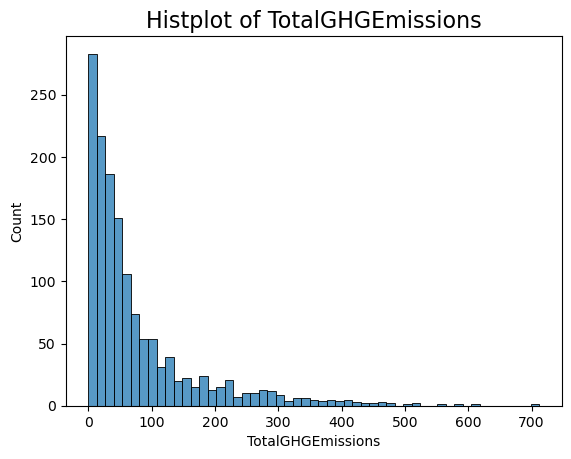

In [112]:
sns.histplot(data=data, x='TotalGHGEmissions')
plt.title('Histplot of TotalGHGEmissions', fontsize=16)
plt.show()

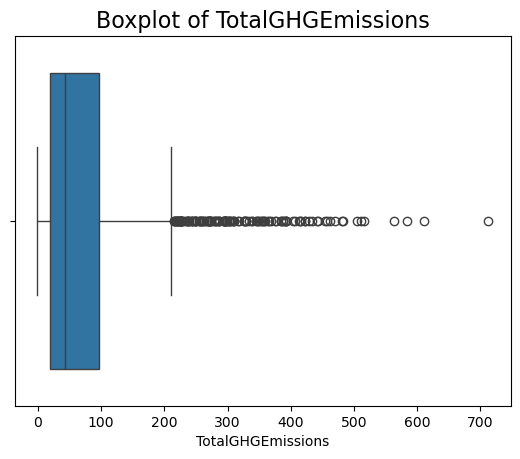

In [113]:
sns.boxplot(x=sample['TotalGHGEmissions'])
plt.title('Boxplot of TotalGHGEmissions', fontsize=16)
plt.show()

Visualiser le lien entre les émissions et la consommation d'energie :

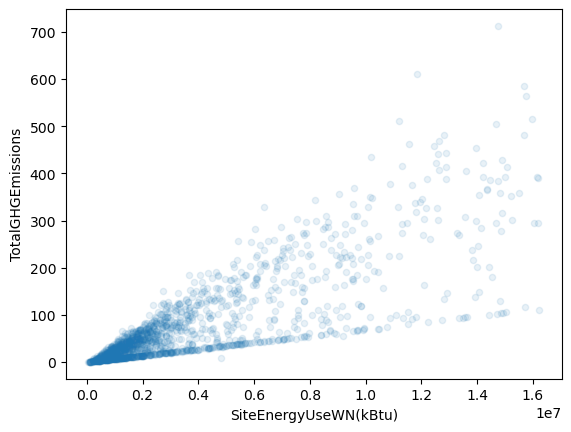

In [115]:
# Création du scatter plot
data.plot.scatter(x='SiteEnergyUseWN(kBtu)', y='TotalGHGEmissions', alpha=0.1)

# Affichage du graphique
plt.show()

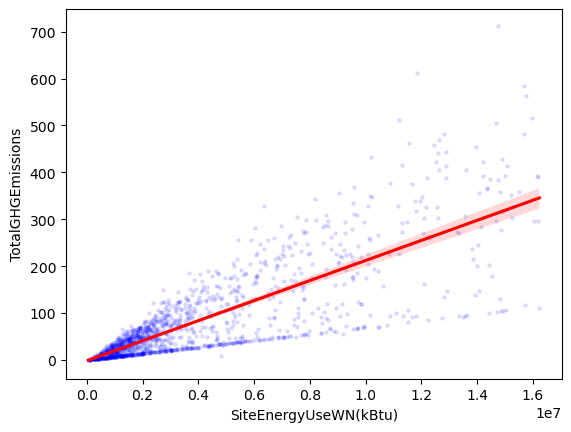

In [116]:
# Afficher le regplot
sns.regplot(x='SiteEnergyUseWN(kBtu)', y='TotalGHGEmissions', data=data, color='blue', marker='o', line_kws={'color': 'red'}, scatter_kws={'s': 5, 'alpha': 0.1})

# Afficher le graphique
plt.show()

Ce diagramme montre clairement une corrélation positive entre la consommation d'énergie sur le site (SiteEnergyUseWN) et les émissions de gaz à effet de serre totales (TotalGHGEmissions). Plus l'utilisation d'énergie est grande, plus les émissions de GES augmentent. Cependant, la dispersion indique que la relation n'est pas parfaitement linéaire et qu'il pourrait y avoir d'autres variables en jeu.

**Traiter les données manquantes**

Identifier les valeurs NaN :

In [119]:
mask = data['TotalGHGEmissions'].isna()
print("Nombre de propriétés dont la valeur est manquante :", data.loc[mask].shape[0])

Nombre de propriétés dont la valeur est manquante : 0


Identifier les valeurs nulles :

In [121]:
mask = data['TotalGHGEmissions'] == 0
print("Nombre de propriétés dont la valeur est nulle :", data.loc[mask].shape[0])

Nombre de propriétés dont la valeur est nulle : 0


Pas besoin de traiter les valeurs manquantes ou nulles car il n'y en a pas.

In [123]:
data[features_fe1].describe()

YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
count  1444.000000        1444.000000     1444.000000       1444.000000   
mean   1960.173823           1.022161        3.076177      69292.705679   
std      32.659878           0.435190        3.746620      70763.667283   
min    1900.000000           0.000000        0.000000      11285.000000   
25%    1929.000000           1.000000        1.000000      28062.000000   
50%    1963.000000           1.000000        2.000000      43653.000000   
75%    1987.000000           1.000000        4.000000      78380.750000   
max    2015.000000           6.000000       99.000000     706176.000000   

       Electricity(kBtu)  NaturalGas(kBtu)  SteamUse(kBtu)  \
count       1.444000e+03      1.444000e+03    1.444000e+03   
mean        2.494647e+06      1.018981e+06    9.458109e+04   
std         2.744379e+06      1.505434e+06    5.618755e+05   
min         0.000000e+00      0.000000e+00    0.000000e+00   
25%         6.783500e+05      0.000000e+00    0.000000e+00   
50%         1.357482e+06      4.783005e+05    0.000000e+00   
75%         3.331490e+06      1.239401e+06    0.000000e+00   
max         1.587869e+07      1.150804e+07    8.630381e+06   

       SiteEnergyUseWN(kBtu)  TotalGHGEmissions  
count           1.444000e+03        1444.000000  
mean            3.770361e+06          78.809848  
std             3.595094e+06          95.626523  
min             5.811420e+04           0.400000  
25%             1.259692e+06          18.627500  
50%             2.343374e+06          43.540000  
75%             5.206862e+06          95.877500  
max             1.622816e+07         712.390000

#### 6.5 - Nettoyer la feature YearBuilt

**Traiter les valeurs aberrantes**

Les années de construction s'étalent entre 1900 et 2015.

In [125]:
data['YearBuilt'].dtypes

dtype('int64')

Cette feature est de type entier. Il n'y a donc pas à priori de valeurs aberrantes.

Visualiser la distribution:

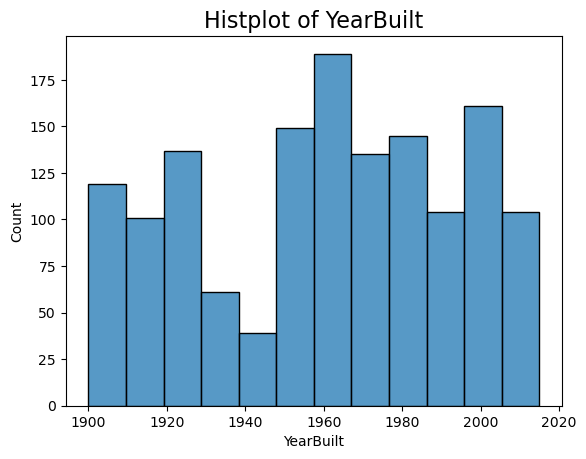

In [127]:
sns.histplot(data=data, x='YearBuilt')
plt.title('Histplot of YearBuilt', fontsize=16)
plt.show()

Visualiser les corrélations avec les cibles :

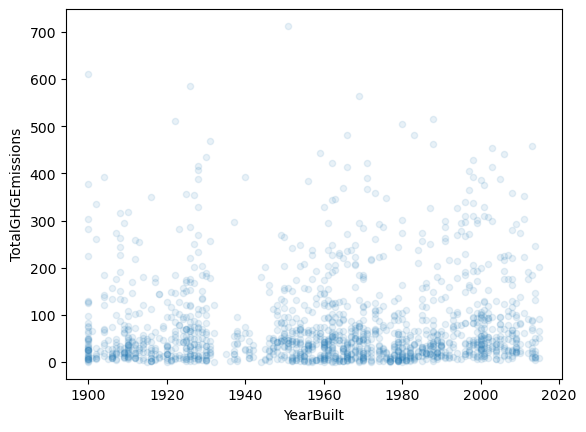

In [129]:
# Création du scatter plot
data.plot.scatter(x='YearBuilt', y='TotalGHGEmissions', alpha=0.1)

# Affichage du graphique
plt.show()

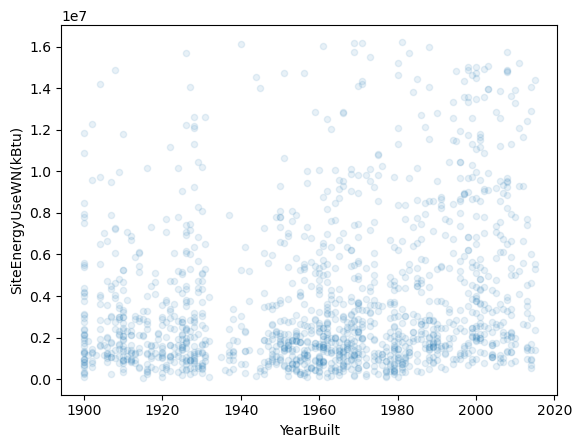

In [130]:
# Création du scatter plot
data.plot.scatter(x='YearBuilt', y='SiteEnergyUseWN(kBtu)', alpha=0.1)

# Affichage du graphique
plt.show()

**Traiter les valeurs manquantes**

Identifier les valeurs manquantes :

In [132]:
mask = data['YearBuilt'].isna()
print("Nombre de propriétés dont la valeur est manquante :", data.loc[mask].shape[0])

Nombre de propriétés dont la valeur est manquante : 0


Pas de données manquantes ici.

#### 6.6 - Nettoyer les données de la feature NumberofBuildings

**Traiter les valeurs aberrantes**

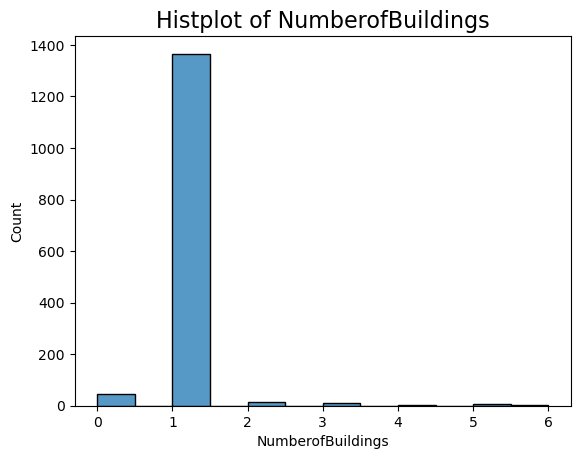

In [135]:
sns.histplot(data=data, x='NumberofBuildings')
plt.title('Histplot of NumberofBuildings', fontsize=16)
plt.show()

In [136]:
data['NumberofBuildings'].dtypes

dtype('float64')

Certaines valeurs ne sont pas des entiers, ce qui n'est pas normal. 

Rechercher les valeurs qui ne sont pas des entiers :

In [138]:
# Filtrer les valeurs qui ne sont pas des entiers
valeurs_non_entieres = data[~data['NumberofBuildings'].apply(lambda x: isinstance(x, int))]
print(valeurs_non_entieres['NumberofBuildings'])

0       1.0
1       1.0
3       1.0
4       1.0
5       1.0
       ... 
3371    1.0
3372    1.0
3373    1.0
3374    1.0
3375    1.0
Name: NumberofBuildings, Length: 1444, dtype: float64


In [139]:
data['NumberofBuildings'].unique()

array([1., 0., 2., 3., 6., 5., 4.])

Il n'y a que 0 qui est une valeur aberrante, car il devrait y avoir au moins un bâtiment. On va les transformer en NaN.

In [141]:
# remplacer dans le dataset
mask = data['NumberofBuildings'] == 0.
data.loc[mask, 'NumberofBuildings'] = np.nan

In [142]:
data['NumberofBuildings'].unique()

array([ 1., nan,  2.,  3.,  6.,  5.,  4.])

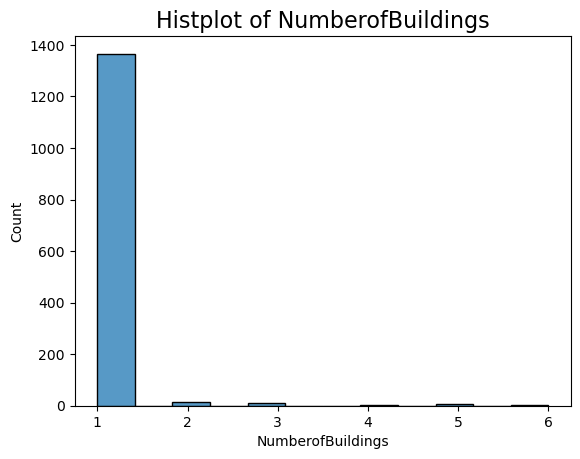

In [143]:
sns.histplot(data=data, x='NumberofBuildings')
plt.title('Histplot of NumberofBuildings', fontsize=16)
plt.show()

**Traiter les valeurs manquantes**

Nombre de valeurs manquantes :

In [145]:
mask = data['NumberofBuildings'].isna()
print("Nombre de valeurs manquantes :", data.loc[mask].shape[0])

Nombre de valeurs manquantes : 44


In [146]:
# Diagramme en secteurs
def build_pieplot(series, variable_label):
    plt.figure(figsize=(6, 6))
    plt.pie(series, 
            labels=series.index, 
            autopct='%1.1f%%',  # Affiche les pourcentages avec 1 décimale
            startangle=140,     # Angle de départ pour la première tranche
            wedgeprops=dict(edgecolor='black'))  # Couleur de la bordure des secteurs
    
    plt.title('Diagramme en secteurs de la variable ' + variable_label, fontsize=16)
    # Cette ligne assure que le pie chart est un cercle plutôt qu'une éllipse
    plt.axis('equal')
    # Personnaliser la taille des labels des secteurs
    plt.setp(plt.gca().texts, fontsize=12)  # Taille des étiquettes des secteurs
    plt.setp(plt.gca().patches, edgecolor='black')  # Couleur des bordures des secteurs
    
    plt.show()

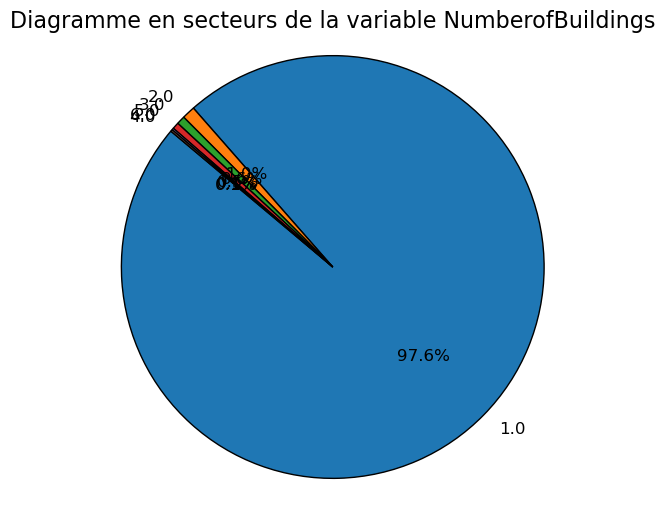

In [147]:
build_pieplot(data['NumberofBuildings'].value_counts(), 'NumberofBuildings')

Le nombre de bâtiment par propriété est 1 pour 97.6%. Je propose donc de remplacer les valeurs manquantes par 1 qui est la valeur majoritaire :

In [149]:
mask = data['NumberofBuildings'].isna()
data.loc[mask, 'NumberofBuildings'] = 1

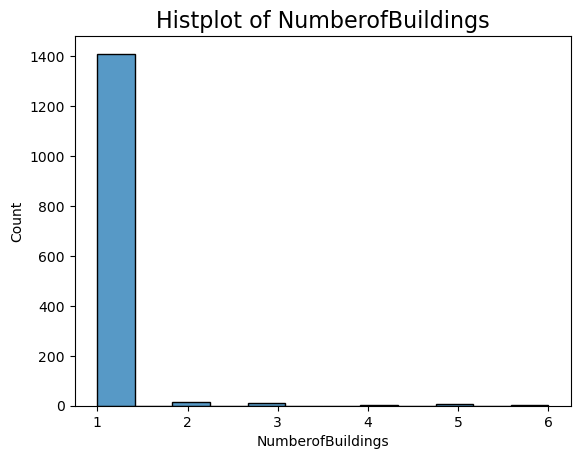

In [150]:
sns.histplot(data=data, x='NumberofBuildings')
plt.title('Histplot of NumberofBuildings', fontsize=16)
plt.show()

La distribution ne change pas beaucoup. Seule la 1er barre est un peu plus haute.

In [152]:
data[features_fe1].describe()

YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
count  1444.000000        1444.000000     1444.000000       1444.000000   
mean   1960.173823           1.052632        3.076177      69292.705679   
std      32.659878           0.395750        3.746620      70763.667283   
min    1900.000000           1.000000        0.000000      11285.000000   
25%    1929.000000           1.000000        1.000000      28062.000000   
50%    1963.000000           1.000000        2.000000      43653.000000   
75%    1987.000000           1.000000        4.000000      78380.750000   
max    2015.000000           6.000000       99.000000     706176.000000   

       Electricity(kBtu)  NaturalGas(kBtu)  SteamUse(kBtu)  \
count       1.444000e+03      1.444000e+03    1.444000e+03   
mean        2.494647e+06      1.018981e+06    9.458109e+04   
std         2.744379e+06      1.505434e+06    5.618755e+05   
min         0.000000e+00      0.000000e+00    0.000000e+00   
25%         6.783500e+05      0.000000e+00    0.000000e+00   
50%         1.357482e+06      4.783005e+05    0.000000e+00   
75%         3.331490e+06      1.239401e+06    0.000000e+00   
max         1.587869e+07      1.150804e+07    8.630381e+06   

       SiteEnergyUseWN(kBtu)  TotalGHGEmissions  
count           1.444000e+03        1444.000000  
mean            3.770361e+06          78.809848  
std             3.595094e+06          95.626523  
min             5.811420e+04           0.400000  
25%             1.259692e+06          18.627500  
50%             2.343374e+06          43.540000  
75%             5.206862e+06          95.877500  
max             1.622816e+07         712.390000

#### 6.7 - Nettoyer les données de la variable NumberofFloors

**Traiter le valeurs aberrantes:**

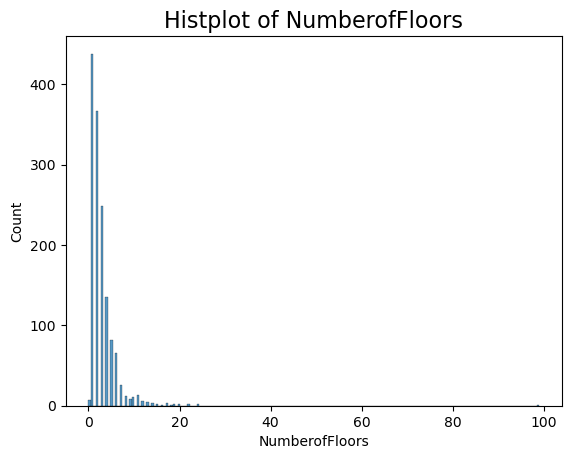

In [154]:
sns.histplot(data=data, x='NumberofFloors')
plt.title('Histplot of NumberofFloors', fontsize=16)
plt.show()

In [155]:
data['NumberofFloors'].dtypes

dtype('int64')

Il n'y a pas de valeurs aberrantes à priori. 0 n'est pas une valeur aberrante, car un bâtiment de plein pieds n'a pas d'étage.

**Traiter les valeurs manquantes:**

In [158]:
mask = data['NumberofFloors'].isna()
print("Nombre de valeurs manquantes :", data.loc[mask].shape[0])

Nombre de valeurs manquantes : 0


Il n'y pas de valeurs manquantes.

In [160]:
data[features_fe1].describe()

YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
count  1444.000000        1444.000000     1444.000000       1444.000000   
mean   1960.173823           1.052632        3.076177      69292.705679   
std      32.659878           0.395750        3.746620      70763.667283   
min    1900.000000           1.000000        0.000000      11285.000000   
25%    1929.000000           1.000000        1.000000      28062.000000   
50%    1963.000000           1.000000        2.000000      43653.000000   
75%    1987.000000           1.000000        4.000000      78380.750000   
max    2015.000000           6.000000       99.000000     706176.000000   

       Electricity(kBtu)  NaturalGas(kBtu)  SteamUse(kBtu)  \
count       1.444000e+03      1.444000e+03    1.444000e+03   
mean        2.494647e+06      1.018981e+06    9.458109e+04   
std         2.744379e+06      1.505434e+06    5.618755e+05   
min         0.000000e+00      0.000000e+00    0.000000e+00   
25%         6.783500e+05      0.000000e+00    0.000000e+00   
50%         1.357482e+06      4.783005e+05    0.000000e+00   
75%         3.331490e+06      1.239401e+06    0.000000e+00   
max         1.587869e+07      1.150804e+07    8.630381e+06   

       SiteEnergyUseWN(kBtu)  TotalGHGEmissions  
count           1.444000e+03        1444.000000  
mean            3.770361e+06          78.809848  
std             3.595094e+06          95.626523  
min             5.811420e+04           0.400000  
25%             1.259692e+06          18.627500  
50%             2.343374e+06          43.540000  
75%             5.206862e+06          95.877500  
max             1.622816e+07         712.390000

#### 6.8 - Nettoyer les données de la feature PropertyGFATotal

**Traiter les valeurs aberrantes:**

Visualiser la distribution:

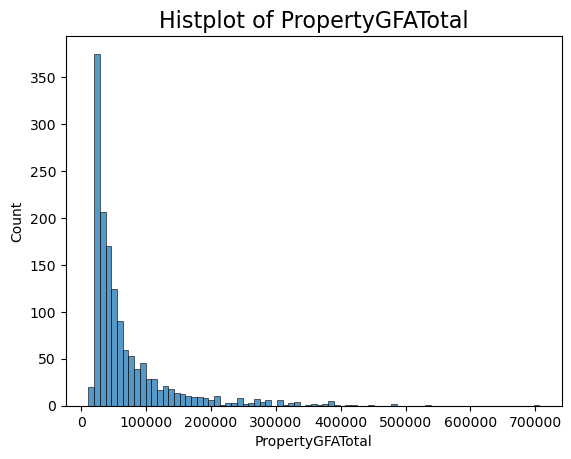

In [162]:
sns.histplot(data=data, x='PropertyGFATotal')
plt.title('Histplot of PropertyGFATotal', fontsize=16)
plt.show()

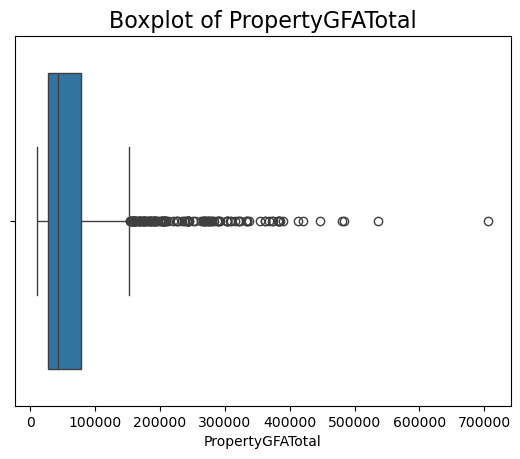

In [163]:
sns.boxplot(x=sample['PropertyGFATotal'])
plt.title('Boxplot of PropertyGFATotal', fontsize=16)
plt.show()

Rechercher les outliers par la méthode de l'IQR:

In [165]:
# On calcule l'IQR (intervalle interquartile)
Q1 = data['PropertyGFATotal'].quantile(0.25)
Q3 = data['PropertyGFATotal'].quantile(0.75)
IQR = Q3 - Q1

# On calcule les limites
limite_basse = max(0, Q1 - 1.5 * IQR)
limite_haute = Q3 + 1.5 * IQR

print("limite basse :", limite_basse, "pieds carrés")
print("limite haute :", round(limite_haute,2), "pieds carrés")

limite basse : 0 pieds carrés
limite haute : 153858.88 pieds carrés


Combien de propriétés sont au-dessus de la limite haute :

In [167]:
mask = data['PropertyGFATotal'] > limite_haute
print("Nombre de propriétés au-dessus de la limite haute :", data.loc[mask].shape[0])

Nombre de propriétés au-dessus de la limite haute : 134


Font-ils partis des erreurs dans le complianceStatus ?

In [169]:
mask = (data['PropertyGFATotal'] > limite_haute) & (data['ComplianceStatus'] == 'Error - Correct Default Data')
print("Nombre de propriétés au-dessus de la limite haute et en erreur sur le complianceStatus:", data.loc[mask].shape[0])

Nombre de propriétés au-dessus de la limite haute et en erreur sur le complianceStatus: 11


On peut essayer de voir s'il y a une variable corrélée qui pourrait justifier les valeurs au-dessus de la limite haute.

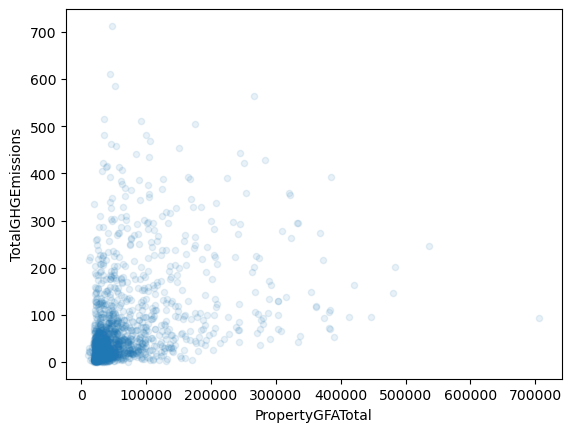

In [171]:
# Création du scatter plot
data.plot.scatter(x='PropertyGFATotal', y='TotalGHGEmissions', alpha=0.1)

# Affichage du graphique
plt.show()

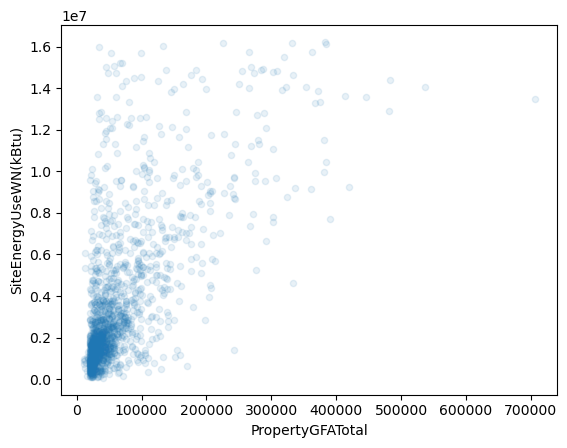

In [172]:
# Création du scatter plot
data.plot.scatter(x='PropertyGFATotal', y='SiteEnergyUseWN(kBtu)', alpha=0.1)

# Affichage du graphique
plt.show()

D'après ChatGPT, Un immeuble de bureaux de 700 000 pieds carrés correspondrait à un gratte-ciel ou à un immeuble de grande hauteur, typique des centres-villes ou des quartiers d'affaires majeurs.

Il est donc difficile de considérer les valeurs au-dessus de la limite haute comme aberrante.

Quel est le nombre d'étages du 700 000 ?

In [174]:
mask = data['PropertyGFATotal'] > 700000
print("Nombre d'étages des propriétés au-dessus de 700 000 :", data.loc[mask, 'NumberofFloors'].values)

Nombre d'étages des propriétés au-dessus de 700 000 : [6]


6 Etages c'est peu. Le bâtiment avec 700 000 de PropertyGFATotal est donc aberrant.

On le transforme en NaN.

In [176]:
# remplacer dans le dataset
mask = data['PropertyGFATotal'] > 700000.
data.loc[mask, 'PropertyGFATotal'] = np.nan

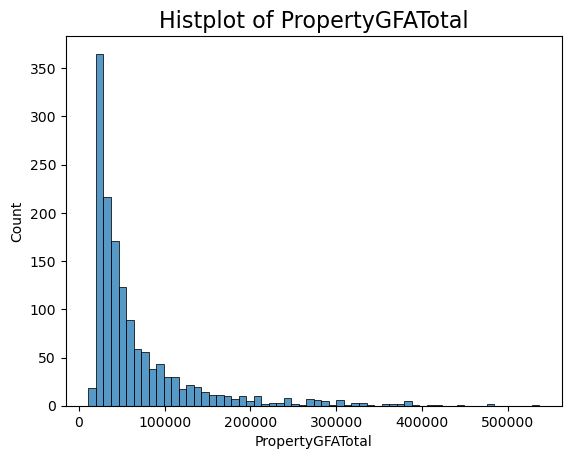

In [177]:
sns.histplot(data=data, x='PropertyGFATotal')
plt.title('Histplot of PropertyGFATotal', fontsize=16)
plt.show()

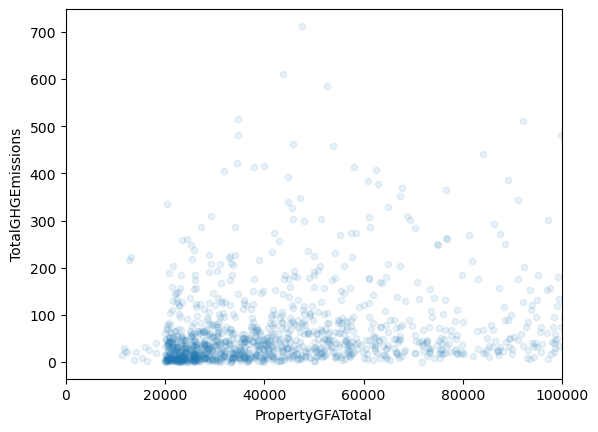

In [178]:
# Création du scatter plot
data.plot.scatter(x='PropertyGFATotal', y='TotalGHGEmissions', alpha=0.1)

# Définir les limites de l'axe x
plt.xlim(0, 100000)

# Affichage du graphique
plt.show()

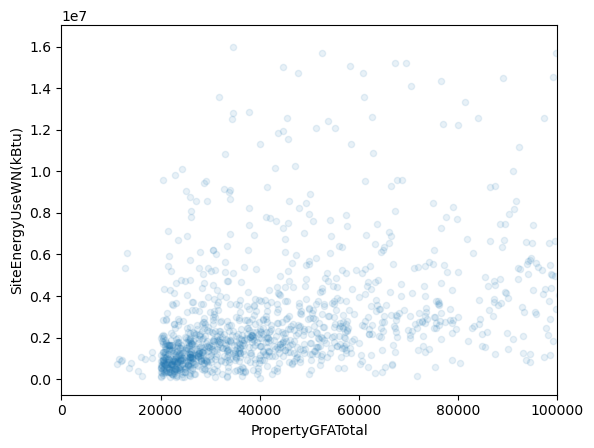

In [179]:
# Création du scatter plot
data.plot.scatter(x='PropertyGFATotal', y='SiteEnergyUseWN(kBtu)', alpha=0.1)

# Définir les limites de l'axe x
plt.xlim(0, 100000)

# Affichage du graphique
plt.show()

**Traiter les valeurs manquantes:**

Identifier les valeurs manquantes :

In [181]:
mask = data['PropertyGFATotal'].isna()
print("Nombre de valeurs manquantes :", data.loc[mask].shape[0])

Nombre de valeurs manquantes : 1


Il y a une valeur NaN. Quelles sont les caractéristiques de cette propriété ?

In [183]:
print(data.loc[mask])

      OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
2835          27145      2016  NonResidential        Large Office   

                        PropertyName      Address     City State  ZipCode  \
2835  719 2nd Ave (Millennium Tower)  719 2nd Ave  Seattle    WA  98104.0   

     TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  \
2835                    5530510000                    7     DOWNTOWN   

      Latitude  Longitude  YearBuilt  NumberofBuildings  NumberofFloors  \
2835  47.60331 -122.33389       2000                1.0               6   

      PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
2835               NaN                   0                  706176   

         ListOfAllPropertyUseTypes LargestPropertyUseType  \
2835  Bank Branch, Office, Parking                 Office   

      LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
2835                   222807.0                      Parking   

      SecondLarge

Elle a 1 bâtiment et 6 étages. Quelle est la distribution de cette catégorie ?

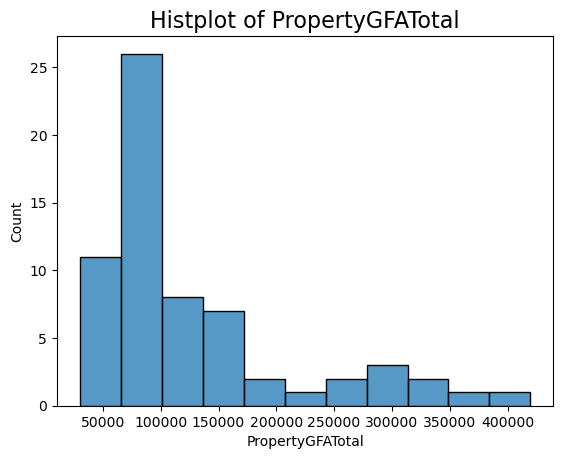

In [185]:
mask = (data['NumberofFloors'] == 6) & (data['NumberofBuildings'] == 1.0)
sns.histplot(data=data.loc[mask], x='PropertyGFATotal')
plt.title('Histplot of PropertyGFATotal', fontsize=16)
plt.show()

Comme la distribution est asymétrique, je propose de remplacer le Nan par la médiane de cette catégorie.

In [187]:
# Calculer la médiane
mask = (data['NumberofFloors'] == 6) & (data['NumberofBuildings'] == 1.0)
median = data.loc[mask, 'PropertyGFATotal'].median()
print("mediane = ", str(median))

mediane =  95740.5


In [188]:
mask = data['PropertyGFATotal'].isna()
data.loc[mask, 'PropertyGFATotal'] = median

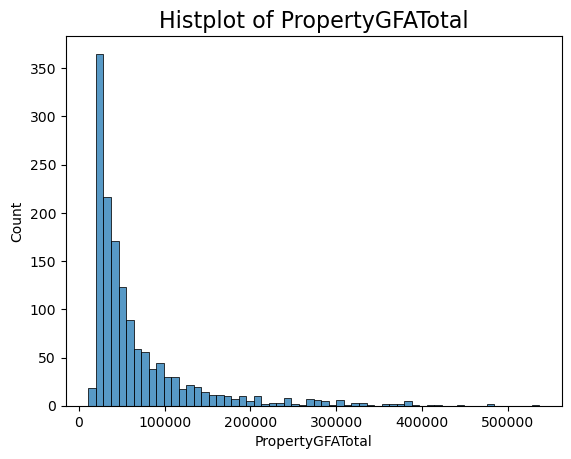

In [189]:
sns.histplot(data=data, x='PropertyGFATotal')
plt.title('Histplot of PropertyGFATotal', fontsize=16)
plt.show()

Identifier les valeurs nulles :

In [191]:
mask = data['PropertyGFATotal'] == 0
print("Nombre de valeurs nulles :", data.loc[mask].shape[0])

Nombre de valeurs nulles : 0


Il n'y a pas de valeurs nulles.

In [193]:
data[features_fe1].describe()

YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
count  1444.000000        1444.000000     1444.000000       1444.000000   
mean   1960.173823           1.052632        3.076177      68869.966413   
std      32.659878           0.395750        3.746620      68751.053439   
min    1900.000000           1.000000        0.000000      11285.000000   
25%    1929.000000           1.000000        1.000000      28062.000000   
50%    1963.000000           1.000000        2.000000      43653.000000   
75%    1987.000000           1.000000        4.000000      78380.750000   
max    2015.000000           6.000000       99.000000     536697.000000   

       Electricity(kBtu)  NaturalGas(kBtu)  SteamUse(kBtu)  \
count       1.444000e+03      1.444000e+03    1.444000e+03   
mean        2.494647e+06      1.018981e+06    9.458109e+04   
std         2.744379e+06      1.505434e+06    5.618755e+05   
min         0.000000e+00      0.000000e+00    0.000000e+00   
25%         6.783500e+05      0.000000e+00    0.000000e+00   
50%         1.357482e+06      4.783005e+05    0.000000e+00   
75%         3.331490e+06      1.239401e+06    0.000000e+00   
max         1.587869e+07      1.150804e+07    8.630381e+06   

       SiteEnergyUseWN(kBtu)  TotalGHGEmissions  
count           1.444000e+03        1444.000000  
mean            3.770361e+06          78.809848  
std             3.595094e+06          95.626523  
min             5.811420e+04           0.400000  
25%             1.259692e+06          18.627500  
50%             2.343374e+06          43.540000  
75%             5.206862e+06          95.877500  
max             1.622816e+07         712.390000

#### 6.9 - Nettoyer les données de la feature Electricity(kBtu)

**Traiter les valeurs aberrantes**

Visualiser la distribution :

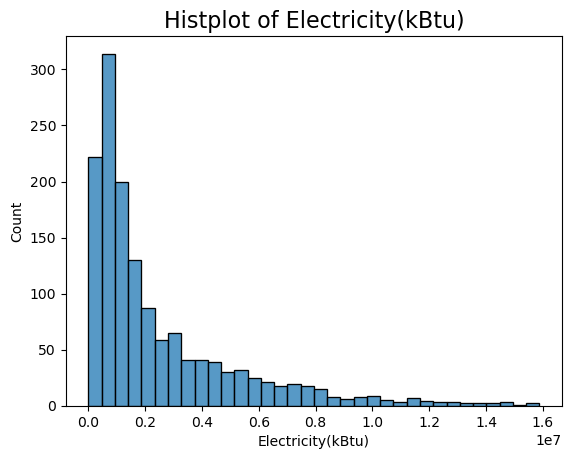

In [195]:
sns.histplot(data=data, x='Electricity(kBtu)')
plt.title('Histplot of Electricity(kBtu)', fontsize=16)
plt.show()

Distribution unimodale, asymétrique, avec étalement à droite. 

D'après ChatGPT :
- Les immeubles de bureaux consomment souvent entre 1 et 10 millions de kBtu par an, selon leur taille et leur utilisation.
- Des bâtiments très énergivores (comme les centres commerciaux, les hôpitaux, ou les data centers) peuvent atteindre 10 à 50 millions de kBtu par an, voire plus.

Tous les bâtiments doivent avoir une consommation électrique non nulle, car ils consomment nécessairement de l'electricité, ne serait-ce que pour l'éclairage. Combien de propriété consomme 0 kBtu d'électricité :

In [197]:
mask = data['Electricity(kBtu)'] == 0
print("Nombre de propriétés avec 0 kBtu de consommation électrique :", data.loc[mask].shape[0])

Nombre de propriétés avec 0 kBtu de consommation électrique : 1


In [198]:
print(data.loc[mask])

     OSEBuildingID  DataYear    BuildingType PrimaryPropertyType PropertyName  \
426          23854      2016  NonResidential          Restaurant      Pier 57   

              Address     City State  ZipCode TaxParcelIdentificationNumber  \
426  1301 Alaskan Way  Seattle    WA  98101.0                    7666202435   

     CouncilDistrictCode Neighborhood  Latitude  Longitude  YearBuilt  \
426                    7     DOWNTOWN  47.60613 -122.34115       1900   

     NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
426                1.0               1           43728.0                   0   

     PropertyGFABuilding(s) ListOfAllPropertyUseTypes LargestPropertyUseType  \
426                   43728                Restaurant             Restaurant   

     LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
426                    43728.0                          NaN   

     SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
426           

On transforme les valeurs 0 en NaN :

In [200]:
# remplacer dans le dataset
mask = data['Electricity(kBtu)'] == 0
data.loc[mask, 'Electricity(kBtu)'] = np.nan

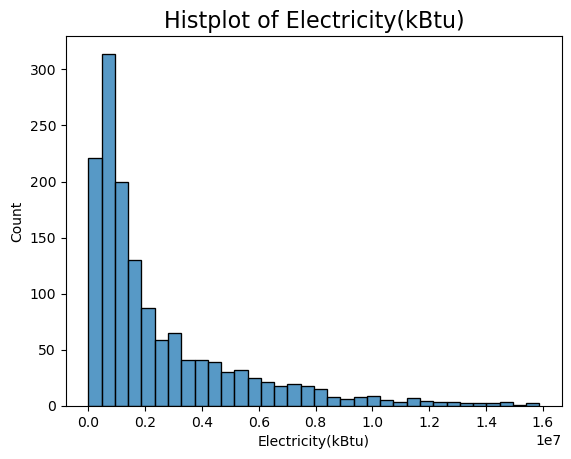

In [201]:
sns.histplot(data=data, x='Electricity(kBtu)')
plt.title('Histplot of Electricity(kBtu)', fontsize=16)
plt.show()

Visualiser les corréaltions éventuelles avec les cibles :

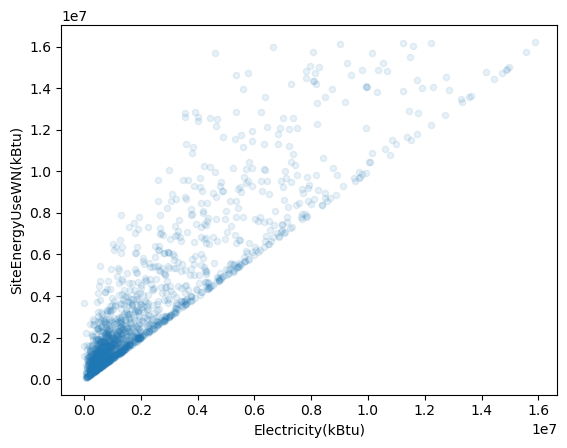

In [203]:
# Création du scatter plot
data.plot.scatter(x='Electricity(kBtu)', y='SiteEnergyUseWN(kBtu)', alpha=0.1)

# Définir les limites de l'axe x
#plt.xlim(0, 100000)

# Affichage du graphique
plt.show()

Il n'y a pas de points sous la diagonale dans ce graphique car la consommation totale d'énergie d'un site (Site Energy Use WN), représentée sur l'axe 𝑦, inclut nécessairement la consommation d'électricité (Electricity), représentée sur l'axe 𝑥.

On observe une tendance linéaire claire où la consommation totale d’énergie du site augmente avec la consommation d’électricité (corrélation positive).
Cela indique que l’électricité constitue probablement une part importante de la consommation énergétique totale. Les deux variables sont fortement liées.

Les points proches de la diagonale suggèrent que, l’électricité représente une proportion majeure de la consommation énergétique totale (peut-être 100 %, ou presque).

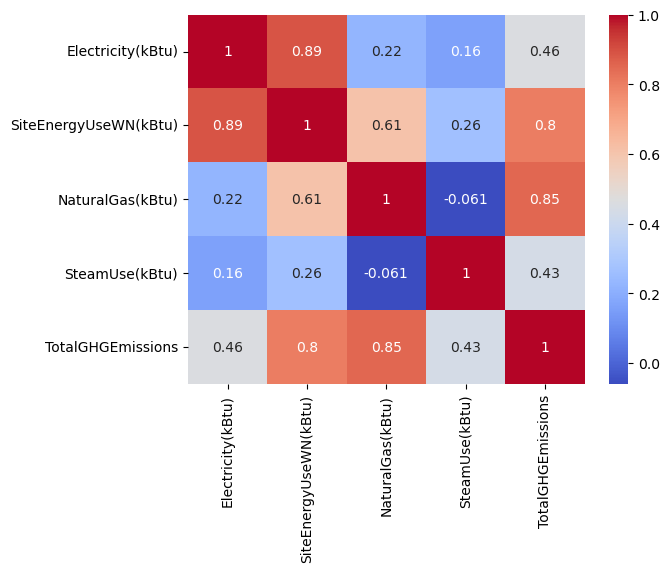

In [205]:
correlation_matrix = data[['Electricity(kBtu)', 'SiteEnergyUseWN(kBtu)', 'NaturalGas(kBtu)', 'SteamUse(kBtu)', 'TotalGHGEmissions']].corr()

# Créer une heatmap pour la matrice de corrélation
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Afficher la heatmap
plt.show()

L'observation est confirmée par le calcul du coefficient de corrélation entre la consommation électrique et la consommation totale.

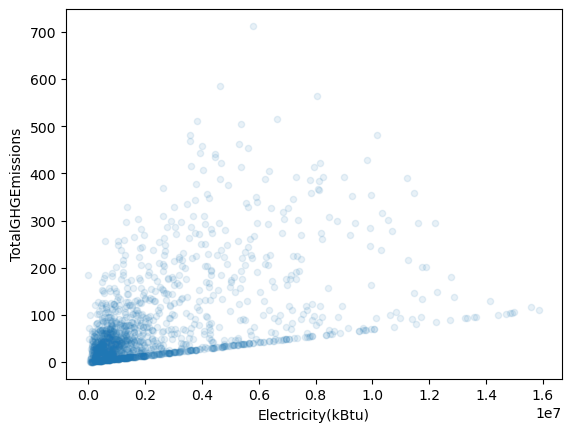

In [207]:
# Création du scatter plot
data.plot.scatter(x='Electricity(kBtu)', y='TotalGHGEmissions', alpha=0.1)

# Définir les limites de l'axe x
#plt.xlim(0, 100000)

# Affichage du graphique
plt.show()

**Traiter les valeurs manquantes**

In [209]:
mask = data['Electricity(kBtu)'].isna()
print("Nombre de valeurs manquantes :", data.loc[mask].shape[0])

Nombre de valeurs manquantes : 1


Quel est le type de propriété ?

In [211]:
print("Type de propriété :", data.loc[mask, 'PrimaryPropertyType'])

Type de propriété : 426    Restaurant
Name: PrimaryPropertyType, dtype: object


Visualiser la distribution des propriétés de type "Restaurant"

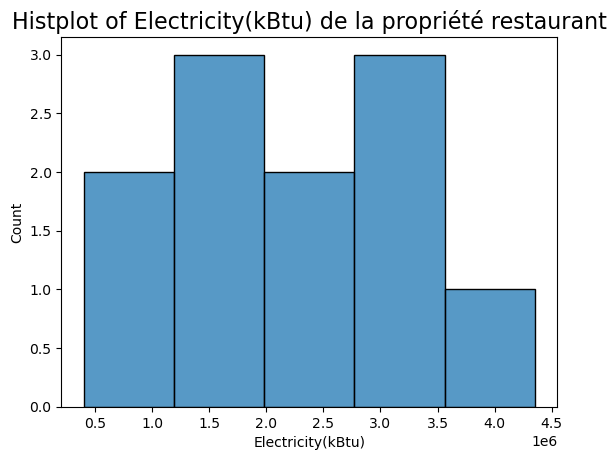

In [213]:
mask = data['PrimaryPropertyType'] == 'Restaurant'
sns.histplot(data= data.loc[mask], x='Electricity(kBtu)')
plt.title('Histplot of Electricity(kBtu) de la propriété restaurant', fontsize=16)
plt.show()

Je propose de remplacer le NaN par la moyenne :

In [215]:
# Calculer la moyenne des restaurants
mask = data['PrimaryPropertyType'] == 'Restaurant'
mean = data.loc[mask, 'Electricity(kBtu)'].mean()
print("moyenne = ", str(mean))

moyenne =  2177533.4545454546


In [216]:
mask = data['Electricity(kBtu)'].isna()
data.loc[mask, 'Electricity(kBtu)'] = mean

In [217]:
mask = data['Electricity(kBtu)'].isna()
print(data.loc[mask].shape[0])

0


In [218]:
data[features_fe1].describe()

YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
count  1444.000000        1444.000000     1444.000000       1444.000000   
mean   1960.173823           1.052632        3.076177      68869.966413   
std      32.659878           0.395750        3.746620      68751.053439   
min    1900.000000           1.000000        0.000000      11285.000000   
25%    1929.000000           1.000000        1.000000      28062.000000   
50%    1963.000000           1.000000        2.000000      43653.000000   
75%    1987.000000           1.000000        4.000000      78380.750000   
max    2015.000000           6.000000       99.000000     536697.000000   

       Electricity(kBtu)  NaturalGas(kBtu)  SteamUse(kBtu)  \
count       1.444000e+03      1.444000e+03    1.444000e+03   
mean        2.496155e+06      1.018981e+06    9.458109e+04   
std         2.743606e+06      1.505434e+06    5.618755e+05   
min         3.000000e+00      0.000000e+00    0.000000e+00   
25%         6.785962e+05      0.000000e+00    0.000000e+00   
50%         1.358182e+06      4.783005e+05    0.000000e+00   
75%         3.331490e+06      1.239401e+06    0.000000e+00   
max         1.587869e+07      1.150804e+07    8.630381e+06   

       SiteEnergyUseWN(kBtu)  TotalGHGEmissions  
count           1.444000e+03        1444.000000  
mean            3.770361e+06          78.809848  
std             3.595094e+06          95.626523  
min             5.811420e+04           0.400000  
25%             1.259692e+06          18.627500  
50%             2.343374e+06          43.540000  
75%             5.206862e+06          95.877500  
max             1.622816e+07         712.390000

#### 6.10 - Nettoyer les données de la feature NaturalGas(kBtu)

**Traiter les valeurs aberrantes**

Visualiser la distribution :

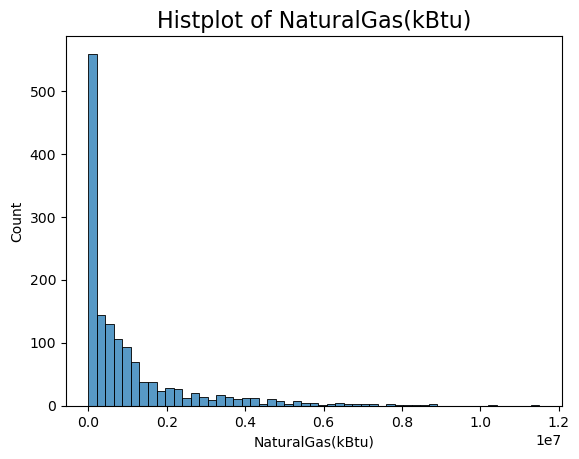

In [220]:
sns.histplot(data=data, x='NaturalGas(kBtu)')
plt.title('Histplot of NaturalGas(kBtu)', fontsize=16)
plt.show()

La distribution est unimodale, asymétrique, avec étalement à droite. Le nombre important de valeurs nulles s'explique par le fait que beaucoup de bâtiments ne sont pas nécessairement ratacchés au gaz.

D'après ChatGPT : 
"
Je ne dispose pas de chiffres précis et récents pour cette question spécifique, mais des rapports de la ville de Seattle indiquent souvent des tendances générales :

- Seattle est connue pour son engagement envers les énergies renouvelables et la réduction des combustibles fossiles.
- Une proportion significative des bâtiments utilise l'électricité, notamment grâce à la production hydroélectrique qui domine l'approvisionnement en électricité de Seattle.
- La ville a des objectifs ambitieux de réduction des émissions de carbone, ce qui a incité certains bâtiments à abandonner le gaz naturel pour passer à des sources d'énergie plus propres, notamment l'électricité.
"

Les valeurs nulles ne peuvent donc pas être considérées comme aberrantes.

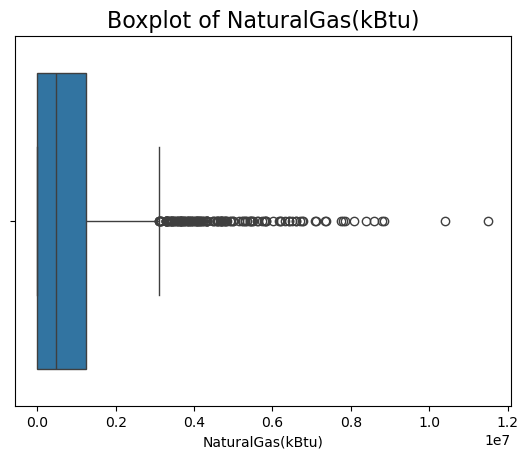

In [222]:
sns.boxplot(x=sample['NaturalGas(kBtu)'])
plt.title('Boxplot of NaturalGas(kBtu)', fontsize=16)
plt.show()

Quelles sont les types de propriétés des bâtiments de plus de 0,8 * 1e7 kBtu ?

In [224]:
mask = data['NaturalGas(kBtu)'] > 0.8 * 1e7
print("Nombre de bâtiments concernés :", data.loc[mask].shape[0])

print("Liste des types de propriétés correspondantes :", data.loc[mask, 'PrimaryPropertyType'].unique())

Nombre de bâtiments concernés : 7
Liste des types de propriétés correspondantes : ['Hotel' 'Mixed Use Property' 'Restaurant' 'Senior Care Community' 'Other']


Rechercher les outliers par la méthode inter quartile IQR :

In [226]:
# On calcule l'IQR (intervalle interquartile)
Q1 = data['NaturalGas(kBtu)'].quantile(0.25)
Q3 = data['NaturalGas(kBtu)'].quantile(0.75)
IQR = Q3 - Q1

# On calcule les limites
limite_basse = max(0, Q1 - 1.5 * IQR)
limite_haute = Q3 + 1.5 * IQR

print("limite basse :", limite_basse, "kBtu")
print("limite haute :", round(limite_haute,2), "kBtu")

limite basse : 0 kBtu
limite haute : 3098502.5 kBtu


In [227]:
mask = data['NaturalGas(kBtu)'] > limite_haute
print("Nombre de bâtiments au-dessus la limite haute :", data.loc[mask].shape[0])

Nombre de bâtiments au-dessus la limite haute : 140


In [228]:
print("Liste des types de propriétés correspondantes :", data.loc[mask, 'PrimaryPropertyType'].unique())

Liste des types de propriétés correspondantes : ['Hotel' 'Other' 'University' 'K-12 School' 'Mixed Use Property'
 'Warehouse' 'Retail Store' 'Large Office' 'Supermarket / Grocery Store'
 'Laboratory' 'Distribution Center' 'Small- and Mid-Sized Office'
 'Restaurant' 'Medical Office' 'Senior Care Community' 'Worship Facility']


Je ne pense que l'IQR soit pertinent ici, car la consommation de gaz différe beaucoup selon l'utilisation de la propriété. Par exemple la forte consommation de gaz n'est pas aberrante pour les grands hôtels, et pour les restaurants.

Je ne considère donc pas ces valeurs comme aberrantes. En effet il faudrait étudier chaque propriété, une à une, ce qui prendrait trop de temps, ne serait pas forcément pertinent pour un 1er feature engineering.

**Traiter les valeurs manquantes**

In [231]:
mask = data['NaturalGas(kBtu)'].isna()
print("Nombre de valeurs manquantes :", data.loc[mask].shape[0])

Nombre de valeurs manquantes : 0


Il n'y a pas de valeurs manquantes ici.

In [233]:
data[features_fe1].describe()

YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
count  1444.000000        1444.000000     1444.000000       1444.000000   
mean   1960.173823           1.052632        3.076177      68869.966413   
std      32.659878           0.395750        3.746620      68751.053439   
min    1900.000000           1.000000        0.000000      11285.000000   
25%    1929.000000           1.000000        1.000000      28062.000000   
50%    1963.000000           1.000000        2.000000      43653.000000   
75%    1987.000000           1.000000        4.000000      78380.750000   
max    2015.000000           6.000000       99.000000     536697.000000   

       Electricity(kBtu)  NaturalGas(kBtu)  SteamUse(kBtu)  \
count       1.444000e+03      1.444000e+03    1.444000e+03   
mean        2.496155e+06      1.018981e+06    9.458109e+04   
std         2.743606e+06      1.505434e+06    5.618755e+05   
min         3.000000e+00      0.000000e+00    0.000000e+00   
25%         6.785962e+05      0.000000e+00    0.000000e+00   
50%         1.358182e+06      4.783005e+05    0.000000e+00   
75%         3.331490e+06      1.239401e+06    0.000000e+00   
max         1.587869e+07      1.150804e+07    8.630381e+06   

       SiteEnergyUseWN(kBtu)  TotalGHGEmissions  
count           1.444000e+03        1444.000000  
mean            3.770361e+06          78.809848  
std             3.595094e+06          95.626523  
min             5.811420e+04           0.400000  
25%             1.259692e+06          18.627500  
50%             2.343374e+06          43.540000  
75%             5.206862e+06          95.877500  
max             1.622816e+07         712.390000

#### 6.11 - Nettoyer les données de la feature SteamUse(kBtu)

**Traiter les valeurs aberrantes**

Visualiser la distribution :

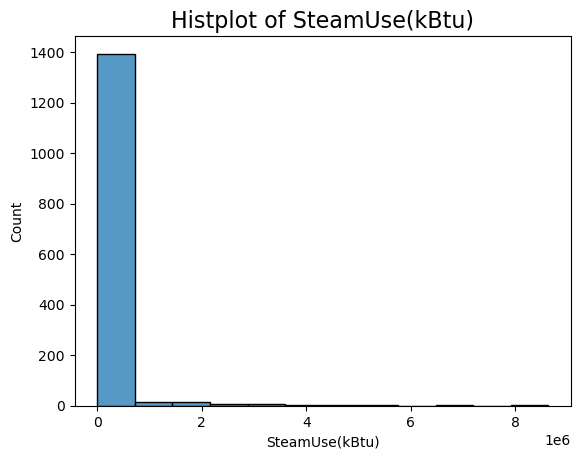

In [235]:
sns.histplot(data=data, x='SteamUse(kBtu)')
plt.title('Histplot of SteamUse(kBtu)', fontsize=16)
plt.show()

La distribution est unimodale, asymétrique. Le pic à 0 s'explique par une faible utilisation de la vapeur comme source d'énergie.

D'après ChatGPT, une consommation de 8 millions de kBtu ne serait pas aberrante. D'où dépend de l'usage du bâtiment. Je ne considère donc pas les valeurs élevées comme aberrantes à ce stade du projet. En effet il faudrait étudier chaque propriété, une à une, ce qui prendrait trop de temps, ne serait pas forcément pertinent pour un 1er feature engineering.

**Traiter les valeurs manquantes**

In [238]:
mask = data['SteamUse(kBtu)'].isna()
print("Nombre de valeurs manquantes :", data.loc[mask].shape[0])

Nombre de valeurs manquantes : 0


Il n'y a pas de valeurs manquantes.

In [240]:
data[features_fe1].describe()

YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
count  1444.000000        1444.000000     1444.000000       1444.000000   
mean   1960.173823           1.052632        3.076177      68869.966413   
std      32.659878           0.395750        3.746620      68751.053439   
min    1900.000000           1.000000        0.000000      11285.000000   
25%    1929.000000           1.000000        1.000000      28062.000000   
50%    1963.000000           1.000000        2.000000      43653.000000   
75%    1987.000000           1.000000        4.000000      78380.750000   
max    2015.000000           6.000000       99.000000     536697.000000   

       Electricity(kBtu)  NaturalGas(kBtu)  SteamUse(kBtu)  \
count       1.444000e+03      1.444000e+03    1.444000e+03   
mean        2.496155e+06      1.018981e+06    9.458109e+04   
std         2.743606e+06      1.505434e+06    5.618755e+05   
min         3.000000e+00      0.000000e+00    0.000000e+00   
25%         6.785962e+05      0.000000e+00    0.000000e+00   
50%         1.358182e+06      4.783005e+05    0.000000e+00   
75%         3.331490e+06      1.239401e+06    0.000000e+00   
max         1.587869e+07      1.150804e+07    8.630381e+06   

       SiteEnergyUseWN(kBtu)  TotalGHGEmissions  
count           1.444000e+03        1444.000000  
mean            3.770361e+06          78.809848  
std             3.595094e+06          95.626523  
min             5.811420e+04           0.400000  
25%             1.259692e+06          18.627500  
50%             2.343374e+06          43.540000  
75%             5.206862e+06          95.877500  
max             1.622816e+07         712.390000

#### 6.12 - Sauvegarder le dataset nettoyé

In [242]:
data.to_csv('C:/Users/admin/Documents/Projets/Projet_4/data_projet/cleaned/2016_Building_Energy_Benchmarking_cleaned.csv', index=False)

#### 6.13 - Automatisation du nettoyage réalisé

Créer la fonction de nettoyage :

In [244]:
def clean(data):
    
    # SiteEnergyUseWN(kBtu)
    
    ## On calcule l'IQR (intervalle interquartile)
    Q1 = data['SiteEnergyUseWN(kBtu)'].quantile(0.25)
    Q3 = data['SiteEnergyUseWN(kBtu)'].quantile(0.75)
    IQR = Q3 - Q1
    
    ## On calcule les limites
    limite_basse = max(0, Q1 - 1.5 * IQR)
    limite_haute = Q3 + 1.5 * IQR
    
    ## Suppression des valeurs au-dessus de la limite haute
    mask = data['SiteEnergyUseWN(kBtu)'] <= limite_haute
    data = data.loc[mask]
    
    # TotalGHGEmissions
    
    ## Suppression des valeurs négatives
    mask = data['TotalGHGEmissions'] >= 0
    data = data.loc[mask]
    
    # YearBuilt - pas de besoin
    
    ## NumberofBuildings
    
    ## remplacer les valeurs nulles dans le dataset
    mask = data['NumberofBuildings'] == 0.
    data.loc[mask, 'NumberofBuildings'] = np.nan
    
    ## remplacer les valeurs manquantes par 1 qui est la valeur majoritaire
    mask = data['NumberofBuildings'].isna()
    data.loc[mask, 'NumberofBuildings'] = 1
    
    # NumberofFloors - pas de besoin
    
    # PropertyGFATotal
    
    ## remplacer dans le dataset
    mask = data['PropertyGFATotal'] > 700000.
    data.loc[mask, 'PropertyGFATotal'] = np.nan
    
    ## Calculer la médiane pour remplacer les valeurs manquantes par la médiane
    mask = (data['NumberofFloors'] == 6) & (data['NumberofBuildings'] == 1.0)
    median = data.loc[mask, 'PropertyGFATotal'].median()
        
    mask = data['PropertyGFATotal'].isna()
    data.loc[mask, 'PropertyGFATotal'] = median
    
    # Electricity(kBtu)
    
    ## remplacer dans le dataset
    mask = data['Electricity(kBtu)'] == 0
    data.loc[mask, 'Electricity(kBtu)'] = np.nan
    
    ## Calculer la moyenne des restaurants
    mask = data['PrimaryPropertyType'] == 'Restaurant'
    mean = data.loc[mask, 'Electricity(kBtu)'].mean()
        
    mask = data['Electricity(kBtu)'].isna()
    data.loc[mask, 'Electricity(kBtu)'] = mean
    
    # NaturalGas(kBtu) - pas de besoin
    
    # SteamUse(kBtu) - pas de besoin
    
    return data

On peut rejouer tout ce qui a été fait depuis le début :

In [246]:
# Charger le fichier de données
data = pd.read_csv("C:/Users/admin/Documents/Projets/Projet_4/data_projet/source/2016_Building_Energy_Benchmarking.csv", sep=',', low_memory=False)

In [247]:
data = select_dataset(data)

In [248]:
data = delete_outliers(data)

In [249]:
data = clean(data)

In [250]:
data.shape

(1444, 46)

In [251]:
features_fe1 = ['PrimaryPropertyType', 'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', \
                'Electricity(kBtu)', 'NaturalGas(kBtu)', 'SteamUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']

In [252]:
data[features_fe1].describe()

YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
count  1444.000000        1444.000000     1444.000000       1444.000000   
mean   1960.173823           1.052632        3.076177      68869.966413   
std      32.659878           0.395750        3.746620      68751.053439   
min    1900.000000           1.000000        0.000000      11285.000000   
25%    1929.000000           1.000000        1.000000      28062.000000   
50%    1963.000000           1.000000        2.000000      43653.000000   
75%    1987.000000           1.000000        4.000000      78380.750000   
max    2015.000000           6.000000       99.000000     536697.000000   

       Electricity(kBtu)  NaturalGas(kBtu)  SteamUse(kBtu)  \
count       1.444000e+03      1.444000e+03    1.444000e+03   
mean        2.496155e+06      1.018981e+06    9.458109e+04   
std         2.743606e+06      1.505434e+06    5.618755e+05   
min         3.000000e+00      0.000000e+00    0.000000e+00   
25%         6.785962e+05      0.000000e+00    0.000000e+00   
50%         1.358182e+06      4.783005e+05    0.000000e+00   
75%         3.331490e+06      1.239401e+06    0.000000e+00   
max         1.587869e+07      1.150804e+07    8.630381e+06   

       SiteEnergyUseWN(kBtu)  TotalGHGEmissions  
count           1.444000e+03        1444.000000  
mean            3.770361e+06          78.809848  
std             3.595094e+06          95.626523  
min             5.811420e+04           0.400000  
25%             1.259692e+06          18.627500  
50%             2.343374e+06          43.540000  
75%             5.206862e+06          95.877500  
max             1.622816e+07         712.390000

In [253]:
data[features_fe1].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1444 entries, 0 to 3375
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PrimaryPropertyType    1444 non-null   object 
 1   Neighborhood           1444 non-null   object 
 2   YearBuilt              1444 non-null   int64  
 3   NumberofBuildings      1444 non-null   float64
 4   NumberofFloors         1444 non-null   int64  
 5   PropertyGFATotal       1444 non-null   float64
 6   Electricity(kBtu)      1444 non-null   float64
 7   NaturalGas(kBtu)       1444 non-null   float64
 8   SteamUse(kBtu)         1444 non-null   float64
 9   SiteEnergyUseWN(kBtu)  1444 non-null   float64
 10  TotalGHGEmissions      1444 non-null   float64
dtypes: float64(7), int64(2), object(2)
memory usage: 135.4+ KB


#### 6.14 - Filtrer les features

Liste des features :

In [255]:
features_fe1 = ['PrimaryPropertyType', 'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', \
                'Electricity(kBtu)', 'NaturalGas(kBtu)', 'SteamUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']

In [256]:
data_fe1 = data[features_fe1].copy()
data_fe1.head()

PrimaryPropertyType Neighborhood  YearBuilt  NumberofBuildings  \
0               Hotel     DOWNTOWN       1927                1.0   
1               Hotel     DOWNTOWN       1996                1.0   
3               Hotel     DOWNTOWN       1926                1.0   
4               Hotel     DOWNTOWN       1980                1.0   
5               Other     DOWNTOWN       1999                1.0   

   NumberofFloors  PropertyGFATotal  Electricity(kBtu)  NaturalGas(kBtu)  \
0              12           88434.0          3946027.0         1276453.0   
1              11          103566.0          3242851.0         5145082.0   
3              10           61320.0          2768924.0         1811213.0   
4              18          175580.0          5368607.0         8803998.0   
5               2           97288.0          7371434.0         4715182.0   

   SteamUse(kBtu)  SiteEnergyUseWN(kBtu)  TotalGHGEmissions  
0      2003882.00              7456910.0             249.98  
1            0.00              8664479.0             295.86  
3      2214446.25              6946800.5             286.43  
4            0.00             14656503.0             505.01  
5            0.00             12581712.0             301.81

In [257]:
data_fe1.shape

(1444, 11)

#### 6.15 - Transformer la feature YearBuilt en feature par plage d'année

Visualier la distribution :

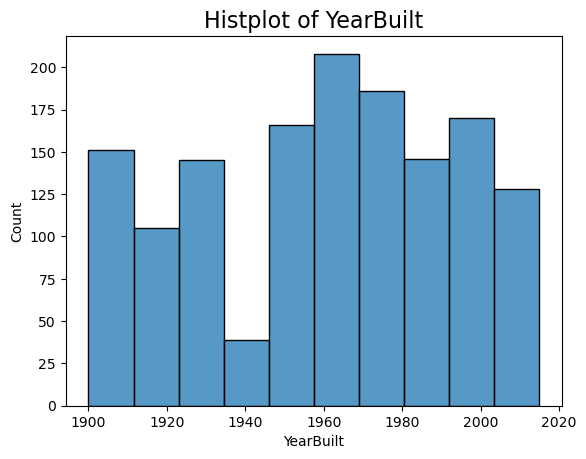

In [260]:
sns.histplot(data=data_fe1, x='YearBuilt', bins=10)
plt.title('Histplot of YearBuilt', fontsize=16)
plt.show()

In [261]:
# Créer 5 bins automatiques
data_fe1['YearBuilt_Bin'] = pd.cut(data_fe1['YearBuilt'], bins=10)

In [262]:
data_fe1.head()

PrimaryPropertyType Neighborhood  YearBuilt  NumberofBuildings  \
0               Hotel     DOWNTOWN       1927                1.0   
1               Hotel     DOWNTOWN       1996                1.0   
3               Hotel     DOWNTOWN       1926                1.0   
4               Hotel     DOWNTOWN       1980                1.0   
5               Other     DOWNTOWN       1999                1.0   

   NumberofFloors  PropertyGFATotal  Electricity(kBtu)  NaturalGas(kBtu)  \
0              12           88434.0          3946027.0         1276453.0   
1              11          103566.0          3242851.0         5145082.0   
3              10           61320.0          2768924.0         1811213.0   
4              18          175580.0          5368607.0         8803998.0   
5               2           97288.0          7371434.0         4715182.0   

   SteamUse(kBtu)  SiteEnergyUseWN(kBtu)  TotalGHGEmissions     YearBuilt_Bin  
0      2003882.00              7456910.0             249.98  (1923.0, 1934.5]  
1            0.00              8664479.0             295.86  (1992.0, 2003.5]  
3      2214446.25              6946800.5             286.43  (1923.0, 1934.5]  
4            0.00             14656503.0             505.01  (1969.0, 1980.5]  
5            0.00             12581712.0             301.81  (1992.0, 2003.5]

In [263]:
data_fe1.shape

(1444, 12)

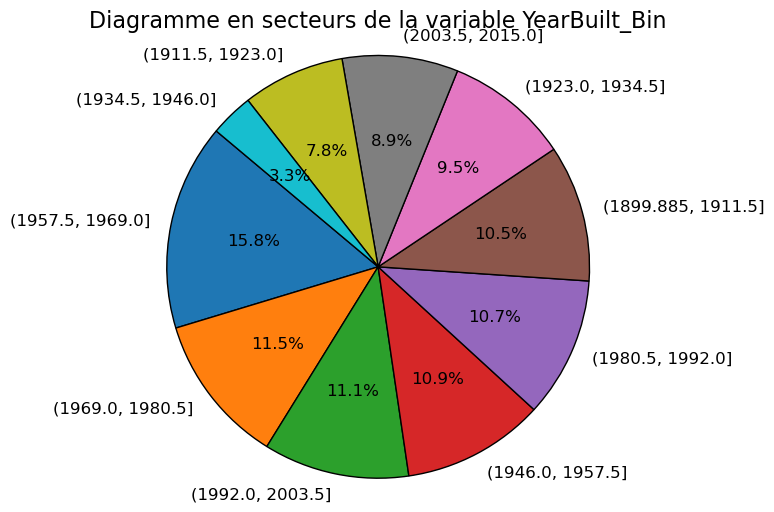

In [264]:
build_pieplot(data_fe1['YearBuilt_Bin'].value_counts(), 'YearBuilt_Bin')

Supprimer l'ancienne feature YearBuilt :

In [266]:
data_fe1.drop('YearBuilt', axis=1, inplace=True)
data_fe1.shape

(1444, 11)

#### 6.16 - Analyse exploratoire

**ANOVA entre la cible SiteEnergyUseWN(kBtu) et les features qualitatives**

Si le rapport de corrélation est :
- < 0.01 : Effet négligeable (très faible)
- = 0.01 : Effet faible
- = 0.06 : Effet modéré
- = 0.14 ou plus : Effet fort

Calculer le rapport de corrélation entre la feature qualitative et les features quantitatives :

In [268]:
# Créer une fonction pour calculer le rapport de corrélation
# SCE = variation interclasse
# SCT = variation totale
# x = variable qualitative
# y = variable quantitative
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

In [269]:
qualitatives_features = ['PrimaryPropertyType', 'Neighborhood', 'YearBuilt_Bin']
data_fe1.head()

PrimaryPropertyType Neighborhood  NumberofBuildings  NumberofFloors  \
0               Hotel     DOWNTOWN                1.0              12   
1               Hotel     DOWNTOWN                1.0              11   
3               Hotel     DOWNTOWN                1.0              10   
4               Hotel     DOWNTOWN                1.0              18   
5               Other     DOWNTOWN                1.0               2   

   PropertyGFATotal  Electricity(kBtu)  NaturalGas(kBtu)  SteamUse(kBtu)  \
0           88434.0          3946027.0         1276453.0      2003882.00   
1          103566.0          3242851.0         5145082.0            0.00   
3           61320.0          2768924.0         1811213.0      2214446.25   
4          175580.0          5368607.0         8803998.0            0.00   
5           97288.0          7371434.0         4715182.0            0.00   

   SiteEnergyUseWN(kBtu)  TotalGHGEmissions     YearBuilt_Bin  
0              7456910.0             249.98  (1923.0, 1934.5]  
1              8664479.0             295.86  (1992.0, 2003.5]  
3              6946800.5             286.43  (1923.0, 1934.5]  
4             14656503.0             505.01  (1969.0, 1980.5]  
5             12581712.0             301.81  (1992.0, 2003.5]

In [270]:
# Calcul du rapport de corrélation ANOVA de chaque feature
correlation_reports = []
for feature in qualitatives_features:
    correlation_report = round(eta_squared(data_fe1[feature], data_fe1['SiteEnergyUseWN(kBtu)']), 2)
    print(feature, ':', str(correlation_report))
    correlation_reports.append(correlation_report)   

PrimaryPropertyType : 0.37
Neighborhood : 0.05
YearBuilt_Bin : 0.09


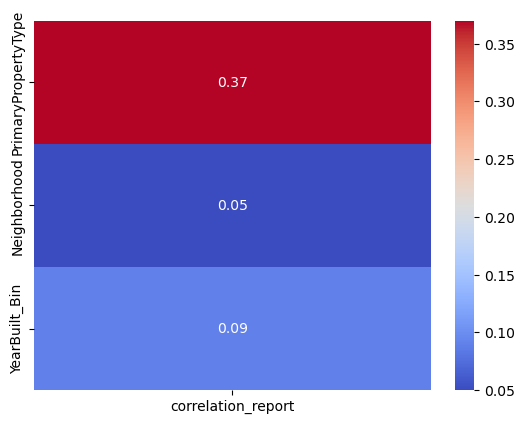

In [271]:
# Transformer la liste en dataframe en précisant la colonne et les index
df_correlation_reports = pd.DataFrame(correlation_reports, columns=['correlation_report'], index=qualitatives_features)

# Créer une heatmap pour la matrice de corrélation
sns.heatmap(df_correlation_reports, annot=True, cmap='coolwarm')

# Afficher la heatmap
plt.show()

On observe que la cible SiteEnergyUseWN(kBtu) est fortement correlée à la feature PrimaryPropertyType (rapport de corrélation = 0.37).

**ANOVA entre la cible TotalGHGEmissions et les features qualitatives**

Calculer le rapport de corrélation entre la feature qualitative et les features quantitatives :

In [274]:
# Calcul du rapport de corrélation ANOVA de chaque feature
correlation_reports = []
for feature in qualitatives_features:
    correlation_report = round(eta_squared(data_fe1[feature], data_fe1['TotalGHGEmissions']), 2)
    print(feature, ':', str(correlation_report))
    correlation_reports.append(correlation_report)   

PrimaryPropertyType : 0.25
Neighborhood : 0.04
YearBuilt_Bin : 0.02


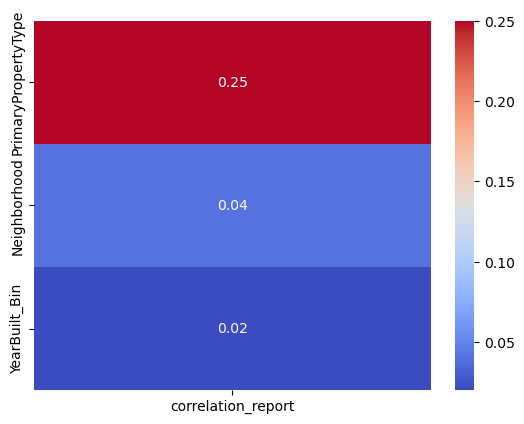

In [275]:
# Transformer la liste en dataframe en précisant la colonne et les index
df_correlation_reports = pd.DataFrame(correlation_reports, columns=['correlation_report'], index=qualitatives_features)

# Créer une heatmap pour la matrice de corrélation
sns.heatmap(df_correlation_reports, annot=True, cmap='coolwarm')

# Afficher la heatmap
plt.show()

On observe que la cible TotalGHGEmissions est également fortement correlée à la feature PrimaryPropertyType (rapport de corrélation = 0.25). Et non corrélée aux 2 autres features.

**Recherche de corrélation entre les 2 cibles et les features quantitatives :**

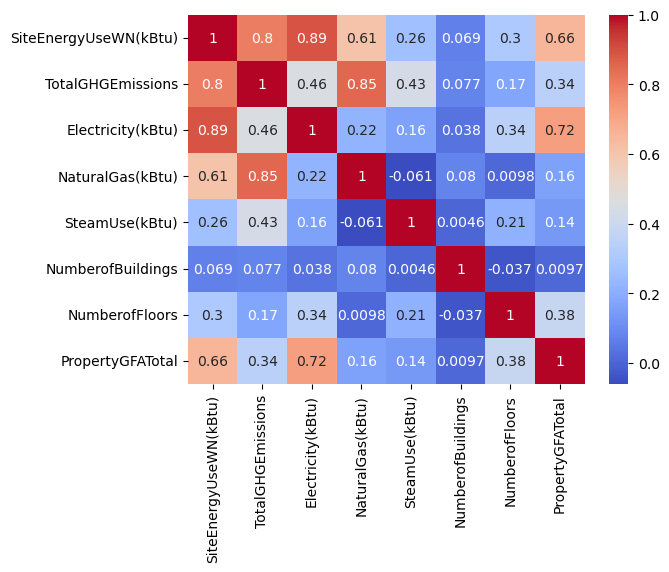

In [278]:
correlation_matrix = data[['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'SteamUse(kBtu)', \
                           'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal']].corr()

# Créer une heatmap pour la matrice de corrélation
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Afficher la heatmap
plt.show()

On oobserve que :
- Les 2 cibles sont corrélées entre elles (0.8)
- La consommation éléectrique est très fortement corrélée à la cible SiteEnergyUseWN(kBtu)
- La consommation de gaz naturel est très fortement corrélée à la cible TotalGHGEmissions
- La cible cible SiteEnergyUseWN(kBtu) est corrélée à PropertyGFATotal et gaz naturel.

#### 6.17 - Numériser les variables catégorielles PrimaryPropertyType, Neighborhood et YearBuilt_Bin

On va d'abord homogénéiser la variable Neighborhood :

In [281]:
data_fe1['Neighborhood'].unique()

array(['DOWNTOWN', 'SOUTHEAST', 'NORTHEAST', 'EAST', 'NORTH',
       'LAKE UNION', 'MAGNOLIA / QUEEN ANNE', 'BALLARD',
       'GREATER DUWAMISH', 'NORTHWEST', 'CENTRAL', 'Ballard', 'DELRIDGE',
       'SOUTHWEST', 'North', 'Delridge', 'Northwest', 'Central',
       'DELRIDGE NEIGHBORHOODS'], dtype=object)

In [282]:
neighborhood_mapping = {
    'North': 'NORTH',
    'Ballard': 'BALLARD',
    'Delridge': 'DELRIDGE',
    'Northwest': 'NORTHWEST',
    'Central': 'CENTRAL'}

data_fe1['Neighborhood'] = data_fe1['Neighborhood'].replace(neighborhood_mapping)

In [283]:
data_fe1.shape

(1444, 11)

In [284]:
data_fe1['Neighborhood'].unique()

array(['DOWNTOWN', 'SOUTHEAST', 'NORTHEAST', 'EAST', 'NORTH',
       'LAKE UNION', 'MAGNOLIA / QUEEN ANNE', 'BALLARD',
       'GREATER DUWAMISH', 'NORTHWEST', 'CENTRAL', 'DELRIDGE',
       'SOUTHWEST', 'DELRIDGE NEIGHBORHOODS'], dtype=object)

Visualisons la dispersion de Neighborhood après l'homogénisation:

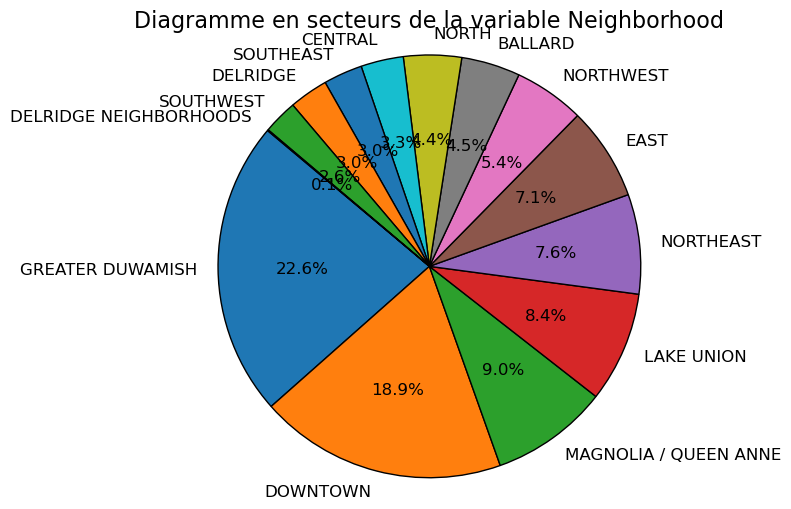

In [286]:
build_pieplot(data_fe1['Neighborhood'].value_counts(), 'Neighborhood')

On va utiliser le oneHotEncoding pour le 1er feature engineering

In [288]:
# Initialiser l'encodeur
encoder = OneHotEncoder()

# Appliquer l'encodeur à une colonne spécifique
columns = ['PrimaryPropertyType', 'Neighborhood', 'YearBuilt_Bin']
encoded_columns = encoder.fit_transform(data_fe1[columns])

print(encoder.get_feature_names_out(columns))

# Ajouter les colonnes encodées dans le DataFrame original
encoded_data_fe1 = pd.DataFrame(encoded_columns.toarray(), columns=encoder.get_feature_names_out(columns))

# Vérifier que les indices sont les mêmes
encoded_data_fe1.index = data_fe1.index

# Concatenation des résultats avec le DataFrame d'origine (en excluant les colonnes encodées)
data_fe1 = pd.concat([data_fe1.drop(columns, axis=1), encoded_data_fe1], axis=1)

['PrimaryPropertyType_Distribution Center' 'PrimaryPropertyType_Hospital'
 'PrimaryPropertyType_Hotel' 'PrimaryPropertyType_K-12 School'
 'PrimaryPropertyType_Laboratory' 'PrimaryPropertyType_Large Office'
 'PrimaryPropertyType_Low-Rise Multifamily'
 'PrimaryPropertyType_Medical Office'
 'PrimaryPropertyType_Mixed Use Property' 'PrimaryPropertyType_Office'
 'PrimaryPropertyType_Other' 'PrimaryPropertyType_Refrigerated Warehouse'
 'PrimaryPropertyType_Residence Hall' 'PrimaryPropertyType_Restaurant'
 'PrimaryPropertyType_Retail Store'
 'PrimaryPropertyType_Self-Storage Facility'
 'PrimaryPropertyType_Senior Care Community'
 'PrimaryPropertyType_Small- and Mid-Sized Office'
 'PrimaryPropertyType_Supermarket / Grocery Store'
 'PrimaryPropertyType_University' 'PrimaryPropertyType_Warehouse'
 'PrimaryPropertyType_Worship Facility' 'Neighborhood_BALLARD'
 'Neighborhood_CENTRAL' 'Neighborhood_DELRIDGE'
 'Neighborhood_DELRIDGE NEIGHBORHOODS' 'Neighborhood_DOWNTOWN'
 'Neighborhood_EAST' 'Neighb

In [289]:
data_fe1.head()

NumberofBuildings  NumberofFloors  PropertyGFATotal  Electricity(kBtu)  \
0                1.0              12           88434.0          3946027.0   
1                1.0              11          103566.0          3242851.0   
3                1.0              10           61320.0          2768924.0   
4                1.0              18          175580.0          5368607.0   
5                1.0               2           97288.0          7371434.0   

   NaturalGas(kBtu)  SteamUse(kBtu)  SiteEnergyUseWN(kBtu)  TotalGHGEmissions  \
0         1276453.0      2003882.00              7456910.0             249.98   
1         5145082.0            0.00              8664479.0             295.86   
3         1811213.0      2214446.25              6946800.5             286.43   
4         8803998.0            0.00             14656503.0             505.01   
5         4715182.0            0.00             12581712.0             301.81   

   PrimaryPropertyType_Distribution Center  PrimaryPropertyType_Hospital  \
0                                      0.0                           0.0   
1                                      0.0                           0.0   
3                                      0.0                           0.0   
4                                      0.0                           0.0   
5                                      0.0                           0.0   

   PrimaryPropertyType_Hotel  PrimaryPropertyType_K-12 School  \
0                        1.0                              0.0   
1                        1.0                              0.0   
3                        1.0                              0.0   
4                        1.0                              0.0   
5                        0.0                              0.0   

   PrimaryPropertyType_Laboratory  PrimaryPropertyType_Large Office  \
0                             0.0                               0.0   
1                             0.0                               0.0   
3                             0.0                               0.0   
4                             0.0                               0.0   
5                             0.0                               0.0   

   PrimaryPropertyType_Low-Rise Multifamily  \
0                                       0.0   
1                                       0.0   
3                                       0.0   
4                                       0.0   
5                                       0.0   

   PrimaryPropertyType_Medical Office  PrimaryPropertyType_Mixed Use Property  \
0                                 0.0                                     0.0   
1                                 0.0                                     0.0   
3                                 0.0                                     0.0   
4                                 0.0                                     0.0   
5                                 0.0                                     0.0   

   PrimaryPropertyType_Office  PrimaryPropertyType_Other  \
0                         0.0                        0.0   
1                         0.0                        0.0   
3                         0.0                        0.0   
4                         0.0                        0.0   
5                         0.0                        1.0   

   PrimaryPropertyType_Refrigerated Warehouse  \
0                                         0.0   
1                                         0.0   
3                                         0.0   
4                                         0.0   
5                                         0.0   

   PrimaryPropertyType_Residence Hall  PrimaryPropertyType_Restaurant  \
0                                 0.0                             0.0   
1                                 0.0                             0.0   
3                                 0.0                             0.0   
4                                 0.0                       

In [290]:
data_fe1.shape

(1444, 54)

#### 6.18 - Transformer les features Electricity , gaz et steam en une feature proportionnelle 

In [292]:
data_fe1['electricity_percent'] = round(data_fe1['Electricity(kBtu)'] * 100 / (data_fe1['Electricity(kBtu)'] + data_fe1['NaturalGas(kBtu)'] + data_fe1['SteamUse(kBtu)']), 2)

data_fe1['gaz_percent'] = round(data_fe1['NaturalGas(kBtu)'] * 100 / (data_fe1['Electricity(kBtu)'] + data_fe1['NaturalGas(kBtu)'] + data_fe1['SteamUse(kBtu)']), 2)

data_fe1['steam_percent'] = round(data_fe1['SteamUse(kBtu)'] * 100 / (data_fe1['Electricity(kBtu)'] + data_fe1['NaturalGas(kBtu)'] + data_fe1['SteamUse(kBtu)']), 2)

In [293]:
data_fe1.head()

NumberofBuildings  NumberofFloors  PropertyGFATotal  Electricity(kBtu)  \
0                1.0              12           88434.0          3946027.0   
1                1.0              11          103566.0          3242851.0   
3                1.0              10           61320.0          2768924.0   
4                1.0              18          175580.0          5368607.0   
5                1.0               2           97288.0          7371434.0   

   NaturalGas(kBtu)  SteamUse(kBtu)  SiteEnergyUseWN(kBtu)  TotalGHGEmissions  \
0         1276453.0      2003882.00              7456910.0             249.98   
1         5145082.0            0.00              8664479.0             295.86   
3         1811213.0      2214446.25              6946800.5             286.43   
4         8803998.0            0.00             14656503.0             505.01   
5         4715182.0            0.00             12581712.0             301.81   

   PrimaryPropertyType_Distribution Center  PrimaryPropertyType_Hospital  \
0                                      0.0                           0.0   
1                                      0.0                           0.0   
3                                      0.0                           0.0   
4                                      0.0                           0.0   
5                                      0.0                           0.0   

   PrimaryPropertyType_Hotel  PrimaryPropertyType_K-12 School  \
0                        1.0                              0.0   
1                        1.0                              0.0   
3                        1.0                              0.0   
4                        1.0                              0.0   
5                        0.0                              0.0   

   PrimaryPropertyType_Laboratory  PrimaryPropertyType_Large Office  \
0                             0.0                               0.0   
1                             0.0                               0.0   
3                             0.0                               0.0   
4                             0.0                               0.0   
5                             0.0                               0.0   

   PrimaryPropertyType_Low-Rise Multifamily  \
0                                       0.0   
1                                       0.0   
3                                       0.0   
4                                       0.0   
5                                       0.0   

   PrimaryPropertyType_Medical Office  PrimaryPropertyType_Mixed Use Property  \
0                                 0.0                                     0.0   
1                                 0.0                                     0.0   
3                                 0.0                                     0.0   
4                                 0.0                                     0.0   
5                                 0.0                                     0.0   

   PrimaryPropertyType_Office  PrimaryPropertyType_Other  \
0                         0.0                        0.0   
1                         0.0                        0.0   
3                         0.0                        0.0   
4                         0.0                        0.0   
5                         0.0                        1.0   

   PrimaryPropertyType_Refrigerated Warehouse  \
0                                         0.0   
1                                         0.0   
3                                         0.0   
4                                         0.0   
5                                         0.0   

   PrimaryPropertyType_Residence Hall  PrimaryPropertyType_Restaurant  \
0                                 0.0                             0.0   
1                                 0.0                             0.0   
3                                 0.0                             0.0   
4                                 0.0                       

In [294]:
data_fe1.drop('Electricity(kBtu)', axis=1, inplace=True)

In [295]:
data_fe1.drop('NaturalGas(kBtu)', axis=1, inplace=True)

In [296]:
data_fe1.drop('SteamUse(kBtu)', axis=1, inplace=True)

In [297]:
data_fe1.shape

(1444, 54)

In [298]:
data_fe1.head()

NumberofBuildings  NumberofFloors  PropertyGFATotal  SiteEnergyUseWN(kBtu)  \
0                1.0              12           88434.0              7456910.0   
1                1.0              11          103566.0              8664479.0   
3                1.0              10           61320.0              6946800.5   
4                1.0              18          175580.0             14656503.0   
5                1.0               2           97288.0             12581712.0   

   TotalGHGEmissions  PrimaryPropertyType_Distribution Center  \
0             249.98                                      0.0   
1             295.86                                      0.0   
3             286.43                                      0.0   
4             505.01                                      0.0   
5             301.81                                      0.0   

   PrimaryPropertyType_Hospital  PrimaryPropertyType_Hotel  \
0                           0.0                        1.0   
1                           0.0                        1.0   
3                           0.0                        1.0   
4                           0.0                        1.0   
5                           0.0                        0.0   

   PrimaryPropertyType_K-12 School  PrimaryPropertyType_Laboratory  \
0                              0.0                             0.0   
1                              0.0                             0.0   
3                              0.0                             0.0   
4                              0.0                             0.0   
5                              0.0                             0.0   

   PrimaryPropertyType_Large Office  PrimaryPropertyType_Low-Rise Multifamily  \
0                               0.0                                       0.0   
1                               0.0                                       0.0   
3                               0.0                                       0.0   
4                               0.0                                       0.0   
5                               0.0                                       0.0   

   PrimaryPropertyType_Medical Office  PrimaryPropertyType_Mixed Use Property  \
0                                 0.0                                     0.0   
1                                 0.0                                     0.0   
3                                 0.0                                     0.0   
4                                 0.0                                     0.0   
5                                 0.0                                     0.0   

   PrimaryPropertyType_Office  PrimaryPropertyType_Other  \
0                         0.0                        0.0   
1                         0.0                        0.0   
3                         0.0                        0.0   
4                         0.0                        0.0   
5                         0.0                        1.0   

   PrimaryPropertyType_Refrigerated Warehouse  \
0                                         0.0   
1                                         0.0   
3                                         0.0   
4                                         0.0   
5                                         0.0   

   PrimaryPropertyType_Residence Hall  PrimaryPropertyType_Restaurant  \
0                                 0.0                             0.0   
1                                 0.0                             0.0   
3                                 0.0                             0.0   
4                                 0.0                             0.0   
5                                 0.0                             0.0   

   PrimaryPropertyType_Retail Store  \
0                               0.0   
1                               0.0   
3                               0.0   
4                               0.0   
5                               0.0   

   PrimaryPropertyType_Self

#### 6.19 - Sauvegarder le résultat du 1er feature engineering pour les analyses prédictives

In [300]:
data_fe1.to_csv('C:/Users/admin/Documents/Projets/Projet_4/data_projet/cleaned/2016_Building_Energy_Benchmarking_fe1.csv', index=False)

### 7 - Amélioration du feature engineering - 2ème fe

On commence par charger le dataset qui avait été nettoyé lors du 1er feature engineering :

In [302]:
data_cleaned = pd.read_csv('C:/Users/admin/Documents/Projets/Projet_4/data_projet/cleaned/2016_Building_Energy_Benchmarking_cleaned.csv')
data_cleaned.head()

OSEBuildingID  DataYear        BuildingType PrimaryPropertyType  \
0              1      2016      NonResidential               Hotel   
1              2      2016      NonResidential               Hotel   
2              5      2016      NonResidential               Hotel   
3              8      2016      NonResidential               Hotel   
4              9      2016  Nonresidential COS               Other   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2                    HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
3  WARWICK SEATTLE HOTEL (ID8)    401 LENORA ST  Seattle    WA  98121.0   
4                West Precinct  810 Virginia St  Seattle    WA  98101.0   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                    0659000030                    7     DOWNTOWN  47.61220   
1                    0659000220                    7     DOWNTOWN  47.61317   
2                    0659000640                    7     DOWNTOWN  47.61412   
3                    0659000970                    7     DOWNTOWN  47.61375   
4                    0660000560                    7     DOWNTOWN  47.61623   

   Longitude  YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799       1927                1.0              12           88434.0   
1 -122.33393       1996                1.0              11          103566.0   
2 -122.33664       1926                1.0              10           61320.0   
3 -122.34047       1980                1.0              18          175580.0   
4 -122.33657       1999                1.0               2           97288.0   

   PropertyGFAParking  PropertyGFABuilding(s)      ListOfAllPropertyUseTypes  \
0                   0                   88434                          Hotel   
1               15064                   88502     Hotel, Parking, Restaurant   
2                   0                   61320                          Hotel   
3               62000                  113580  Hotel, Parking, Swimming Pool   
4               37198                   60090                 Police Station   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                    61320.0   
3                  Hotel                   123445.0   
4         Police Station                    88830.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                          NaN                              NaN   
1                      Parking                          15064.0   
2                          NaN                              NaN   
3                      Parking                          68009.0   
4                          NaN                              NaN   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                         NaN                             NaN   
1                  Restaurant                          4622.0   
2                         NaN                             NaN   
3               Swimming Pool                             0.0   
4                         NaN                             NaN   

  YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                      NaN             60.0         81.699997   
1                      NaN             61.0         94.800003   
2                      NaN             56.0        110.800003   
3                      NaN             75.0        114.800003   
4                      NaN              NaN        136.100006   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0           84.300003          182.500000            189.000000   
1           97.900002          176.100006   

In [303]:
data_cleaned.shape

(1444, 46)

Pour ce 2ème feature engineering, je propose de : ajouter les features suivantes :
- Ajouter la property "PropertyGFAParking"
- Remplacer la feature "PropertyGFATotal" par la création d'une feature qui soustrait la surface totale par la surface de parking, car la consommation d'énergie est plus faible dans les lieux de stationnement que dans les espaces de vie. On a vu en plus que dans le modèle RandomForestRegressor, la surface était la feature la plus importante.
- D'utiliser les variables "LargestPropertyUseType", "SecondLargestPropertyUseType", et "ThirdLargestPropertyUseType" et leur GFA pour calculer la répartition entre 1er, le 2ème et le 3ème usage.

#### 7.1 - Filter les features

In [306]:
features_fe2 = ['PrimaryPropertyType', 'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 'PropertyGFATotal', \
                'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', \
                'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'SteamUse(kBtu)', \
                'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']

In [307]:
data_fe2 = data_cleaned[features_fe2].copy()
data_fe2.head()

PrimaryPropertyType Neighborhood  YearBuilt  NumberofBuildings  \
0               Hotel     DOWNTOWN       1927                1.0   
1               Hotel     DOWNTOWN       1996                1.0   
2               Hotel     DOWNTOWN       1926                1.0   
3               Hotel     DOWNTOWN       1980                1.0   
4               Other     DOWNTOWN       1999                1.0   

   NumberofFloors  PropertyGFAParking  PropertyGFATotal  \
0              12                   0           88434.0   
1              11               15064          103566.0   
2              10                   0           61320.0   
3              18               62000          175580.0   
4               2               37198           97288.0   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                    61320.0   
3                  Hotel                   123445.0   
4         Police Station                    88830.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                          NaN                              NaN   
1                      Parking                          15064.0   
2                          NaN                              NaN   
3                      Parking                          68009.0   
4                          NaN                              NaN   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                         NaN                             NaN   
1                  Restaurant                          4622.0   
2                         NaN                             NaN   
3               Swimming Pool                             0.0   
4                         NaN                             NaN   

   Electricity(kBtu)  NaturalGas(kBtu)  SteamUse(kBtu)  SiteEnergyUseWN(kBtu)  \
0          3946027.0         1276453.0      2003882.00              7456910.0   
1          3242851.0         5145082.0            0.00              8664479.0   
2          2768924.0         1811213.0      2214446.25              6946800.5   
3          5368607.0         8803998.0            0.00             14656503.0   
4          7371434.0         4715182.0            0.00             12581712.0   

   TotalGHGEmissions  
0             249.98  
1             295.86  
2             286.43  
3             505.01  
4             301.81

In [308]:
data_fe2.shape

(1444, 18)

In [309]:
data_fe2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1444 entries, 0 to 1443
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   PrimaryPropertyType              1444 non-null   object 
 1   Neighborhood                     1444 non-null   object 
 2   YearBuilt                        1444 non-null   int64  
 3   NumberofBuildings                1444 non-null   float64
 4   NumberofFloors                   1444 non-null   int64  
 5   PropertyGFAParking               1444 non-null   int64  
 6   PropertyGFATotal                 1444 non-null   float64
 7   LargestPropertyUseType           1440 non-null   object 
 8   LargestPropertyUseTypeGFA        1440 non-null   float64
 9   SecondLargestPropertyUseType     717 non-null    object 
 10  SecondLargestPropertyUseTypeGFA  717 non-null    float64
 11  ThirdLargestPropertyUseType      279 non-null    object 
 12  ThirdLargestProperty

On observe que les features "SecondLargestPropertyUseType" et "ThirdLargestPropertyUseType" sont faiblement renseignées. Je vais partir du principe que si elle n'est pas renseignées, c'est que la proprité n'a pas de 2ème eou 3ème étage.

#### 7.2 - Récupérer les transformations du 1er feature engineering à réutiliser

In [312]:
# Transformer la feature YearBuilt en feature par plage d'année
## Créer 5 bins automatiques
data_fe2['YearBuilt_Bin'] = pd.cut(data_fe2['YearBuilt'], bins=10)
data_fe2.drop('YearBuilt', axis=1, inplace=True)

# Homogénéiser la feature Neighborhood
neighborhood_mapping = {
    'North': 'NORTH',
    'Ballard': 'BALLARD',
    'Delridge': 'DELRIDGE',
    'Northwest': 'NORTHWEST',
    'Central': 'CENTRAL'}
data_fe2['Neighborhood'] = data_fe2['Neighborhood'].replace(neighborhood_mapping)

# Numériser les variables catégorielles Neighborhood et YearBuilt_Bin
## Initialiser l'encodeur
encoder = OneHotEncoder()

## Appliquer l'encodeur à une colonne spécifique
columns = ['Neighborhood', 'YearBuilt_Bin', 'PrimaryPropertyType']
encoded_columns = encoder.fit_transform(data_fe2[columns])

## Ajouter les colonnes encodées dans le DataFrame original
encoded_data_fe2 = pd.DataFrame(encoded_columns.toarray(), columns=encoder.get_feature_names_out(columns))

## Vérifier que les indices sont les mêmes
encoded_data_fe2.index = data_fe2.index

## Concatenation des résultats avec le DataFrame d'origine (en excluant les colonnes encodées)
data_fe2 = pd.concat([data_fe2.drop(columns, axis=1), encoded_data_fe2], axis=1)

# Transformer les features Electricity , gaz et steam en une feature proportionnelle
data_fe2['electricity_percent'] = round(data_fe2['Electricity(kBtu)'] * 100 / (data_fe2['Electricity(kBtu)'] + data_fe2['NaturalGas(kBtu)'] + data_fe2['SteamUse(kBtu)']), 2)
data_fe2['gaz_percent'] = round(data_fe2['NaturalGas(kBtu)'] * 100 / (data_fe2['Electricity(kBtu)'] + data_fe2['NaturalGas(kBtu)'] + data_fe2['SteamUse(kBtu)']), 2)
data_fe2['steam_percent'] = round(data_fe2['SteamUse(kBtu)'] * 100 / (data_fe2['Electricity(kBtu)'] + data_fe2['NaturalGas(kBtu)'] + data_fe2['SteamUse(kBtu)']), 2)
data_fe2.drop('Electricity(kBtu)', axis=1, inplace=True)
data_fe2.drop('NaturalGas(kBtu)', axis=1, inplace=True)
data_fe2.drop('SteamUse(kBtu)', axis=1, inplace=True)

In [313]:
data_fe2.head()

NumberofBuildings  NumberofFloors  PropertyGFAParking  PropertyGFATotal  \
0                1.0              12                   0           88434.0   
1                1.0              11               15064          103566.0   
2                1.0              10                   0           61320.0   
3                1.0              18               62000          175580.0   
4                1.0               2               37198           97288.0   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                    61320.0   
3                  Hotel                   123445.0   
4         Police Station                    88830.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                          NaN                              NaN   
1                      Parking                          15064.0   
2                          NaN                              NaN   
3                      Parking                          68009.0   
4                          NaN                              NaN   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                         NaN                             NaN   
1                  Restaurant                          4622.0   
2                         NaN                             NaN   
3               Swimming Pool                             0.0   
4                         NaN                             NaN   

   SiteEnergyUseWN(kBtu)  TotalGHGEmissions  Neighborhood_BALLARD  \
0              7456910.0             249.98                   0.0   
1              8664479.0             295.86                   0.0   
2              6946800.5             286.43                   0.0   
3             14656503.0             505.01                   0.0   
4             12581712.0             301.81                   0.0   

   Neighborhood_CENTRAL  Neighborhood_DELRIDGE  \
0                   0.0                    0.0   
1                   0.0                    0.0   
2                   0.0                    0.0   
3                   0.0                    0.0   
4                   0.0                    0.0   

   Neighborhood_DELRIDGE NEIGHBORHOODS  Neighborhood_DOWNTOWN  \
0                                  0.0                    1.0   
1                                  0.0                    1.0   
2                                  0.0                    1.0   
3                                  0.0                    1.0   
4                                  0.0                    1.0   

   Neighborhood_EAST  Neighborhood_GREATER DUWAMISH  Neighborhood_LAKE UNION  \
0                0.0                            0.0                      0.0   
1                0.0                            0.0                      0.0   
2                0.0                            0.0                      0.0   
3                0.0                            0.0                      0.0   
4                0.0                            0.0                      0.0   

   Neighborhood_MAGNOLIA / QUEEN ANNE  Neighborhood_NORTH  \
0                                 0.0                 0.0   
1                                 0.0                 0.0   
2                                 0.0                 0.0   
3                                 0.0                 0.0   
4                                 0.0                 0.0   

   Neighborhood_NORTHEAST  Neighborhood_NORTHWEST  Neighborhood_SOUTHEAST  \
0                     0.0                     0.0                     0.0   
1                     0.0                     0.0                     0.0   
2                     0.0                     0.0                     0.0   
3                     0.0                     0.0                     0.0   
4                     0.0                     0.0                    

#### 7.2 - Nettoyer les features LargestPropertyUseType, SecondLargestPropertyUseType, et ThirdLargestPropertyUseType

**Observons le contenu de ces 3 variables :**

In [315]:
data_fe2['LargestPropertyUseType'].unique()

array(['Hotel', 'Police Station', 'Other - Entertainment/Public Assembly',
       'Fitness Center/Health Club/Gym', 'Social/Meeting Hall',
       'K-12 School', 'College/University', 'Automobile Dealership',
       'Office', 'Self-Storage Facility', 'Other - Mall',
       'Medical Office', 'Retail Store', 'Other', 'Museum',
       'Repair Services (Vehicle, Shoe, Locksmith, etc)',
       'Other - Lodging/Residential', 'Residence Hall/Dormitory',
       'Other/Specialty Hospital', 'Financial Office',
       'Non-Refrigerated Warehouse', 'Distribution Center', 'Parking',
       'Multifamily Housing', 'Senior Care Community', 'Worship Facility',
       'Restaurant', 'Laboratory', 'Supermarket/Grocery Store',
       'Urgent Care/Clinic/Other Outpatient', nan, 'Other - Services',
       'Strip Mall', 'Wholesale Club/Supercenter',
       'Refrigerated Warehouse', 'Manufacturing/Industrial Plant',
       'Other - Recreation', 'Lifestyle Center',
       'Other - Public Services', 'Fire Station

In [316]:
data_fe2['SecondLargestPropertyUseType'].unique()

array([nan, 'Parking', 'Office', 'Restaurant', 'K-12 School',
       'Non-Refrigerated Warehouse', 'Other - Education',
       'Vocational School', 'Retail Store',
       'Personal Services (Health/Beauty, Dry Cleaning, etc)',
       'Other - Entertainment/Public Assembly', 'Data Center',
       'Swimming Pool', 'Other', 'Courthouse', 'Residence Hall/Dormitory',
       'Distribution Center', 'Self-Storage Facility', 'Other - Services',
       'Movie Theater', 'Supermarket/Grocery Store', 'Medical Office',
       'Other - Recreation', 'Convenience Store without Gas Station',
       'Performing Arts', 'Other - Restaurant/Bar', 'Laboratory',
       'Adult Education', 'Enclosed Mall', 'Multifamily Housing',
       'Bar/Nightclub', 'Financial Office',
       'Manufacturing/Industrial Plant', 'Other - Lodging/Residential',
       'Bank Branch', 'Refrigerated Warehouse',
       'Fitness Center/Health Club/Gym', 'Hotel', 'Worship Facility',
       'Food Sales', 'Other - Public Services',
     

In [317]:
data_fe2['ThirdLargestPropertyUseType'].unique()

array([nan, 'Restaurant', 'Swimming Pool', 'Office', 'Retail Store',
       'Other - Entertainment/Public Assembly', 'Data Center', 'Other',
       'Distribution Center', 'Food Service', 'Other - Services',
       'Medical Office', 'Parking', 'K-12 School', 'Social/Meeting Hall',
       'Non-Refrigerated Warehouse', 'Fitness Center/Health Club/Gym',
       'Other - Restaurant/Bar', 'Multifamily Housing', 'Bank Branch',
       'Financial Office', 'Other - Recreation',
       'Personal Services (Health/Beauty, Dry Cleaning, etc)',
       'Self-Storage Facility', 'Pre-school/Daycare', 'Bar/Nightclub',
       'Manufacturing/Industrial Plant', 'Fast Food Restaurant',
       'Refrigerated Warehouse', 'Supermarket/Grocery Store',
       'Other - Education', 'Strip Mall', 'Vocational School'],
      dtype=object)

On observe que les catégories utliisées dans ces 3 variables sont les mêmes. On peut donc créer une liste communes, et réduire le nombres de valeurs en faisant des regroupements de catégories.

**Quels regroupements possibles ?**

Quel est le nombre de propriété par catégories pour le 1er usage ?

In [320]:
# GroupBy et comptage
group_counts = data_fe2.groupby('LargestPropertyUseType').size()

print(group_counts)

LargestPropertyUseType
Adult Education                                           2
Automobile Dealership                                     5
Bank Branch                                               4
College/University                                       15
Distribution Center                                      52
Financial Office                                          4
Fire Station                                              1
Fitness Center/Health Club/Gym                            5
Food Service                                              1
Hospital (General Medical & Surgical)                     1
Hotel                                                    61
K-12 School                                             123
Laboratory                                                5
Library                                                   3
Lifestyle Center                                          1
Manufacturing/Industrial Plant                            8
Medical Office   

Quel est le nombre de propriété par catégories pour le 2er usage ?

In [322]:
# GroupBy et comptage
group_counts = data_fe2.groupby('SecondLargestPropertyUseType').size()

print(group_counts)

SecondLargestPropertyUseType
Adult Education                                           2
Automobile Dealership                                     2
Bank Branch                                               7
Bar/Nightclub                                             2
Convenience Store without Gas Station                     1
Courthouse                                                1
Data Center                                               7
Distribution Center                                       7
Enclosed Mall                                             1
Financial Office                                          1
Fitness Center/Health Club/Gym                           16
Food Sales                                                2
Food Service                                              1
Hotel                                                     2
K-12 School                                               5
Laboratory                                                3
Manufacturi

Quel est le nombre de propriété par catégories pour le 3e usage ?

In [324]:
# GroupBy et comptage
group_counts = data_fe2.groupby('ThirdLargestPropertyUseType').size()

print(group_counts)

ThirdLargestPropertyUseType
Bank Branch                                              5
Bar/Nightclub                                            1
Data Center                                              9
Distribution Center                                      3
Fast Food Restaurant                                     1
Financial Office                                         2
Fitness Center/Health Club/Gym                           3
Food Service                                             7
K-12 School                                              2
Manufacturing/Industrial Plant                           1
Medical Office                                           7
Multifamily Housing                                     12
Non-Refrigerated Warehouse                              13
Office                                                  44
Other                                                   24
Other - Education                                        1
Other - Entertainment/Public

Quel est la moyenne des surfaces par catégorie pour le 2eme usage ?

In [326]:
# GroupBy sur la colonne "Category" et calcul de la moyenne de la colonne "Value"
grouped_means = data_fe2.groupby('SecondLargestPropertyUseType')['SecondLargestPropertyUseTypeGFA'].mean().reset_index()

print("Moyenne des valeurs par catégorie :")
print(grouped_means)

Moyenne des valeurs par catégorie :
                         SecondLargestPropertyUseType  \
0                                     Adult Education   
1                               Automobile Dealership   
2                                         Bank Branch   
3                                       Bar/Nightclub   
4               Convenience Store without Gas Station   
5                                          Courthouse   
6                                         Data Center   
7                                 Distribution Center   
8                                       Enclosed Mall   
9                                    Financial Office   
10                     Fitness Center/Health Club/Gym   
11                                         Food Sales   
12                                       Food Service   
13                                              Hotel   
14                                        K-12 School   
15                                         Laborator

Quel est la moyenne des surfaces par catégorie pour le 3eme usage ?

In [328]:
# GroupBy sur la colonne "Category" et calcul de la moyenne de la colonne "Value"
grouped_means = data_fe2.groupby('ThirdLargestPropertyUseType')['ThirdLargestPropertyUseTypeGFA'].mean().reset_index()

print("Moyenne des valeurs par catégorie :")
print(grouped_means)

Moyenne des valeurs par catégorie :
                          ThirdLargestPropertyUseType  \
0                                         Bank Branch   
1                                       Bar/Nightclub   
2                                         Data Center   
3                                 Distribution Center   
4                                Fast Food Restaurant   
5                                    Financial Office   
6                      Fitness Center/Health Club/Gym   
7                                        Food Service   
8                                         K-12 School   
9                      Manufacturing/Industrial Plant   
10                                     Medical Office   
11                                Multifamily Housing   
12                         Non-Refrigerated Warehouse   
13                                             Office   
14                                              Other   
15                                  Other - Educatio

In [329]:
# Fusionner les séries en une seule
merged = pd.concat([
    pd.Series(data_fe2['LargestPropertyUseType'].unique()),
    pd.Series(data_fe2['SecondLargestPropertyUseType'].unique()),
    pd.Series(data_fe2['ThirdLargestPropertyUseType'].unique())
])

# Supprimer les doublons et réinitialiser l'index
property_use_types = merged.drop_duplicates().reset_index(drop=True)
print(property_use_types)

0                                                 Hotel
1                                        Police Station
2                 Other - Entertainment/Public Assembly
3                        Fitness Center/Health Club/Gym
4                                   Social/Meeting Hall
5                                           K-12 School
6                                    College/University
7                                 Automobile Dealership
8                                                Office
9                                 Self-Storage Facility
10                                         Other - Mall
11                                       Medical Office
12                                         Retail Store
13                                                Other
14                                               Museum
15      Repair Services (Vehicle, Shoe, Locksmith, etc)
16                          Other - Lodging/Residential
17                             Residence Hall/Do

**Faisons des regroupements :**

**Hébergement & Logement**

Hotel,
Residence Hall/Dormitory,
Other - Lodging/Residential,
Multifamily Housing,
Senior Care Community,
Residential Care Facility

**Éducation**

K-12 School,
College/University,
Adult Education,
Pre-school/Daycare,
Vocational School,
Library,
Other - Education

**Restauration**

Restaurant,
Fast Food Restaurant,
Food Service,
Other - Restaurant/Bar

**Commerce & Retail**

Retail Store,
Supermarket/Grocery Store,
Wholesale Club/Supercenter,
Strip Mall,
Food Sales,
Convenience Store without Gas Station,
Other - Mall,
Lifestyle Center,
Movie Theater,
Bar/Nightclub,
Other - Entertainment/Public Assembly

**Bureaux & Espaces de travail**

Office,
Financial Office,
Medical Office,
Bank Branch,
Data Center,
Repair Services (Vehicle, Shoe, Locksmith, etc)

**Services publics & Infrastructure**

Police Station,
Fire Station,
Worship Facility,
Prison/Incarceration,
Other - Public Services,
Other - Utility,
Other - Recreation,
Other - Services

**Soins médicaux**

Hospital (General Medical & Surgical),
Urgent Care/Clinic/Other Outpatient,
Other/Specialty Hospital

**Loisirs et Divertissement**

Fitness Center/Health Club/Gym,
Social/Meeting Hall,
Performing Arts,
Museum,
Swimming Pool

**Entrepôts et Logistique**

Non-Refrigerated Warehouse,
Refrigerated Warehouse,
Distribution Center,
Manufacturing/Industrial Plant

**Transports & Parking**

Parking,
Automobile Dealership

**Autres catégories générales**

Other,
Other - Services,
Other - Specialty Services,
Other - Lodging/Residential,
Other - Utility

In [331]:
# Dictionnaire de regroupement des catégories
category_mapping = {
    'Hotel': 'usage_Hébergement & Logement',
    'Residence Hall/Dormitory': 'usage_Hébergement & Logement',
    'Other - Lodging/Residential': 'usage_Hébergement & Logement',
    'Multifamily Housing': 'usage_Hébergement & Logement',
    'Senior Care Community': 'usage_Hébergement & Logement',
    'Residential Care Facility': 'usage_Hébergement & Logement',
    
    'K-12 School': 'usage_Éducation',
    'College/University': 'usage_Éducation',
    'Adult Education': 'usage_Éducation',
    'Pre-school/Daycare': 'usage_Éducation',
    'Vocational School': 'usage_Éducation',
    'Library': 'usage_Éducation',
    'Other - Education': 'usage_Éducation',

    'Restaurant': 'usage_Restauration',
    'Fast Food Restaurant': 'usage_Restauration',
    'Food Service': 'usage_Restauration',
    'Other - Restaurant/Bar': 'usage_Restauration',    
    
    'Retail Store': 'usage_Commerce & Retail',
    'Supermarket/Grocery Store': 'usage_Commerce & Retail',
    'Wholesale Club/Supercenter': 'usage_Commerce & Retail',
    'Strip Mall': 'usage_Commerce & Retail',
    'Food Sales': 'usage_Commerce & Retail',
    'Convenience Store without Gas Station': 'usage_Commerce & Retail',
    'Other - Mall': 'usage_Commerce & Retail',
    'Lifestyle Center': 'usage_Commerce & Retail',
    'Movie Theater': 'usage_Commerce & Retail',
    'Bar/Nightclub': 'usage_Commerce & Retail',
    'Other - Entertainment/Public Assembly': 'usage_Commerce & Retail',
    'Enclosed Mall': 'usage_Commerce & Retail',
    
    'Office': 'usage_Bureaux & Espaces de travail',
    'Financial Office': 'usage_Bureaux & Espaces de travail',
    'Medical Office': 'usage_Bureaux & Espaces de travail',
    'Bank Branch': 'usage_Bureaux & Espaces de travail',
    'Data Center': 'usage_Bureaux & Espaces de travail',
    'Repair Services (Vehicle, Shoe, Locksmith, etc)': 'usage_Bureaux & Espaces de travail',
    
    'Police Station': 'usage_Services publics & Infrastructure',
    'Fire Station': 'usage_Services publics & Infrastructure',
    'Worship Facility': 'usage_Services publics & Infrastructure',
    'Prison/Incarceration': 'usage_Services publics & Infrastructure',
    'Other - Public Services': 'usage_Services publics & Infrastructure',
    'Other - Utility': 'usage_Services publics & Infrastructure',
    'Other - Recreation': 'usage_Services publics & Infrastructure',
    'Other - Services': 'usage_Services publics & Infrastructure',
    'Courthouse': 'usage_Services publics & Infrastructure',
    
    'Hospital (General Medical & Surgical)': 'usage_Soins médicaux',
    'Urgent Care/Clinic/Other Outpatient': 'usage_Soins médicaux',
    'Other/Specialty Hospital': 'usage_Soins médicaux',
    'Laboratory': 'usage_Soins médicaux',
    
    'Fitness Center/Health Club/Gym': 'usage_Loisirs et Divertissement',
    'Social/Meeting Hall': 'usage_Loisirs et Divertissement',
    'Performing Arts': 'usage_Loisirs et Divertissement',
    'Museum': 'usage_Loisirs et Divertissement',
    'Swimming Pool': 'usage_Loisirs et Divertissement',
    
    'Non-Refrigerated Warehouse': 'usage_Entrepôts et Logistique',
    'Refrigerated Warehouse': 'usage_Entrepôts et Logistique',
    'Distribution Center': 'usage_Entrepôts et Logistique',
    'Manufacturing/Industrial Plant': 'usage_Entrepôts et Logistique',
    'Self-Storage Facility': 'usage_Entrepôts et Logistique',
    
    'Parking': 'usage_Transports & Parking',
    'Automobile Dealership': 'usage_Transports & Parking',

    'Others': 'usage_Autres',
    'Other': 'usage_Autres',
    'Personal Services (Health/Beauty, Dry Cleaning...': 'usage_Autres',
    'Personal Services (Health/Beauty, Dry Cleaning, etc)': 'usage_Autres'
    
}

In [332]:
# Remplacer les catégories par leurs regroupements
data_fe2['LargestPropertyUseType'] = data_fe2['LargestPropertyUseType'].replace(category_mapping)
data_fe2['SecondLargestPropertyUseType'] = data_fe2['SecondLargestPropertyUseType'].replace(category_mapping)
data_fe2['ThirdLargestPropertyUseType'] = data_fe2['ThirdLargestPropertyUseType'].replace(category_mapping)

In [333]:
data_fe2.head()

NumberofBuildings  NumberofFloors  PropertyGFAParking  PropertyGFATotal  \
0                1.0              12                   0           88434.0   
1                1.0              11               15064          103566.0   
2                1.0              10                   0           61320.0   
3                1.0              18               62000          175580.0   
4                1.0               2               37198           97288.0   

                    LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0             usage_Hébergement & Logement                    88434.0   
1             usage_Hébergement & Logement                    83880.0   
2             usage_Hébergement & Logement                    61320.0   
3             usage_Hébergement & Logement                   123445.0   
4  usage_Services publics & Infrastructure                    88830.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                          NaN                              NaN   
1   usage_Transports & Parking                          15064.0   
2                          NaN                              NaN   
3   usage_Transports & Parking                          68009.0   
4                          NaN                              NaN   

       ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                              NaN                             NaN   
1               usage_Restauration                          4622.0   
2                              NaN                             NaN   
3  usage_Loisirs et Divertissement                             0.0   
4                              NaN                             NaN   

   SiteEnergyUseWN(kBtu)  TotalGHGEmissions  Neighborhood_BALLARD  \
0              7456910.0             249.98                   0.0   
1              8664479.0             295.86                   0.0   
2              6946800.5             286.43                   0.0   
3             14656503.0             505.01                   0.0   
4             12581712.0             301.81                   0.0   

   Neighborhood_CENTRAL  Neighborhood_DELRIDGE  \
0                   0.0                    0.0   
1                   0.0                    0.0   
2                   0.0                    0.0   
3                   0.0                    0.0   
4                   0.0                    0.0   

   Neighborhood_DELRIDGE NEIGHBORHOODS  Neighborhood_DOWNTOWN  \
0                                  0.0                    1.0   
1                                  0.0                    1.0   
2                                  0.0                    1.0   
3                                  0.0                    1.0   
4                                  0.0                    1.0   

   Neighborhood_EAST  Neighborhood_GREATER DUWAMISH  Neighborhood_LAKE UNION  \
0                0.0                            0.0                      0.0   
1                0.0                            0.0                      0.0   
2                0.0                            0.0                      0.0   
3                0.0                            0.0                      0.0   
4                0.0                            0.0                      0.0   

   Neighborhood_MAGNOLIA / QUEEN ANNE  Neighborhood_NORTH  \
0                                 0.0                 0.0   
1                                 0.0                 0.0   
2                                 0.0                 0.0   
3                                 0.0                 0.0   
4                                 0.0                 0.0   

   Neighborhood_NORTHEAST  Neighborhood_NORTHWEST  Neighborhood_SOUTHEAST  \
0                     0.0                     0.0                     0.0   
1                     0.0                     0.0                     0.0   
2                     0.0                     0.0                     0.0   
3       

In [334]:
data_fe2.shape

(1444, 61)

In [335]:
data_fe2['LargestPropertyUseType'].unique()

array(['usage_Hébergement & Logement',
       'usage_Services publics & Infrastructure',
       'usage_Commerce & Retail', 'usage_Loisirs et Divertissement',
       'usage_Éducation', 'usage_Transports & Parking',
       'usage_Bureaux & Espaces de travail',
       'usage_Entrepôts et Logistique', 'usage_Autres',
       'usage_Soins médicaux', 'usage_Restauration', nan], dtype=object)

In [336]:
data_fe2['SecondLargestPropertyUseType'].unique()

array([nan, 'usage_Transports & Parking',
       'usage_Bureaux & Espaces de travail', 'usage_Restauration',
       'usage_Éducation', 'usage_Entrepôts et Logistique',
       'usage_Commerce & Retail', 'usage_Autres',
       'usage_Loisirs et Divertissement',
       'usage_Services publics & Infrastructure',
       'usage_Hébergement & Logement', 'usage_Soins médicaux'],
      dtype=object)

In [337]:
data_fe2['ThirdLargestPropertyUseType'].unique()

array([nan, 'usage_Restauration', 'usage_Loisirs et Divertissement',
       'usage_Bureaux & Espaces de travail', 'usage_Commerce & Retail',
       'usage_Autres', 'usage_Entrepôts et Logistique',
       'usage_Services publics & Infrastructure',
       'usage_Transports & Parking', 'usage_Éducation',
       'usage_Hébergement & Logement'], dtype=object)

In [338]:
# GroupBy et comptage
group_counts = data_fe2.groupby('LargestPropertyUseType').size()

print(group_counts)

LargestPropertyUseType
usage_Autres                                79
usage_Bureaux & Espaces de travail         460
usage_Commerce & Retail                    158
usage_Entrepôts et Logistique              296
usage_Hébergement & Logement               113
usage_Loisirs et Divertissement             23
usage_Restauration                          15
usage_Services publics & Infrastructure    109
usage_Soins médicaux                        12
usage_Transports & Parking                  27
usage_Éducation                            148
dtype: int64


In [339]:
# GroupBy et comptage
group_counts = data_fe2.groupby('SecondLargestPropertyUseType').size()

print(group_counts)

SecondLargestPropertyUseType
usage_Autres                                42
usage_Bureaux & Espaces de travail         182
usage_Commerce & Retail                    102
usage_Entrepôts et Logistique               41
usage_Hébergement & Logement                14
usage_Loisirs et Divertissement             22
usage_Restauration                          29
usage_Services publics & Infrastructure     20
usage_Soins médicaux                         3
usage_Transports & Parking                 251
usage_Éducation                             11
dtype: int64


In [340]:
# GroupBy et comptage
group_counts = data_fe2.groupby('ThirdLargestPropertyUseType').size()

print(group_counts)

ThirdLargestPropertyUseType
usage_Autres                               25
usage_Bureaux & Espaces de travail         67
usage_Commerce & Retail                    51
usage_Entrepôts et Logistique              20
usage_Hébergement & Logement               12
usage_Loisirs et Divertissement            19
usage_Restauration                         32
usage_Services publics & Infrastructure     4
usage_Transports & Parking                 38
usage_Éducation                            11
dtype: int64


In [341]:
# Fusionner les séries en une seule
merged = pd.concat([
    pd.Series(data_fe2['LargestPropertyUseType'].unique()),
    pd.Series(data_fe2['SecondLargestPropertyUseType'].unique()),
    pd.Series(data_fe2['ThirdLargestPropertyUseType'].unique())
])

# Supprimer les doublons et réinitialiser l'index
property_use_types = merged.drop_duplicates().reset_index(drop=True)
print(property_use_types)

0                usage_Hébergement & Logement
1     usage_Services publics & Infrastructure
2                     usage_Commerce & Retail
3             usage_Loisirs et Divertissement
4                             usage_Éducation
5                  usage_Transports & Parking
6          usage_Bureaux & Espaces de travail
7               usage_Entrepôts et Logistique
8                                usage_Autres
9                        usage_Soins médicaux
10                         usage_Restauration
11                                        NaN
dtype: object


**Traitons les valeurs manquantes de LargestPropertyUseType**

In [343]:
data_fe2['LargestPropertyUseType'].isna().sum()

4

Supprimons les lignes manquantes sur la variable LargestPropertyUseType:

In [345]:
data_fe2 = data_fe2.loc[~data_fe2['LargestPropertyUseType'].isna()]
data_fe2.shape

(1440, 61)

In [346]:
data_fe2.describe()

NumberofBuildings  NumberofFloors  PropertyGFAParking  \
count        1440.000000     1440.000000         1440.000000   
mean            1.052083        3.072917         7818.480556   
std             0.395504        3.749389        27192.831177   
min             1.000000        0.000000            0.000000   
25%             1.000000        1.000000            0.000000   
50%             1.000000        2.000000            0.000000   
75%             1.000000        4.000000            0.000000   
max             6.000000       99.000000       335109.000000   

       PropertyGFATotal  LargestPropertyUseTypeGFA  \
count       1440.000000                1440.000000   
mean       68887.441319               57434.702778   
std        68826.901408               55310.669597   
min        11285.000000                5656.000000   
25%        28015.500000               24006.000000   
50%        43630.000000               38755.000000   
75%        78380.750000               66522.000000   
max       536697.000000              432903.000000   

       SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  \
count                       717.000000                      279.000000   
mean                      19682.220777                     7006.342295   
std                       30532.629062                     7854.147605   
min                           0.000000                        0.000000   
25%                        4800.000000                     2397.000000   
50%                        9976.000000                     5000.000000   
75%                       20962.000000                     9007.500000   
max                      333698.000000                    58152.000000   

       SiteEnergyUseWN(kBtu)  TotalGHGEmissions  Neighborhood_BALLARD  \
count           1.440000e+03        1440.000000           1440.000000   
mean            3.771625e+06          78.853729              0.044444   
std             3.598713e+06          95.706117              0.206152   
min             5.811420e+04           0.400000              0.000000   
25%             1.259692e+06          18.600000              0.000000   
50%             2.339853e+06          43.635000              0.000000   
75%             5.206862e+06          95.877500              0.000000   
max             1.622816e+07         712.390000              1.000000   

       Neighborhood_CENTRAL  Neighborhood_DELRIDGE  \
count           1440.000000            1440.000000   
mean               0.032639               0.029861   
std                0.177751               0.170263   
min                0.000000               0.000000   
25%                0.000000               0.000000   
50%                0.000000               0.000000   
75%                0.000000               0.000000   
max                1.000000               1.000000   

       Neighborhood_DELRIDGE NEIGHBORHOODS  Neighborhood_DOWNTOWN  \
count                          1440.000000            1440.000000   
mean                              0.000694               0.188194   
std                               0.026352               0.391003   
min                               0.000000               0.000000   
25%                               0.000000               0.000000   
50%                               0.000000               0.000000   
75%                               0.000000               0.000000   
max                               1.000000               1.000000   

       Neighborhood_EAST  Neighborhood_GREATER DUWAMISH  \
count        1440.000000                    1440.000000   
mean            0.071528                       0.227083   
std             0.257794                       0.419092   
min             0.000000                       0.000000   
25%             0.000000                       0.000000   
50%             0.000000                       0.000000   
75%             0.000000                       0.000000   
max             1.000000             

In [347]:
data_fe2.head()

NumberofBuildings  NumberofFloors  PropertyGFAParking  PropertyGFATotal  \
0                1.0              12                   0           88434.0   
1                1.0              11               15064          103566.0   
2                1.0              10                   0           61320.0   
3                1.0              18               62000          175580.0   
4                1.0               2               37198           97288.0   

                    LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0             usage_Hébergement & Logement                    88434.0   
1             usage_Hébergement & Logement                    83880.0   
2             usage_Hébergement & Logement                    61320.0   
3             usage_Hébergement & Logement                   123445.0   
4  usage_Services publics & Infrastructure                    88830.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                          NaN                              NaN   
1   usage_Transports & Parking                          15064.0   
2                          NaN                              NaN   
3   usage_Transports & Parking                          68009.0   
4                          NaN                              NaN   

       ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                              NaN                             NaN   
1               usage_Restauration                          4622.0   
2                              NaN                             NaN   
3  usage_Loisirs et Divertissement                             0.0   
4                              NaN                             NaN   

   SiteEnergyUseWN(kBtu)  TotalGHGEmissions  Neighborhood_BALLARD  \
0              7456910.0             249.98                   0.0   
1              8664479.0             295.86                   0.0   
2              6946800.5             286.43                   0.0   
3             14656503.0             505.01                   0.0   
4             12581712.0             301.81                   0.0   

   Neighborhood_CENTRAL  Neighborhood_DELRIDGE  \
0                   0.0                    0.0   
1                   0.0                    0.0   
2                   0.0                    0.0   
3                   0.0                    0.0   
4                   0.0                    0.0   

   Neighborhood_DELRIDGE NEIGHBORHOODS  Neighborhood_DOWNTOWN  \
0                                  0.0                    1.0   
1                                  0.0                    1.0   
2                                  0.0                    1.0   
3                                  0.0                    1.0   
4                                  0.0                    1.0   

   Neighborhood_EAST  Neighborhood_GREATER DUWAMISH  Neighborhood_LAKE UNION  \
0                0.0                            0.0                      0.0   
1                0.0                            0.0                      0.0   
2                0.0                            0.0                      0.0   
3                0.0                            0.0                      0.0   
4                0.0                            0.0                      0.0   

   Neighborhood_MAGNOLIA / QUEEN ANNE  Neighborhood_NORTH  \
0                                 0.0                 0.0   
1                                 0.0                 0.0   
2                                 0.0                 0.0   
3                                 0.0                 0.0   
4                                 0.0                 0.0   

   Neighborhood_NORTHEAST  Neighborhood_NORTHWEST  Neighborhood_SOUTHEAST  \
0                     0.0                     0.0                     0.0   
1                     0.0                     0.0                     0.0   
2                     0.0                     0.0                     0.0   
3       

**Créons autant de features que de propertyUseType**

Ces nouvelles features contiendront la proportion entre largest, secondLargest, et thirdLargest, calculée à partir des ..GFA.

Pour simplifier les calculs, dans un premier temps je vais mettre directement la valeur de la surface dans la colonne appropriée.

In [349]:
categories = np.unique(np.array(list(category_mapping.values())).flatten())

In [350]:
print(categories)

['usage_Autres' 'usage_Bureaux & Espaces de travail'
 'usage_Commerce & Retail' 'usage_Entrepôts et Logistique'
 'usage_Hébergement & Logement' 'usage_Loisirs et Divertissement'
 'usage_Restauration' 'usage_Services publics & Infrastructure'
 'usage_Soins médicaux' 'usage_Transports & Parking' 'usage_Éducation']


In [351]:
for cat in categories:    
    data_fe2[cat] = data_fe2.apply(
        lambda row: row['LargestPropertyUseTypeGFA'] if row['LargestPropertyUseType'] == cat else
                    row['SecondLargestPropertyUseTypeGFA'] if row['SecondLargestPropertyUseType'] == cat else
                    row['ThirdLargestPropertyUseTypeGFA'] if row['ThirdLargestPropertyUseType'] == cat else
                    0, axis=1
    )

In [352]:
data_fe2.shape

(1440, 72)

In [353]:
data_fe2.head()

NumberofBuildings  NumberofFloors  PropertyGFAParking  PropertyGFATotal  \
0                1.0              12                   0           88434.0   
1                1.0              11               15064          103566.0   
2                1.0              10                   0           61320.0   
3                1.0              18               62000          175580.0   
4                1.0               2               37198           97288.0   

                    LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0             usage_Hébergement & Logement                    88434.0   
1             usage_Hébergement & Logement                    83880.0   
2             usage_Hébergement & Logement                    61320.0   
3             usage_Hébergement & Logement                   123445.0   
4  usage_Services publics & Infrastructure                    88830.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                          NaN                              NaN   
1   usage_Transports & Parking                          15064.0   
2                          NaN                              NaN   
3   usage_Transports & Parking                          68009.0   
4                          NaN                              NaN   

       ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                              NaN                             NaN   
1               usage_Restauration                          4622.0   
2                              NaN                             NaN   
3  usage_Loisirs et Divertissement                             0.0   
4                              NaN                             NaN   

   SiteEnergyUseWN(kBtu)  TotalGHGEmissions  Neighborhood_BALLARD  \
0              7456910.0             249.98                   0.0   
1              8664479.0             295.86                   0.0   
2              6946800.5             286.43                   0.0   
3             14656503.0             505.01                   0.0   
4             12581712.0             301.81                   0.0   

   Neighborhood_CENTRAL  Neighborhood_DELRIDGE  \
0                   0.0                    0.0   
1                   0.0                    0.0   
2                   0.0                    0.0   
3                   0.0                    0.0   
4                   0.0                    0.0   

   Neighborhood_DELRIDGE NEIGHBORHOODS  Neighborhood_DOWNTOWN  \
0                                  0.0                    1.0   
1                                  0.0                    1.0   
2                                  0.0                    1.0   
3                                  0.0                    1.0   
4                                  0.0                    1.0   

   Neighborhood_EAST  Neighborhood_GREATER DUWAMISH  Neighborhood_LAKE UNION  \
0                0.0                            0.0                      0.0   
1                0.0                            0.0                      0.0   
2                0.0                            0.0                      0.0   
3                0.0                            0.0                      0.0   
4                0.0                            0.0                      0.0   

   Neighborhood_MAGNOLIA / QUEEN ANNE  Neighborhood_NORTH  \
0                                 0.0                 0.0   
1                                 0.0                 0.0   
2                                 0.0                 0.0   
3                                 0.0                 0.0   
4                                 0.0                 0.0   

   Neighborhood_NORTHEAST  Neighborhood_NORTHWEST  Neighborhood_SOUTHEAST  \
0                     0.0                     0.0                     0.0   
1                     0.0                     0.0                     0.0   
2                     0.0                     0.0                     0.0   
3       

On peut maintenant calculer la proportion de chaque propertyUseType:

In [355]:
# Fusionner les séries en une seule
merged = pd.concat([
    pd.Series(data_fe2['LargestPropertyUseType'].unique()),
    pd.Series(data_fe2['SecondLargestPropertyUseType'].unique()),
    pd.Series(data_fe2['ThirdLargestPropertyUseType'].unique())
])

# Supprimer les doublons et réinitialiser l'index
property_use_types = merged.drop_duplicates().reset_index(drop=True)
print(property_use_types)

0                usage_Hébergement & Logement
1     usage_Services publics & Infrastructure
2                     usage_Commerce & Retail
3             usage_Loisirs et Divertissement
4                             usage_Éducation
5                  usage_Transports & Parking
6          usage_Bureaux & Espaces de travail
7               usage_Entrepôts et Logistique
8                                usage_Autres
9                        usage_Soins médicaux
10                         usage_Restauration
11                                        NaN
dtype: object


In [356]:
data_fe2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1440 entries, 0 to 1443
Data columns (total 72 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   NumberofBuildings                                1440 non-null   float64
 1   NumberofFloors                                   1440 non-null   int64  
 2   PropertyGFAParking                               1440 non-null   int64  
 3   PropertyGFATotal                                 1440 non-null   float64
 4   LargestPropertyUseType                           1440 non-null   object 
 5   LargestPropertyUseTypeGFA                        1440 non-null   float64
 6   SecondLargestPropertyUseType                     717 non-null    object 
 7   SecondLargestPropertyUseTypeGFA                  717 non-null    float64
 8   ThirdLargestPropertyUseType                      279 non-null    object 
 9   ThirdLargestPropertyUseTypeGFA     

In [357]:
# Calculer la somme des colonnes une fois pour toutes les lignes
total_sum = data_fe2[categories].sum(axis=1)

# Calculer le pourcentage pour chaque catégorie
for cat in categories:
    data_fe2[cat] = round((data_fe2[cat] * 100) / total_sum, 2)

In [358]:
data_fe2.shape

(1440, 72)

In [359]:
data_fe2.head()

NumberofBuildings  NumberofFloors  PropertyGFAParking  PropertyGFATotal  \
0                1.0              12                   0           88434.0   
1                1.0              11               15064          103566.0   
2                1.0              10                   0           61320.0   
3                1.0              18               62000          175580.0   
4                1.0               2               37198           97288.0   

                    LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0             usage_Hébergement & Logement                    88434.0   
1             usage_Hébergement & Logement                    83880.0   
2             usage_Hébergement & Logement                    61320.0   
3             usage_Hébergement & Logement                   123445.0   
4  usage_Services publics & Infrastructure                    88830.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                          NaN                              NaN   
1   usage_Transports & Parking                          15064.0   
2                          NaN                              NaN   
3   usage_Transports & Parking                          68009.0   
4                          NaN                              NaN   

       ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                              NaN                             NaN   
1               usage_Restauration                          4622.0   
2                              NaN                             NaN   
3  usage_Loisirs et Divertissement                             0.0   
4                              NaN                             NaN   

   SiteEnergyUseWN(kBtu)  TotalGHGEmissions  Neighborhood_BALLARD  \
0              7456910.0             249.98                   0.0   
1              8664479.0             295.86                   0.0   
2              6946800.5             286.43                   0.0   
3             14656503.0             505.01                   0.0   
4             12581712.0             301.81                   0.0   

   Neighborhood_CENTRAL  Neighborhood_DELRIDGE  \
0                   0.0                    0.0   
1                   0.0                    0.0   
2                   0.0                    0.0   
3                   0.0                    0.0   
4                   0.0                    0.0   

   Neighborhood_DELRIDGE NEIGHBORHOODS  Neighborhood_DOWNTOWN  \
0                                  0.0                    1.0   
1                                  0.0                    1.0   
2                                  0.0                    1.0   
3                                  0.0                    1.0   
4                                  0.0                    1.0   

   Neighborhood_EAST  Neighborhood_GREATER DUWAMISH  Neighborhood_LAKE UNION  \
0                0.0                            0.0                      0.0   
1                0.0                            0.0                      0.0   
2                0.0                            0.0                      0.0   
3                0.0                            0.0                      0.0   
4                0.0                            0.0                      0.0   

   Neighborhood_MAGNOLIA / QUEEN ANNE  Neighborhood_NORTH  \
0                                 0.0                 0.0   
1                                 0.0                 0.0   
2                                 0.0                 0.0   
3                                 0.0                 0.0   
4                                 0.0                 0.0   

   Neighborhood_NORTHEAST  Neighborhood_NORTHWEST  Neighborhood_SOUTHEAST  \
0                     0.0                     0.0                     0.0   
1                     0.0                     0.0                     0.0   
2                     0.0                     0.0                     0.0   
3       

In [360]:
data_fe2.tail()

NumberofBuildings  NumberofFloors  PropertyGFAParking  PropertyGFATotal  \
1439                1.0               1                   0           12294.0   
1440                1.0               1                   0           16000.0   
1441                1.0               1                   0           13157.0   
1442                1.0               1                   0           14101.0   
1443                1.0               1                   0           18258.0   

                       LargestPropertyUseType  LargestPropertyUseTypeGFA  \
1439       usage_Bureaux & Espaces de travail                    12294.0   
1440  usage_Services publics & Infrastructure                    16000.0   
1441  usage_Services publics & Infrastructure                     7583.0   
1442  usage_Services publics & Infrastructure                     6601.0   
1443  usage_Services publics & Infrastructure                     8271.0   

         SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
1439                              NaN                              NaN   
1440                              NaN                              NaN   
1441  usage_Loisirs et Divertissement                           5574.0   
1442  usage_Loisirs et Divertissement                           6501.0   
1443  usage_Loisirs et Divertissement                           8000.0   

          ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
1439                              NaN                             NaN   
1440                              NaN                             NaN   
1441  usage_Loisirs et Divertissement                             0.0   
1442                  usage_Éducation                           484.0   
1443                  usage_Éducation                          1108.0   

      SiteEnergyUseWN(kBtu)  TotalGHGEmissions  Neighborhood_BALLARD  \
1439           9.430032e+05              20.94                   0.0   
1440           1.053706e+06              32.17                   0.0   
1441           6.053764e+06             223.54                   0.0   
1442           7.828413e+05              22.11                   0.0   
1443           1.293722e+06              41.27                   0.0   

      Neighborhood_CENTRAL  Neighborhood_DELRIDGE  \
1439                   0.0                    0.0   
1440                   0.0                    0.0   
1441                   0.0                    0.0   
1442                   0.0                    0.0   
1443                   0.0                    0.0   

      Neighborhood_DELRIDGE NEIGHBORHOODS  Neighborhood_DOWNTOWN  \
1439                                  0.0                    0.0   
1440                                  0.0                    1.0   
1441                                  0.0                    0.0   
1442                                  0.0                    0.0   
1443                                  0.0                    0.0   

      Neighborhood_EAST  Neighborhood_GREATER DUWAMISH  \
1439                0.0                            1.0   
1440                0.0                            0.0   
1441                0.0                            0.0   
1442                0.0                            1.0   
1443                0.0                            1.0   

      Neighborhood_LAKE UNION  Neighborhood_MAGNOLIA / QUEEN ANNE  \
1439                      0.0                                 0.0   
1440                      0.0                                 0.0   
1441                      0.0                                 1.0   
1442                      0.0                                 0.0   
1443                      0.0                                 0.0   

      Neighborhood_NORTH  Neighborhood_NORTHEAST  Neighborhood_NORTHWEST  \
1439                 0.0                     0.0                     0.0   
1440                 0.0                     0.0                     0.0   
1441                 0.0 

In [728]:
data_fe2.describe()

NumberofBuildings  NumberofFloors  PropertyGFAParking  \
count        1440.000000     1440.000000         1440.000000   
mean            1.052083        3.072917         7818.480556   
std             0.395504        3.749389        27192.831177   
min             1.000000        0.000000            0.000000   
25%             1.000000        1.000000            0.000000   
50%             1.000000        2.000000            0.000000   
75%             1.000000        4.000000            0.000000   
max             6.000000       99.000000       335109.000000   

       SiteEnergyUseWN(kBtu)  TotalGHGEmissions  Neighborhood_BALLARD  \
count           1.440000e+03        1440.000000           1440.000000   
mean            3.771625e+06          78.853729              0.044444   
std             3.598713e+06          95.706117              0.206152   
min             5.811420e+04           0.400000              0.000000   
25%             1.259692e+06          18.600000              0.000000   
50%             2.339853e+06          43.635000              0.000000   
75%             5.206862e+06          95.877500              0.000000   
max             1.622816e+07         712.390000              1.000000   

       Neighborhood_CENTRAL  Neighborhood_DELRIDGE  \
count           1440.000000            1440.000000   
mean               0.032639               0.029861   
std                0.177751               0.170263   
min                0.000000               0.000000   
25%                0.000000               0.000000   
50%                0.000000               0.000000   
75%                0.000000               0.000000   
max                1.000000               1.000000   

       Neighborhood_DELRIDGE NEIGHBORHOODS  Neighborhood_DOWNTOWN  \
count                          1440.000000            1440.000000   
mean                              0.000694               0.188194   
std                               0.026352               0.391003   
min                               0.000000               0.000000   
25%                               0.000000               0.000000   
50%                               0.000000               0.000000   
75%                               0.000000               0.000000   
max                               1.000000               1.000000   

       Neighborhood_EAST  Neighborhood_GREATER DUWAMISH  \
count        1440.000000                    1440.000000   
mean            0.071528                       0.227083   
std             0.257794                       0.419092   
min             0.000000                       0.000000   
25%             0.000000                       0.000000   
50%             0.000000                       0.000000   
75%             0.000000                       0.000000   
max             1.000000                       1.000000   

       Neighborhood_LAKE UNION  Neighborhood_MAGNOLIA / QUEEN ANNE  \
count              1440.000000                         1440.000000   
mean                  0.084028                            0.090278   
std                   0.277526                            0.286679   
min                   0.000000                            0.000000   
25%                   0.000000                            0.000000   
50%                   0.000000                            0.000000   
75%                   0.000000                            0.000000   
max                   1.000000                            1.000000   

       Neighborhood_NORTH  Neighborhood_NORTHEAST  Neighborhood_NORTHWEST  \
count         1440.000000             1440.000000             1440.000000   
mean             0.044444                0.076389                0.054167   
std              0.206152                0.265712                0.226425   
min              0.000000                0.000000                0.000000   
25%              0.000000                0.000000                0.000000   
50%              0.000000             

In [361]:
data_fe2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1440 entries, 0 to 1443
Data columns (total 72 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   NumberofBuildings                                1440 non-null   float64
 1   NumberofFloors                                   1440 non-null   int64  
 2   PropertyGFAParking                               1440 non-null   int64  
 3   PropertyGFATotal                                 1440 non-null   float64
 4   LargestPropertyUseType                           1440 non-null   object 
 5   LargestPropertyUseTypeGFA                        1440 non-null   float64
 6   SecondLargestPropertyUseType                     717 non-null    object 
 7   SecondLargestPropertyUseTypeGFA                  717 non-null    float64
 8   ThirdLargestPropertyUseType                      279 non-null    object 
 9   ThirdLargestPropertyUseTypeGFA     

**Supprimons les variables qui ne seront pas utlisées**

In [363]:
columns_to_drop = ['LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', \
                   'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA']
data_fe2 = data_fe2.drop(columns=columns_to_drop)

In [364]:
data_fe2.shape

(1440, 66)

In [365]:
data_fe2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1440 entries, 0 to 1443
Data columns (total 66 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   NumberofBuildings                                1440 non-null   float64
 1   NumberofFloors                                   1440 non-null   int64  
 2   PropertyGFAParking                               1440 non-null   int64  
 3   PropertyGFATotal                                 1440 non-null   float64
 4   SiteEnergyUseWN(kBtu)                            1440 non-null   float64
 5   TotalGHGEmissions                                1440 non-null   float64
 6   Neighborhood_BALLARD                             1440 non-null   float64
 7   Neighborhood_CENTRAL                             1440 non-null   float64
 8   Neighborhood_DELRIDGE                            1440 non-null   float64
 9   Neighborhood_DELRIDGE NEIGHBORHOODS

#### 7.4 - Créer la nouvelle feature "PropertyGFAOutsideParking"

La règle de calcul de cette feature est la suivante : PropertyGFAOutsideParking = PropertyGFATotal - PropertyGFAParking

Si le résultat est négatif, cela suppose que l'une des 2 valeurs est erronées. Dans ce cas les lignes où les valeurs de cette nouvelle feature sont < 0 seront supprimées du dataset final.

**Créons la nouvelle feature PropertyGFAOutsideParking**

In [367]:
data_fe2['PropertyGFAOutsideParking'] = data_fe2['PropertyGFATotal'] - data_fe2['PropertyGFAParking']
data_fe2.shape

(1440, 67)

**Traitons les éventuelles valeurs négatives**

In [369]:
mask = data_fe2['PropertyGFAOutsideParking'] < 0
print("Nombre de valeurs de PropertyGFAOutsideParking < 0 : ", data_fe2.loc[mask].shape[0])

Nombre de valeurs de PropertyGFAOutsideParking < 0 :  0


In [370]:
mask = data_fe2['PropertyGFAOutsideParking'] >= 0
data_fe2 = data_fe2.loc[mask]
data_fe2.shape

(1440, 67)

**Suprimons la feature PropertyGFATotal**

In [372]:
data_fe2 = data_fe2.drop(columns=['PropertyGFATotal'])
data_fe2.shape

(1440, 66)

In [373]:
data_fe2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1440 entries, 0 to 1443
Data columns (total 66 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   NumberofBuildings                                1440 non-null   float64
 1   NumberofFloors                                   1440 non-null   int64  
 2   PropertyGFAParking                               1440 non-null   int64  
 3   SiteEnergyUseWN(kBtu)                            1440 non-null   float64
 4   TotalGHGEmissions                                1440 non-null   float64
 5   Neighborhood_BALLARD                             1440 non-null   float64
 6   Neighborhood_CENTRAL                             1440 non-null   float64
 7   Neighborhood_DELRIDGE                            1440 non-null   float64
 8   Neighborhood_DELRIDGE NEIGHBORHOODS              1440 non-null   float64
 9   Neighborhood_DOWNTOWN              

#### 7.5 - Sauvegarder le résultat du 2ème feature engineering pour les analyses prédictives

In [375]:
data_fe2.to_csv('C:/Users/admin/Documents/Projets/Projet_4/data_projet/cleaned/2016_Building_Energy_Benchmarking_fe2.csv', index=False)

#### 7.6 - Rechercher des corrélations 

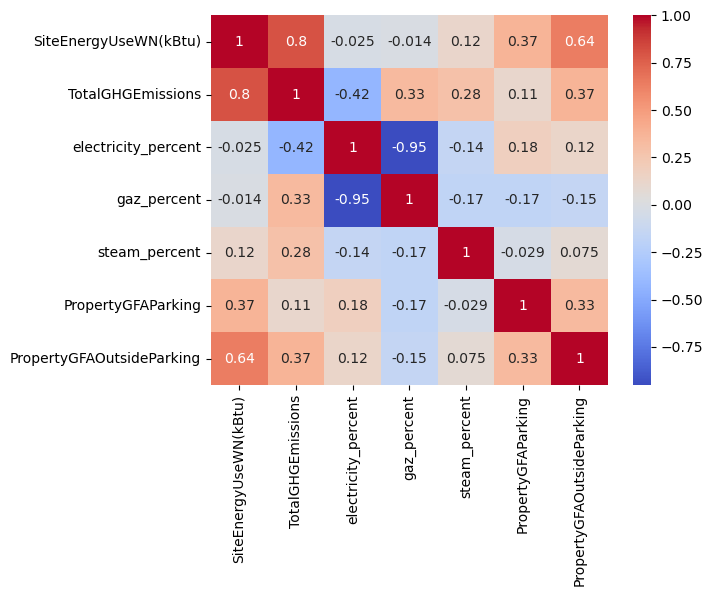

In [736]:
correlation_matrix = data_fe2[['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions', 'electricity_percent', 'gaz_percent', 'steam_percent', \
                           'PropertyGFAParking', 'PropertyGFAOutsideParking']].corr()

# Créer une heatmap pour la matrice de corrélation
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Afficher la heatmap
plt.show()

### 8 - Amélioration du feature engineering - 3ème fe

On utilise les mêmes features que dans le 2ème feature engineering, mais on utilise le TargetEncoder pour numériser les variables catégorielles, en choisissant la variable SiteEnergyUseWN(kBtu) comme cible (target).

On commence par charger le dataset qui avait été nettoyé lors du 1er feature engineering :

In [377]:
data_cleaned = pd.read_csv('C:/Users/admin/Documents/Projets/Projet_4/data_projet/cleaned/2016_Building_Energy_Benchmarking_cleaned.csv')
data_cleaned.head()

OSEBuildingID  DataYear        BuildingType PrimaryPropertyType  \
0              1      2016      NonResidential               Hotel   
1              2      2016      NonResidential               Hotel   
2              5      2016      NonResidential               Hotel   
3              8      2016      NonResidential               Hotel   
4              9      2016  Nonresidential COS               Other   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2                    HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
3  WARWICK SEATTLE HOTEL (ID8)    401 LENORA ST  Seattle    WA  98121.0   
4                West Precinct  810 Virginia St  Seattle    WA  98101.0   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                    0659000030                    7     DOWNTOWN  47.61220   
1                    0659000220                    7     DOWNTOWN  47.61317   
2                    0659000640                    7     DOWNTOWN  47.61412   
3                    0659000970                    7     DOWNTOWN  47.61375   
4                    0660000560                    7     DOWNTOWN  47.61623   

   Longitude  YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799       1927                1.0              12           88434.0   
1 -122.33393       1996                1.0              11          103566.0   
2 -122.33664       1926                1.0              10           61320.0   
3 -122.34047       1980                1.0              18          175580.0   
4 -122.33657       1999                1.0               2           97288.0   

   PropertyGFAParking  PropertyGFABuilding(s)      ListOfAllPropertyUseTypes  \
0                   0                   88434                          Hotel   
1               15064                   88502     Hotel, Parking, Restaurant   
2                   0                   61320                          Hotel   
3               62000                  113580  Hotel, Parking, Swimming Pool   
4               37198                   60090                 Police Station   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                    61320.0   
3                  Hotel                   123445.0   
4         Police Station                    88830.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                          NaN                              NaN   
1                      Parking                          15064.0   
2                          NaN                              NaN   
3                      Parking                          68009.0   
4                          NaN                              NaN   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                         NaN                             NaN   
1                  Restaurant                          4622.0   
2                         NaN                             NaN   
3               Swimming Pool                             0.0   
4                         NaN                             NaN   

  YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                      NaN             60.0         81.699997   
1                      NaN             61.0         94.800003   
2                      NaN             56.0        110.800003   
3                      NaN             75.0        114.800003   
4                      NaN              NaN        136.100006   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0           84.300003          182.500000            189.000000   
1           97.900002          176.100006   

#### 8.1 - Filtrer les features

In [379]:
features_fe3 = ['PrimaryPropertyType', 'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 'PropertyGFATotal', \
                'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', \
                'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'SteamUse(kBtu)', \
                'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']

In [380]:
data_fe3 = data_cleaned[features_fe3].copy()
data_fe3.head()

PrimaryPropertyType Neighborhood  YearBuilt  NumberofBuildings  \
0               Hotel     DOWNTOWN       1927                1.0   
1               Hotel     DOWNTOWN       1996                1.0   
2               Hotel     DOWNTOWN       1926                1.0   
3               Hotel     DOWNTOWN       1980                1.0   
4               Other     DOWNTOWN       1999                1.0   

   NumberofFloors  PropertyGFAParking  PropertyGFATotal  \
0              12                   0           88434.0   
1              11               15064          103566.0   
2              10                   0           61320.0   
3              18               62000          175580.0   
4               2               37198           97288.0   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                    61320.0   
3                  Hotel                   123445.0   
4         Police Station                    88830.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                          NaN                              NaN   
1                      Parking                          15064.0   
2                          NaN                              NaN   
3                      Parking                          68009.0   
4                          NaN                              NaN   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                         NaN                             NaN   
1                  Restaurant                          4622.0   
2                         NaN                             NaN   
3               Swimming Pool                             0.0   
4                         NaN                             NaN   

   Electricity(kBtu)  NaturalGas(kBtu)  SteamUse(kBtu)  SiteEnergyUseWN(kBtu)  \
0          3946027.0         1276453.0      2003882.00              7456910.0   
1          3242851.0         5145082.0            0.00              8664479.0   
2          2768924.0         1811213.0      2214446.25              6946800.5   
3          5368607.0         8803998.0            0.00             14656503.0   
4          7371434.0         4715182.0            0.00             12581712.0   

   TotalGHGEmissions  
0             249.98  
1             295.86  
2             286.43  
3             505.01  
4             301.81

#### 8.2 - Récupérer les transformations du 1er feature engineering à réutiliser

Mais en remplaçant le OneHotEncoder par le TargetEncoder.

In [382]:
# Transformer la feature YearBuilt en feature par plage d'année
## Créer 5 bins automatiques
data_fe3['YearBuilt_Bin'] = pd.cut(data_fe3['YearBuilt'], bins=10)
data_fe3.drop('YearBuilt', axis=1, inplace=True)

# Homogénéiser la feature Neighborhood
neighborhood_mapping = {
    'North': 'NORTH',
    'Ballard': 'BALLARD',
    'Delridge': 'DELRIDGE',
    'Northwest': 'NORTHWEST',
    'Central': 'CENTRAL'}
data_fe3['Neighborhood'] = data_fe3['Neighborhood'].replace(neighborhood_mapping)

# Numériser les variables catégorielles Neighborhood et YearBuilt_Bin
## Initialiser l'encodeur
encoder = TargetEncoder()

## Appliquer l'encodeur à une colonne spécifique
columns = ['Neighborhood', 'YearBuilt_Bin', 'PrimaryPropertyType']
encoder.fit(data_fe3[columns], data_fe3['SiteEnergyUseWN(kBtu)'])
encoded_columns = encoder.transform(data_fe3[columns])

## Ajouter les colonnes encodées dans le DataFrame original
encoded_data_fe3 = pd.DataFrame(encoded_columns, columns=columns)

## Vérifier que les indices sont les mêmes
encoded_data_fe3.index = data_fe3.index

## Concatenation des résultats avec le DataFrame d'origine (en excluant les colonnes encodées)
data_fe3 = pd.concat([data_fe3.drop(columns, axis=1), encoded_data_fe3], axis=1)

# Transformer les features Electricity , gaz et steam en une feature proportionnelle
data_fe3['electricity_percent'] = round(data_fe3['Electricity(kBtu)'] * 100 / (data_fe3['Electricity(kBtu)'] + data_fe3['NaturalGas(kBtu)'] + data_fe3['SteamUse(kBtu)']), 2)
data_fe3['gaz_percent'] = round(data_fe3['NaturalGas(kBtu)'] * 100 / (data_fe3['Electricity(kBtu)'] + data_fe3['NaturalGas(kBtu)'] + data_fe3['SteamUse(kBtu)']), 2)
data_fe3['steam_percent'] = round(data_fe3['SteamUse(kBtu)'] * 100 / (data_fe3['Electricity(kBtu)'] + data_fe3['NaturalGas(kBtu)'] + data_fe3['SteamUse(kBtu)']), 2)
data_fe3.drop('Electricity(kBtu)', axis=1, inplace=True)
data_fe3.drop('NaturalGas(kBtu)', axis=1, inplace=True)
data_fe3.drop('SteamUse(kBtu)', axis=1, inplace=True)

In [383]:
data_fe3.shape

(1444, 18)

In [384]:
data_fe3.head()

NumberofBuildings  NumberofFloors  PropertyGFAParking  PropertyGFATotal  \
0                1.0              12                   0           88434.0   
1                1.0              11               15064          103566.0   
2                1.0              10                   0           61320.0   
3                1.0              18               62000          175580.0   
4                1.0               2               37198           97288.0   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                    61320.0   
3                  Hotel                   123445.0   
4         Police Station                    88830.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                          NaN                              NaN   
1                      Parking                          15064.0   
2                          NaN                              NaN   
3                      Parking                          68009.0   
4                          NaN                              NaN   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                         NaN                             NaN   
1                  Restaurant                          4622.0   
2                         NaN                             NaN   
3               Swimming Pool                             0.0   
4                         NaN                             NaN   

   SiteEnergyUseWN(kBtu)  TotalGHGEmissions  Neighborhood  YearBuilt_Bin  \
0              7456910.0             249.98  5.000275e+06   3.533086e+06   
1              8664479.0             295.86  5.000275e+06   6.145114e+06   
2              6946800.5             286.43  5.000275e+06   3.533086e+06   
3             14656503.0             505.01  5.000275e+06   3.595235e+06   
4             12581712.0             301.81  5.000275e+06   6.145114e+06   

   PrimaryPropertyType  electricity_percent  gaz_percent  steam_percent  
0         6.218126e+06                54.61        17.66          27.73  
1         6.218126e+06                38.66        61.34           0.00  
2         6.218126e+06                40.75        26.66          32.59  
3         6.218126e+06                37.88        62.12           0.00  
4         4.209165e+06                60.99        39.01           0.00

#### 8.3 - Reprenons les transformations du 2ème feature engineering

In [386]:
# Fusionner les séries en une seule
merged = pd.concat([
    pd.Series(data_fe3['LargestPropertyUseType'].unique()),
    pd.Series(data_fe3['SecondLargestPropertyUseType'].unique()),
    pd.Series(data_fe3['ThirdLargestPropertyUseType'].unique())
])

# Supprimer les doublons et réinitialiser l'index
property_use_types = merged.drop_duplicates().reset_index(drop=True)

# Remplacer les catégories par leurs regroupements
data_fe3['LargestPropertyUseType'] = data_fe3['LargestPropertyUseType'].replace(category_mapping)
data_fe3['SecondLargestPropertyUseType'] = data_fe3['SecondLargestPropertyUseType'].replace(category_mapping)
data_fe3['ThirdLargestPropertyUseType'] = data_fe3['ThirdLargestPropertyUseType'].replace(category_mapping)

# Fusionner les séries en une seule
merged = pd.concat([
    pd.Series(data_fe3['LargestPropertyUseType'].unique()),
    pd.Series(data_fe3['SecondLargestPropertyUseType'].unique()),
    pd.Series(data_fe3['ThirdLargestPropertyUseType'].unique())
])

# Supprimer les doublons et réinitialiser l'index
property_use_types = merged.drop_duplicates().reset_index(drop=True)

# Traitons les valeurs manquantes de LargestPropertyUseType
data_fe3 = data_fe3.loc[~data_fe3['LargestPropertyUseType'].isna()]
data_fe3.shape

# Créons autant de features que de propertyUseType
categories = np.unique(np.array(list(category_mapping.values())).flatten())
print("categories : ", categories)

for cat in categories:    
    data_fe3[cat] = data_fe3.apply(
        lambda row: row['LargestPropertyUseTypeGFA'] if row['LargestPropertyUseType'] == cat else
                    row['SecondLargestPropertyUseTypeGFA'] if row['SecondLargestPropertyUseType'] == cat else
                    row['ThirdLargestPropertyUseTypeGFA'] if row['ThirdLargestPropertyUseType'] == cat else
                    0, axis=1
    )

# On peut maintenant calculer la proportion de chaque propertyUseType:

# Fusionner les séries en une seule
merged = pd.concat([
    pd.Series(data_fe3['LargestPropertyUseType'].unique()),
    pd.Series(data_fe3['SecondLargestPropertyUseType'].unique()),
    pd.Series(data_fe3['ThirdLargestPropertyUseType'].unique())
])

# Supprimer les doublons et réinitialiser l'index
property_use_types = merged.drop_duplicates().reset_index(drop=True)

# Calculer la somme des colonnes une fois pour toutes les lignes
total_sum = data_fe3[categories].sum(axis=1)

# Calculer le pourcentage pour chaque catégorie
for cat in categories:
    data_fe3[cat] = round((data_fe3[cat] * 100) / total_sum, 2)

# Supprimons les variables non utilisées

columns_to_drop = ['LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', \
                   'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA']
data_fe3 = data_fe3.drop(columns=columns_to_drop)

categories :  ['usage_Autres' 'usage_Bureaux & Espaces de travail'
 'usage_Commerce & Retail' 'usage_Entrepôts et Logistique'
 'usage_Hébergement & Logement' 'usage_Loisirs et Divertissement'
 'usage_Restauration' 'usage_Services publics & Infrastructure'
 'usage_Soins médicaux' 'usage_Transports & Parking' 'usage_Éducation']


In [387]:
# Créons la nouvelle feature PropertyGFAOutsideParking
data_fe3['PropertyGFAOutsideParking'] = data_fe3['PropertyGFATotal'] - data_fe3['PropertyGFAParking']

# Supprimons les éventuelles valeurs négatives
mask = data_fe3['PropertyGFAOutsideParking'] >= 0
data_fe3 = data_fe3.loc[mask]
data_fe3.shape

# Suprimons la feature PropertyGFATotal
data_fe3 = data_fe3.drop(columns=['PropertyGFATotal'])
data_fe3.shape

(1440, 23)

In [388]:
data_fe3.shape

(1440, 23)

In [389]:
data_fe3.head()

NumberofBuildings  NumberofFloors  PropertyGFAParking  \
0                1.0              12                   0   
1                1.0              11               15064   
2                1.0              10                   0   
3                1.0              18               62000   
4                1.0               2               37198   

   SiteEnergyUseWN(kBtu)  TotalGHGEmissions  Neighborhood  YearBuilt_Bin  \
0              7456910.0             249.98  5.000275e+06   3.533086e+06   
1              8664479.0             295.86  5.000275e+06   6.145114e+06   
2              6946800.5             286.43  5.000275e+06   3.533086e+06   
3             14656503.0             505.01  5.000275e+06   3.595235e+06   
4             12581712.0             301.81  5.000275e+06   6.145114e+06   

   PrimaryPropertyType  electricity_percent  gaz_percent  steam_percent  \
0         6.218126e+06                54.61        17.66          27.73   
1         6.218126e+06                38.66        61.34           0.00   
2         6.218126e+06                40.75        26.66          32.59   
3         6.218126e+06                37.88        62.12           0.00   
4         4.209165e+06                60.99        39.01           0.00   

   usage_Autres  usage_Bureaux & Espaces de travail  usage_Commerce & Retail  \
0           0.0                                 0.0                      0.0   
1           0.0                                 0.0                      0.0   
2           0.0                                 0.0                      0.0   
3           0.0                                 0.0                      0.0   
4           0.0                                 0.0                      0.0   

   usage_Entrepôts et Logistique  usage_Hébergement & Logement  \
0                            0.0                        100.00   
1                            0.0                         80.99   
2                            0.0                        100.00   
3                            0.0                         64.48   
4                            0.0                          0.00   

   usage_Loisirs et Divertissement  usage_Restauration  \
0                              0.0                0.00   
1                              0.0                4.46   
2                              0.0                0.00   
3                              0.0                0.00   
4                              0.0                0.00   

   usage_Services publics & Infrastructure  usage_Soins médicaux  \
0                                      0.0                   0.0   
1                                      0.0                   0.0   
2                                      0.0                   0.0   
3                                      0.0                   0.0   
4                                    100.0                   0.0   

   usage_Transports & Parking  usage_Éducation  PropertyGFAOutsideParking  
0                        0.00              0.0                    88434.0  
1                       14.55              0.0                    88502.0  
2                        0.00              0.0                    61320.0  
3                       35.52              0.0                   113580.0  
4                        0.00              0.0                    60090.0

#### 8.3 - Sauvegarder le résultat du 3ème feature engineering pour les analyses prédictives

In [391]:
data_fe3.to_csv('C:/Users/admin/Documents/Projets/Projet_4/data_projet/cleaned/2016_Building_Energy_Benchmarking_fe3.csv', index=False)

### 8 - Amélioration du feature engineering - 4ème fe

On repartira du résultat du 2ème feature engineering qui avait obtenu les meilleurs résultats dans les prédictions.

Je vais utiliser ici QuantileTransformer pour normaliser des données qui seraient asymétriques (biaisées) :
- Redistribue les données pour qu'elles suivent une distribution cible, par exemple une distribution uniforme ou gaussienne.
- Insensible à l'échelle absolue des données, car il utilise les quantiles.

Comment fonctionne QuantileTransformer :
- Il classe les valeurs de la variable par leur rang (par exemple, en déciles ou percentiles).
- Chaque rang est ensuite transformé pour correspondre à une valeur dans la distribution cible. Par défaut, la distribution cible est uniforme [0,1], mais elle peut être définie comme gaussienne (normalisation).

 #### 8.1 - Visualisation de 2 variables éligibles avant transformation :

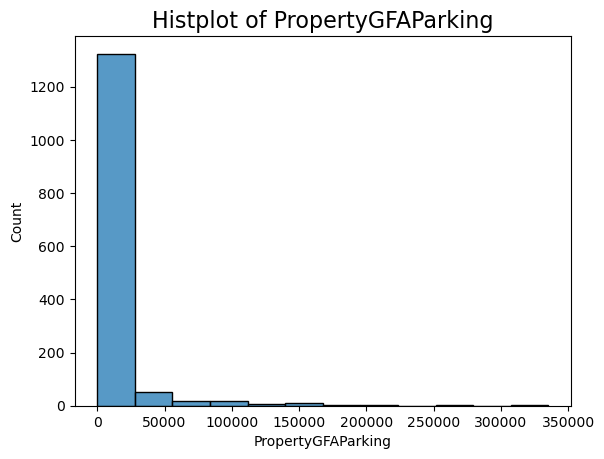

In [393]:
sns.histplot(data=data_fe2, x='PropertyGFAParking')
plt.title('Histplot of PropertyGFAParking', fontsize=16)
plt.show()

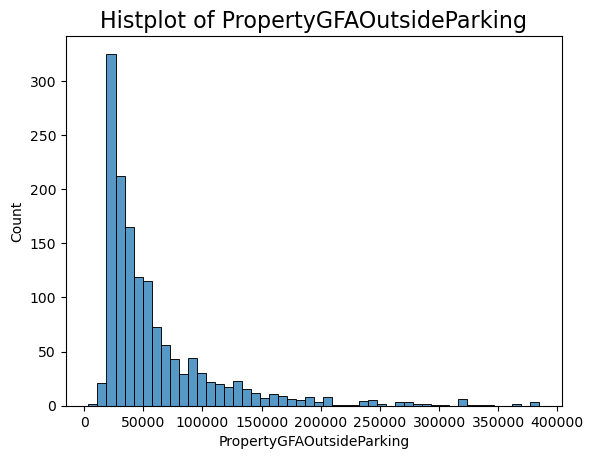

In [394]:
sns.histplot(data=data_fe2, x='PropertyGFAOutsideParking')
plt.title('Histplot of PropertyGFAOutsideParking', fontsize=16)
plt.show()

On voit que les données sont fortement asymétriques

#### 8.2 - appliquons le quantileTranformer

In [397]:
# Application de QuantileTransformer (par défaut, transforme en distribution uniforme)
quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=42)
data_transformed = quantile_transformer.fit_transform(data_fe2[['PropertyGFAOutsideParking', 'PropertyGFAParking']])

# Conversion en DataFrame
columns_to_transform = ['PropertyGFAOutsideParking', 'PropertyGFAParking']
data_transformed_df = pd.DataFrame(data_transformed, columns=columns_to_transform)

Visualisons les distributions après transformation :

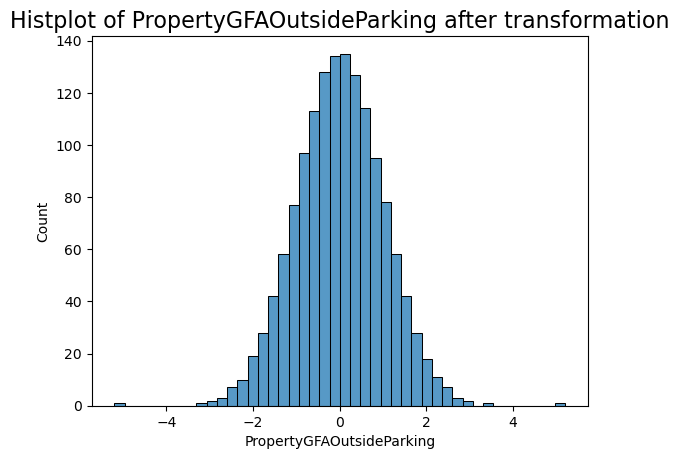

In [399]:
sns.histplot(data=data_transformed_df, x='PropertyGFAOutsideParking')
plt.title('Histplot of PropertyGFAOutsideParking after transformation', fontsize=16)
plt.show()

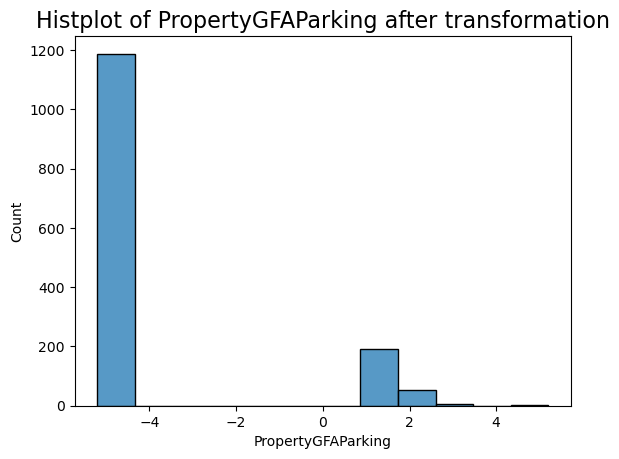

In [400]:
sns.histplot(data=data_transformed_df, x='PropertyGFAParking')
plt.title('Histplot of PropertyGFAParking after transformation', fontsize=16)
plt.show()

On voit que la transformation a été plus compliquée par la PropertyGFAParking. Mais je ne pense pas que cela soit important car au final elle intervient très peu dans la prédiction lorsqu'on regarde le poids des variables dans les modèles.

Créons le nouveau dataFrame, et ettons les nouvelles valeurs dans le dataframe :

In [402]:
data_fe4 = data_fe2.copy()

# Remplacement des colonnes dans le DataFrame initial
data_transformed_df.index = data_fe4.index
data_fe4[columns_to_transform] = data_transformed_df

data_fe4.shape

(1440, 66)

In [403]:
data_fe4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1440 entries, 0 to 1443
Data columns (total 66 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   NumberofBuildings                                1440 non-null   float64
 1   NumberofFloors                                   1440 non-null   int64  
 2   PropertyGFAParking                               1440 non-null   float64
 3   SiteEnergyUseWN(kBtu)                            1440 non-null   float64
 4   TotalGHGEmissions                                1440 non-null   float64
 5   Neighborhood_BALLARD                             1440 non-null   float64
 6   Neighborhood_CENTRAL                             1440 non-null   float64
 7   Neighborhood_DELRIDGE                            1440 non-null   float64
 8   Neighborhood_DELRIDGE NEIGHBORHOODS              1440 non-null   float64
 9   Neighborhood_DOWNTOWN              

#### 8.3 - Sauvegarder le résultat du 4ème feature engineering pour les analyses prédictives

In [405]:
data_fe4.to_csv('C:/Users/admin/Documents/Projets/Projet_4/data_projet/cleaned/2016_Building_Energy_Benchmarking_fe4.csv', index=False)

### 9 - Amélioration du feature engineering - 5ème fe

On repartira du résultat du 2ème feature engineering qui avait obtenu les meilleurs résultats dans les prédictions.

Je vais tester une réduction de dimensions avec l'ACP
    
#### 9.1 - Copier le dataframe du 2ème feature engineering

In [407]:
data_fe5 = data_fe2.copy()
data_fe5.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1440 entries, 0 to 1443
Data columns (total 66 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   NumberofBuildings                                1440 non-null   float64
 1   NumberofFloors                                   1440 non-null   int64  
 2   PropertyGFAParking                               1440 non-null   int64  
 3   SiteEnergyUseWN(kBtu)                            1440 non-null   float64
 4   TotalGHGEmissions                                1440 non-null   float64
 5   Neighborhood_BALLARD                             1440 non-null   float64
 6   Neighborhood_CENTRAL                             1440 non-null   float64
 7   Neighborhood_DELRIDGE                            1440 non-null   float64
 8   Neighborhood_DELRIDGE NEIGHBORHOODS              1440 non-null   float64
 9   Neighborhood_DOWNTOWN              

On retire les 2 cibles :

In [409]:
X_fe5 = data_fe5.drop('SiteEnergyUseWN(kBtu)', axis=1, inplace=False)
X_fe5 = X_fe5.drop('TotalGHGEmissions', axis=1, inplace=False)
X_fe5.shape

(1440, 64)

#### 9.2 - Initialisation de l'ACP

**Centrer et réduire**

In [411]:
# Créer un scaler
scaler = StandardScaler()

# Vérification et conversion des noms de colonnes en chaînes de caractères
X_fe5.columns = X_fe5.columns.str.replace(r'[^\w]', '_', regex=True)
print(X_fe5.columns)

# Appliquer le centrage uniquement sur les données
X_scaled = scaler.fit_transform(X_fe5)

# On le transforme en DataFrame : 
X_scaled = pd.DataFrame(X_scaled)

X_scaled.describe().round(2)

Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking',
       'Neighborhood_BALLARD', 'Neighborhood_CENTRAL', 'Neighborhood_DELRIDGE',
       'Neighborhood_DELRIDGE_NEIGHBORHOODS', 'Neighborhood_DOWNTOWN',
       'Neighborhood_EAST', 'Neighborhood_GREATER_DUWAMISH',
       'Neighborhood_LAKE_UNION', 'Neighborhood_MAGNOLIA___QUEEN_ANNE',
       'Neighborhood_NORTH', 'Neighborhood_NORTHEAST',
       'Neighborhood_NORTHWEST', 'Neighborhood_SOUTHEAST',
       'Neighborhood_SOUTHWEST', 'YearBuilt_Bin__1899_885__1911_5_',
       'YearBuilt_Bin__1911_5__1923_0_', 'YearBuilt_Bin__1923_0__1934_5_',
       'YearBuilt_Bin__1934_5__1946_0_', 'YearBuilt_Bin__1946_0__1957_5_',
       'YearBuilt_Bin__1957_5__1969_0_', 'YearBuilt_Bin__1969_0__1980_5_',
       'YearBuilt_Bin__1980_5__1992_0_', 'YearBuilt_Bin__1992_0__2003_5_',
       'YearBuilt_Bin__2003_5__2015_0_',
       'PrimaryPropertyType_Distribution_Center',
       'PrimaryPropertyType_Hospital', 'PrimaryPropertyType_Hotel',
      

0        1        2        3        4        5        6        7   \
count  1440.00  1440.00  1440.00  1440.00  1440.00  1440.00  1440.00  1440.00   
mean      0.00     0.00     0.00     0.00    -0.00    -0.00     0.00     0.00   
std       1.00     1.00     1.00     1.00     1.00     1.00     1.00     1.00   
min      -0.13    -0.82    -0.29    -0.22    -0.18    -0.18    -0.03    -0.48   
25%      -0.13    -0.55    -0.29    -0.22    -0.18    -0.18    -0.03    -0.48   
50%      -0.13    -0.29    -0.29    -0.22    -0.18    -0.18    -0.03    -0.48   
75%      -0.13     0.25    -0.29    -0.22    -0.18    -0.18    -0.03    -0.48   
max      12.51    25.59    12.04     4.64     5.44     5.70    37.93     2.08   

            8        9       10       11       12       13       14       15  \
count  1440.00  1440.00  1440.0  1440.00  1440.00  1440.00  1440.00  1440.00   
mean     -0.00     0.00     0.0     0.00     0.00     0.00    -0.00    -0.00   
std       1.00     1.00     1.0     1.00     1.00     1.00     1.00     1.00   
min      -0.28    -0.54    -0.3    -0.32    -0.22    -0.29    -0.24    -0.18   
25%      -0.28    -0.54    -0.3    -0.32    -0.22    -0.29    -0.24    -0.18   
50%      -0.28    -0.54    -0.3    -0.32    -0.22    -0.29    -0.24    -0.18   
75%      -0.28    -0.54    -0.3    -0.32    -0.22    -0.29    -0.24    -0.18   
max       3.60     1.84     3.3     3.17     4.64     3.48     4.18     5.70   

            16       17       18       19       20       21       22       23  \
count  1440.00  1440.00  1440.00  1440.00  1440.00  1440.00  1440.00  1440.00   
mean      0.00     0.00    -0.00    -0.00    -0.00    -0.00     0.00    -0.00   
std       1.00     1.00     1.00     1.00     1.00     1.00     1.00     1.00   
min      -0.16    -0.34    -0.29    -0.32    -0.18    -0.35    -0.43    -0.36   
25%      -0.16    -0.34    -0.29    -0.32    -0.18    -0.35    -0.43    -0.36   
50%      -0.16    -0.34    -0.29    -0.32    -0.18    -0.35    -0.43    -0.36   
75%      -0.16    -0.34    -0.29    -0.32    -0.18    -0.35    -0.43    -0.36   
max       6.07     2.93     3.44     3.08     5.44     2.86     2.31     2.77   

            24       25       26       27       28       29       30       31  \
count  1440.00  1440.00  1440.00  1440.00  1440.00  1440.00  1440.00  1440.00   
mean     -0.00    -0.00     0.00     0.00     0.00     0.00    -0.00    -0.00   
std       1.00     1.00     1.00     1.00     1.00     1.00     1.00     1.00   
min      -0.35    -0.35    -0.31    -0.19    -0.03    -0.21    -0.31    -0.05   
25%      -0.35    -0.35    -0.31    -0.19    -0.03    -0.21    -0.31    -0.05   
50%      -0.35    -0.35    -0.31    -0.19    -0.03    -0.21    -0.31    -0.05   
75%      -0.35    -0.35    -0.31    -0.19    -0.03    -0.21    -0.31    -0.05   
max       2.88     2.82     3.22     5.22    37.93     4.80     3.27    18.95   

            32       33       34       35       36       37       38       39  \
count  1440.00  1440.00  1440.00  1440.00  1440.00  1440.00  1440.00  1440.00   
mean      0.00     0.00    -0.00     0.00     0.00    -0.00     0.00     0.00   
std       1.00     1.00     1.00     1.00     1.00     1.00     1.00     1.00   
min      -0.28    -0.04    -0.14    -0.27    -0.05    -0.42    -0.09    -0.12   
25%      -0.28    -0.04    -0.14    -0.27    -0.05    -0.42    -0.09    -0.12   
50%      -0.28    -0.04    -0.14    -0.27    -0.05    -0.42    -0.09    -0.12   
75%      -0.28    -0.04    -0.14    -0.27    -0.05    -0.42    -0.09    -0.12   
max       3.60    26.81     7.10     3.72    21.89     2.41    11.40     8.43   

            40       41       42       43       44       45       46       47  \
count  1440.00  1440.00  1440.00  1440.00  1440.00  1440.00  1440.00  1440.00   
mean      0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00   
std       1.00     1.00     1.00     1.00     1.00     1.00     1.00     1.00   
min      -0.09    -0.25    -0.14    -0.10    -0

**Initialisation de l'ACP**

Nous allons travailler que sur les 6 premières composantes :

In [413]:
n_components = 6

On instancie notre ACP :

In [415]:
pca = PCA(n_components=n_components)

On l'entraine sur les données scalées :

In [417]:
pca.fit(X_scaled)

PCA(n_components=6)

#### 9.3 - Variance expliquée et éboulis des valeurs propres

% de captation de la variance:  [6.29 4.9  3.81 3.62 3.44 3.28]
cumulé :  [ 6. 11. 15. 19. 22. 25.]


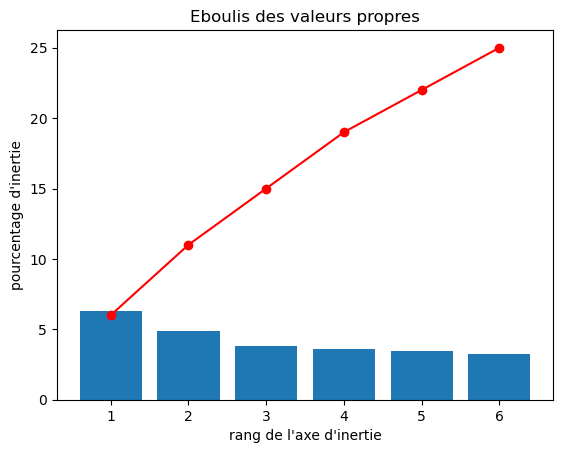

In [419]:
scree = (pca.explained_variance_ratio_*100).round(2)
print("% de captation de la variance: ", scree)

scree_cum = scree.cumsum().round()
print("cumulé : ", scree_cum)

x_list = range(1, n_components+1)

plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

On voit que les 6 premiers axes ne captent pas grand chose. Augmentons le nombre de composantes.

In [421]:
n_components = 35
pca = PCA(n_components=n_components)
pca.fit(X_scaled)

PCA(n_components=35)

% de captation de la variance:  [6.29 4.9  3.81 3.62 3.44 3.28 2.98 2.9  2.64 2.53 2.22 2.17 2.14 2.02
 1.96 1.94 1.9  1.87 1.84 1.83 1.79 1.75 1.74 1.7  1.68 1.64 1.62 1.61
 1.57 1.55 1.54 1.52 1.47 1.47 1.43]
cumulé :  [ 6. 11. 15. 19. 22. 25. 28. 31. 34. 36. 39. 41. 43. 45. 47. 49. 51. 53.
 54. 56. 58. 60. 62. 63. 65. 67. 68. 70. 71. 73. 74. 76. 77. 79. 80.]


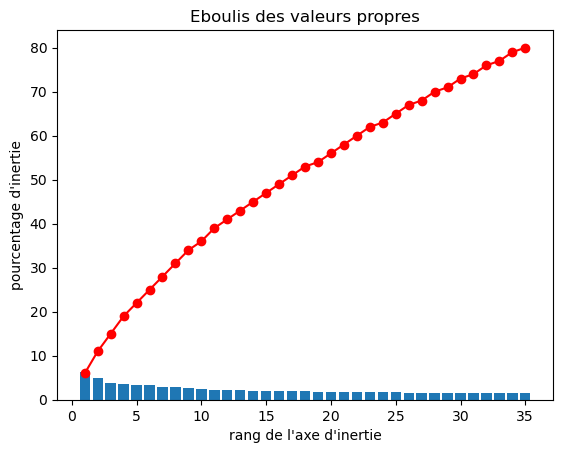

In [422]:
scree = (pca.explained_variance_ratio_*100).round(2)
print("% de captation de la variance: ", scree)

scree_cum = scree.cumsum().round()
print("cumulé : ", scree_cum)

x_list = range(1, n_components+1)

plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

On voit qu'il est difficile de se rapprocher des 100%, même avec un grande nombre de composantes. Avec 35 composantes, on atteint 80% de captation, pour une réduction par 2 des dimensions.

#### 9.4 - Composantes

Les composantes sont obtenues par un calcul. La formule de calcul est donnée par l'attribut components_. Cette variable est généralement nommée pcs :

In [425]:
x_list = range(1, n_components+1)

pcs = pd.DataFrame(pca.components_)

pcs.columns = X_fe5.columns
pcs.index = [f"F{i}" for i in x_list]
pcs.round(2)

NumberofBuildings  NumberofFloors  PropertyGFAParking  \
F1               -0.03            0.25                0.25   
F2               -0.02           -0.12               -0.06   
F3               -0.05           -0.06               -0.26   
F4               -0.04            0.20                0.03   
F5               -0.00           -0.05                0.11   
F6                0.03            0.02                0.15   
F7                0.14           -0.03                0.08   
F8               -0.08            0.05                0.15   
F9                0.02           -0.17                0.03   
F10              -0.03            0.14               -0.01   
F11              -0.03           -0.03                0.01   
F12               0.12            0.07               -0.13   
F13              -0.00            0.10                0.01   
F14               0.18           -0.00               -0.03   
F15              -0.19           -0.08               -0.03   
F16               0.04           -0.05               -0.02   
F17              -0.13            0.09               -0.03   
F18               0.03           -0.01               -0.03   
F19              -0.06            0.03               -0.08   
F20              -0.11           -0.01               -0.02   
F21               0.14           -0.03               -0.01   
F22              -0.19            0.00               -0.01   
F23              -0.28           -0.03               -0.03   
F24              -0.20           -0.03                0.04   
F25               0.20            0.04               -0.04   
F26              -0.10            0.03               -0.03   
F27              -0.01            0.04                0.06   
F28               0.02           -0.03               -0.02   
F29              -0.06           -0.02                0.05   
F30              -0.34            0.03                0.05   
F31               0.01           -0.04               -0.06   
F32               0.18           -0.03               -0.01   
F33              -0.12            0.02                0.07   
F34              -0.09           -0.05                0.05   
F35              -0.27           -0.07                0.02   

     Neighborhood_BALLARD  Neighborhood_CENTRAL  Neighborhood_DELRIDGE  \
F1                  -0.05                 -0.03                  -0.05   
F2                  -0.02                 -0.06                   0.00   
F3                   0.05                 -0.01                  -0.05   
F4                  -0.04                 -0.08                  -0.07   
F5                   0.02                 -0.07                  -0.00   
F6                   0.01                 -0.01                   0.00   
F7                  -0.02                  0.06                  -0.01   
F8                   0.04                 -0.10                   0.00   
F9                   0.01                  0.03                  -0.02   
F10                 -0.03                 -0.00                  -0.00   
F11                 -0.09                 -0.01                  -0.16   
F12                 -0.05                 -0.00                   0.11   
F13                 -0.15                  0.04                   0.12   
F14                  0.08                  0.35                  -0.00   
F15                 -0.08                 -0.18                  -0.16   
F16                  0.08                 -0.03                   0.06   
F17                  0.15                 -0.03                  -0.31   
F18                 -0.24                  0.13                  -0.01   
F19                  0.16                 -0.01                   0.01   
F20                  0.29                 -0.00                   0.06   
F21                 -0.10                  0.15                   0.25   
F22                  0.13                 -0.27                   0.31   
F23                 -0.05                 -0.11                   0.08

Pour une représentation plus visuelle :

<Axes: >

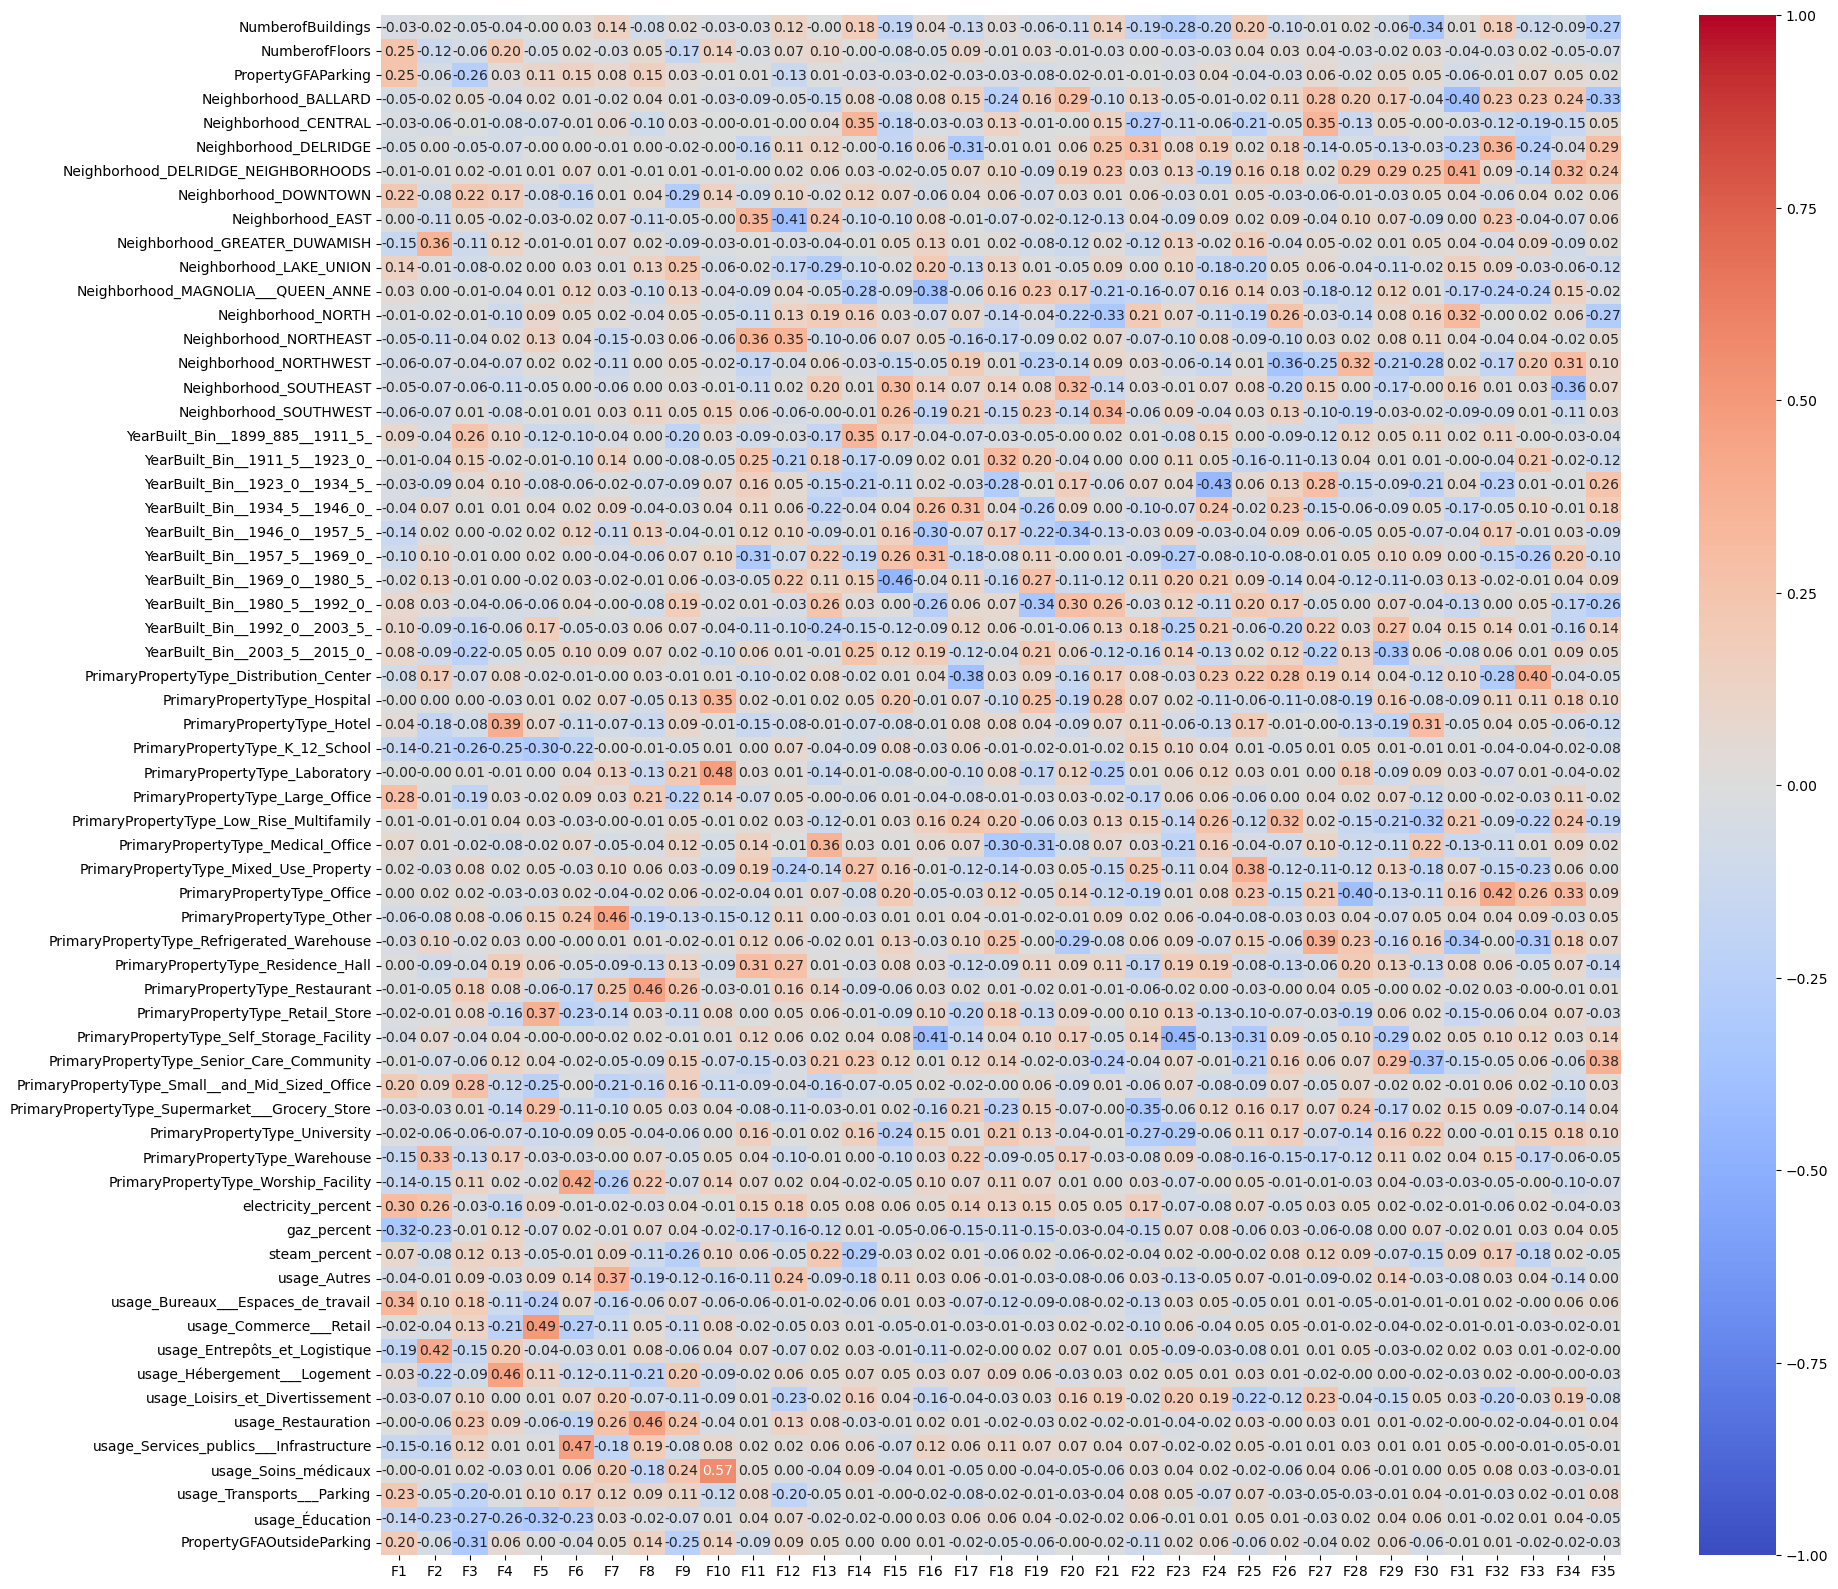

In [427]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

Les features qui participent le plus à l'axe F1 positivement sont :
- Nombre d'étages
- La surface des parkings
- La surface des espaces de vie
- Le quartie Downtown
- Le pourcentage d'électricité
- Les suraces d'usage des bureaux et espaces de travail
- Les surfaces d'usage des transports et parking
- La primaryPropertyType "large office"

Les features qui participent le plus à l'axe F1 négativement sont :
- Le pourcentage de gaz

#### 9.5 - Cercle des corrélations - lien entre les variables

**1er plan factoriel**

Comme il y a beaucoup de features, on va filtrer sur la longueur des flèches. (threshold = 0.3). Ce qui permettra de visualiser uniquement les features qui participent le plus

In [430]:
def correlation_graph(pca, 
                      x_y, 
                      features, 
                      threshold=0.3): 
    """
    Affiche le graphe des corrélations avec seulement les flèches ayant une norme supérieure au seuil.

    Arguments :
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    threshold : float : seuil pour la norme des vecteurs à afficher (par défaut : 0.5)
    """

    # Extrait x et y 
    x, y = x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):
        # Calcul de la norme du vecteur (x, y)
        norm = np.sqrt(pca.components_[x, i]**2 + pca.components_[y, i]**2)
        
        # Filtrer selon le seuil
        if norm >= threshold:
            # Les flèches
            ax.arrow(0, 0, 
                     pca.components_[x, i],  
                     pca.components_[y, i],  
                     head_width=0.07,
                     head_length=0.07, 
                     width=0.02)

            # Les labels
            plt.text(pca.components_[x, i] + 0.05,
                     pca.components_[y, i] + 0.05,
                     features[i])
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    # Titre
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

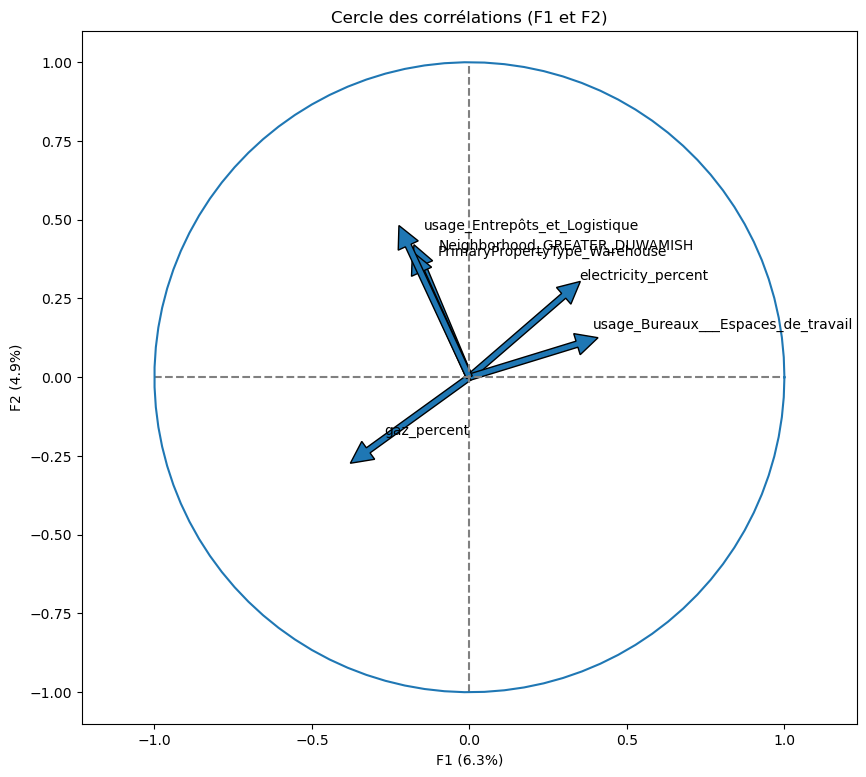

In [431]:
# Sélection des 2 premières composantes
x_y = (0,1)

# appel de la fonction pour afficher le cercle des corrélations
correlation_graph(pca, x_y, X_fe5.columns)

**2ème plan factoriel**

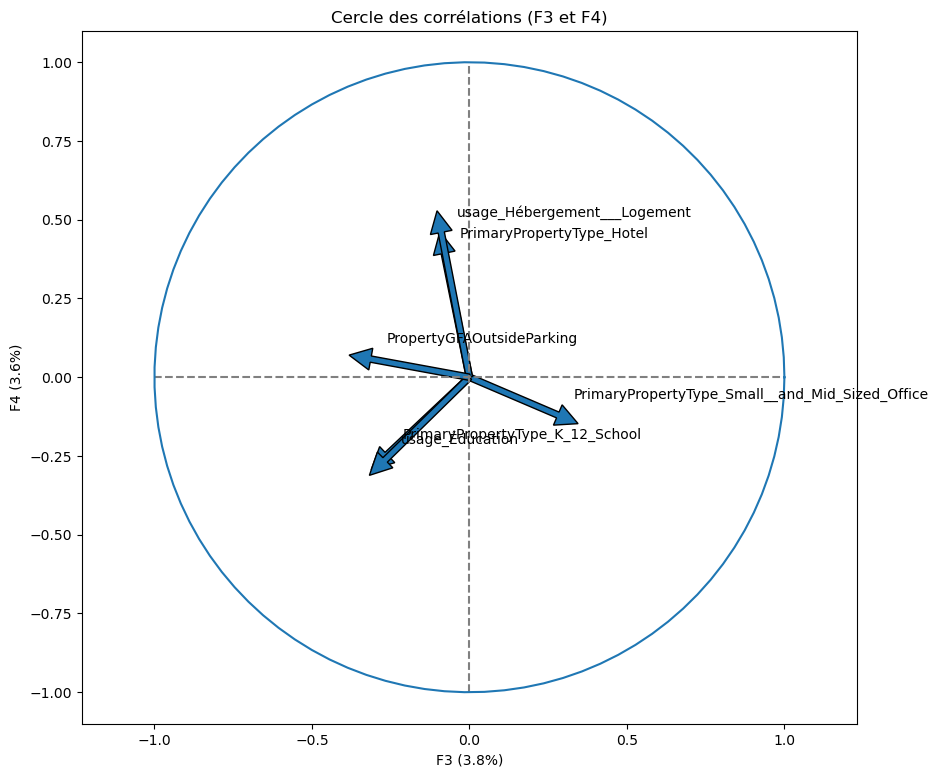

In [433]:
# Sélection des 2 premières composantes
x_y = (2,3)

# appel de la fonction pour afficher le cercle des corrélations
correlation_graph(pca, x_y, X_fe5.columns)

**3ème plan factoriel**

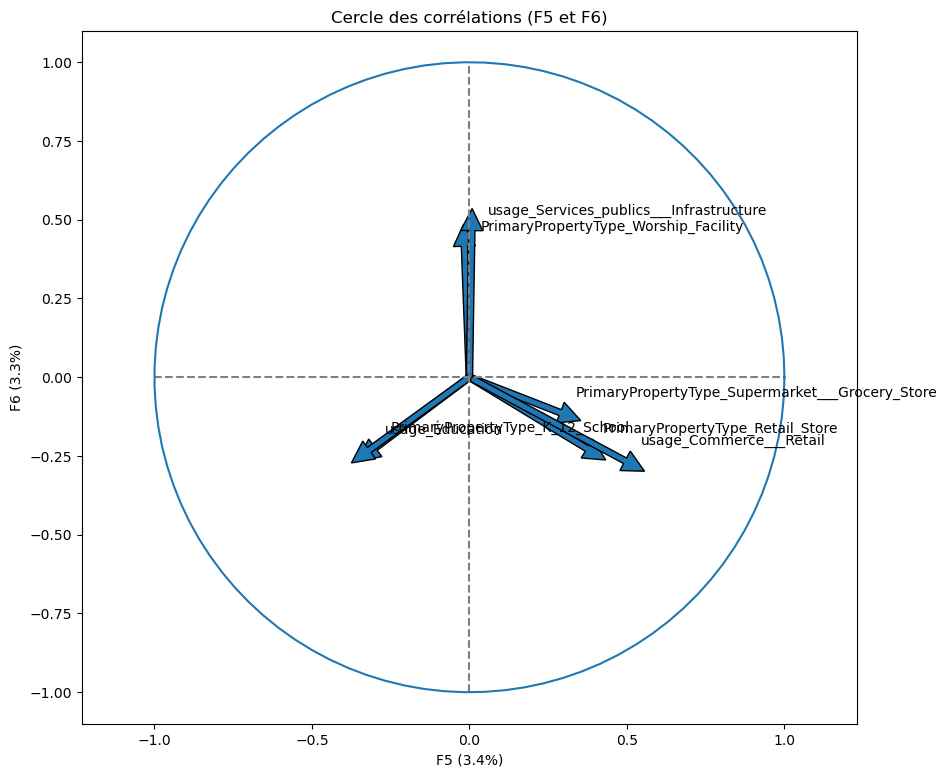

In [435]:
# Sélection des 2 premières composantes
x_y = (4,5)

# appel de la fonction pour afficher le cercle des corrélations
correlation_graph(pca, x_y, X_fe5.columns)

#### 9.6 - Construire le dataframe du 5ème feature engineering pour la prédiction

Calculer les coordonnées de nos individus dans le nouvel espace :

In [438]:
X_proj = pca.transform(X_scaled)
X_proj[:5]

array([[ 1.45363216, -2.99963819,  0.07530167,  5.59951181,  0.05597698,
        -1.76437208, -0.61854465, -1.891502  , -1.18306496,  0.97373311,
        -0.36279799,  0.36548368,  0.59719992, -1.45330585, -0.65253535,
        -0.04349181,  0.93113968, -0.27902365,  0.40491696, -0.11923889,
         0.12214906,  0.90628029, -0.04442903, -2.09485365,  1.2866543 ,
         0.78202303,  1.16661971, -0.94912903, -1.57079312,  0.424001  ,
         0.05848265, -0.18426287, -0.17530936, -0.37965033, -0.03718213],
       [ 1.21667893, -3.12780291, -1.12752118,  4.58949454,  0.93456747,
        -1.35395715, -0.56545037, -0.39664536,  0.39661819,  0.13139115,
        -1.74720513, -0.59509392, -0.67721222, -0.34045921, -0.70582382,
        -0.62762781,  0.90861775,  0.68585534, -0.11887005, -0.76525599,
         0.60825711,  1.10093881, -0.88787521,  0.18524687,  0.85006793,
        -0.5862712 ,  0.37027512, -0.80387105, -0.16858841,  1.98503927,
         0.05183566,  0.47207376,  0.49839603, -0.

In [439]:
X_proj.shape

(1440, 35)

In [440]:
# Créer des noms de colonnes basés sur les composantes principales
n_components = X_proj.shape[1]  # Nombre de composantes principales
component_names = [f"PC{i+1}" for i in range(n_components)]

# Convertir en DataFrame
X_proj_df = pd.DataFrame(X_proj, columns=component_names)
X_proj_df.index = X_scaled.index

X_proj_df.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  1.453632 -2.999638  0.075302  5.599512  0.055977 -1.764372 -0.618545   
1  1.216679 -3.127803 -1.127521  4.589495  0.934567 -1.353957 -0.565450   
2  0.999385 -3.167150  0.347312  5.665805 -0.018957 -1.750907 -0.568275   
3  2.180358 -2.701967 -1.728975  4.858142  0.522561 -0.384211 -0.267510   
4 -0.094781 -1.621238  0.468862  0.180881  0.935240  2.158340  0.559620   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0 -1.891502 -1.183065  0.973733 -0.362798  0.365484  0.597200 -1.453306   
1 -0.396645  0.396618  0.131391 -1.747205 -0.595094 -0.677212 -0.340459   
2 -2.007662 -1.129835  0.879391 -0.406909  0.107375  0.582007 -1.658257   
3 -0.122185 -0.103720  0.395555 -1.507890 -0.070063  0.472838  0.528502   
4  0.743703 -1.100819  0.116262 -0.892894  0.112004 -0.651724 -0.021815   

       PC15      PC16      PC17      PC18      PC19      PC20      PC21  \
0 -0.652535 -0.043492  0.931140 -0.279024  0.404917 -0.119239  0.122149   
1 -0.705824 -0.627628  0.908618  0.685855 -0.118870 -0.765256  0.608257   
2 -0.675599 -0.053279  0.776031 -0.386226  0.300778 -0.183654  0.096907   
3 -2.008743 -0.659097  0.803745 -0.191141  0.592892 -0.988809 -0.343554   
4 -0.470948  0.027610  0.763725  0.696729 -0.087678  0.136360  0.824081   

       PC22      PC23      PC24      PC25      PC26      PC27      PC28  \
0  0.906280 -0.044429 -2.094854  1.286654  0.782023  1.166620 -0.949129   
1  1.100939 -0.887875  0.185247  0.850068 -0.586271  0.370275 -0.803871   
2  0.794074  0.029913 -2.041754  1.229061  0.835677  1.202242 -0.943790   
3  0.917940  0.492118  0.117125  1.363089 -0.417234 -0.133514 -1.427921   
4  1.004146 -0.724854  0.626553 -0.190531 -0.872489  0.655558  0.221221   

       PC29      PC30      PC31      PC32      PC33      PC34      PC35  
0 -1.570793  0.424001  0.058483 -0.184263 -0.175309 -0.379650 -0.037182  
1 -0.168588  1.985039  0.051836  0.472074  0.498396 -0.783145 -0.035104  
2 -1.639674  0.387150  0.129633 -0.037902 -0.278652 -0.296372  0.018800  
3 -1.300296  1.957959 -0.189240 -0.171259  0.626758 -0.180028 -0.187329  
4  0.703184  0.586650  0.781251  0.351891  0.481035 -0.657395  0.769649

Puis on ajoute les 2 cibles :

In [442]:
X_proj_df.index = data_fe5.index  # Alignement explicite

X_proj_df['SiteEnergyUseWN(kBtu)'] = data_fe5['SiteEnergyUseWN(kBtu)']
X_proj_df['TotalGHGEmissions'] = data_fe5['TotalGHGEmissions']
X_proj_df.shape

(1440, 37)

In [443]:
X_proj_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1440 entries, 0 to 1443
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PC1                    1440 non-null   float64
 1   PC2                    1440 non-null   float64
 2   PC3                    1440 non-null   float64
 3   PC4                    1440 non-null   float64
 4   PC5                    1440 non-null   float64
 5   PC6                    1440 non-null   float64
 6   PC7                    1440 non-null   float64
 7   PC8                    1440 non-null   float64
 8   PC9                    1440 non-null   float64
 9   PC10                   1440 non-null   float64
 10  PC11                   1440 non-null   float64
 11  PC12                   1440 non-null   float64
 12  PC13                   1440 non-null   float64
 13  PC14                   1440 non-null   float64
 14  PC15                   1440 non-null   float64
 15  PC16     

In [444]:
data_fe5 = X_proj_df.copy()

In [445]:
data_fe5.to_csv('C:/Users/admin/Documents/Projets/Projet_4/data_projet/cleaned/2016_Building_Energy_Benchmarking_fe5.csv', index=False)